<a href="https://colab.research.google.com/github/Shamshad-Gilani/NLP-Projects/blob/main/cosine_similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#sapbert
import csv
from collections import defaultdict
import numpy as np
from sentence_transformers import SentenceTransformer
import re
from collections import Counter
import math
import pandas as pd
import os
from transformers import AutoTokenizer, AutoModel
import torch

# File paths
original_file = '/content/icd_11_prompt_delimited.txt'  # Format: Disorder Name|Disorder Code|Disorder Symptoms
rephrased_file = '/content/10_records_per_icd.txt'  # Same format, ~4358 records
cleaned_rephrased_file = '/content/sapbert_cleaned_rephrased.txt'
output_file = '/content/sapbert_cosine_similarity_unique_sorted.txt'  # Pipe-delimited unique output
high_similarity_file = '/content/sapbert_high_similarity_pairs.csv'  # New file for similarity > 0.75
unmatched_log = '/content/sapbert_unmatched_icd_codes.txt'
low_similarity_log = '/content/sapbert_low_similarity_pairs.csv'
malformed_log = '/content/sapbert_malformed_rephrased.txt'
original_codes_log = '/content/sapbert_original_codes.txt'
rephrased_codes_log = '/content/sapbert_rephrased_codes.txt'

# Debug input files
for file_path in [original_file, rephrased_file]:
    if not os.path.exists(file_path):
        print(f"Error: File {file_path} not found.")
        exit()
    print(f"File size of {file_path}: {os.path.getsize(file_path)} bytes")
    with open(file_path, 'r', encoding='utf-8') as f:
        print(f"First 2 lines of {file_path}:")
        for i, line in enumerate(f):
            if i < 2:
                print(line.strip())
            else:
                break

# Expanded typo/synonym correction dictionary for ICD terms
typo_corrections = {
    'behaviour': 'behavior',
    'behaviours': 'behaviors',
    'adaptative': 'adaptive',
    'intelectual': 'intellectual',
    'standerd': 'standard',
    'deviation': 'deviations',
    'cognitive': 'intellectual',  # Medical synonym
    'mental': 'intellectual',
    'adaptive behaviour': 'adaptive behavior',
    'belowaverage': 'below average',
    'standardised': 'standardized',
    'percentile': 'percentiles',
}

# Normalize ICD code: remove prefixes, uppercase, strip whitespace
def normalize_code(code):
    code = re.sub(r'^\s*Disorder Code:\s*', '', code, flags=re.IGNORECASE)
    code = re.sub(r'\s+', '', code)
    return code.upper()

# Preprocess text: lowercase, remove punctuation, correct typos/synonyms
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    for wrong, correct in typo_corrections.items():
        text = text.replace(wrong, correct)
    return text

# Clean rephrased file: remove empty lines and non-data entries
def clean_rephrased_file(input_file, output_file):
    valid_lines = []
    with open(input_file, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip() and '|' in line and len(line.split('|')) == 3:
                valid_lines.append(line.strip())
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write('\n'.join(valid_lines))
    print(f"Cleaned rephrased file saved to {output_file}. {len(valid_lines)} valid records.")

# TF-IDF cosine similarity function (fallback)
def compute_tf_idf_cosine(original, rephrased):
    docs = [preprocess_text(original), preprocess_text(rephrased)]
    vocab = list(set(word for doc in docs for word in doc.split()))
    tf_docs = [[Counter(doc.split()).get(word, 0) / len(doc.split()) for word in vocab] for doc in docs]
    N = len(docs)
    idf = [math.log(N / (1 + sum(1 for doc in docs if word in doc))) for word in vocab]
    tfidf_docs = [[tf * idf_val for tf, idf_val in zip(tf_vector, idf)] for tf_vector in tf_docs]
    vec1, vec2 = np.array(tfidf_docs[0]), np.array(tfidf_docs[1])
    dot = np.dot(vec1, vec2)
    norm1, norm2 = np.linalg.norm(vec1), np.linalg.norm(vec2)
    return dot / (norm1 * norm2) if norm1 > 0 and norm2 > 0 else 0.0

# Clean rephrased file
clean_rephrased_file(rephrased_file, cleaned_rephrased_file)
rephrased_file = cleaned_rephrased_file

# Read original records
original_records = {}
original_codes = set()
with open(original_file, 'r', encoding='utf-8') as f:
    reader = csv.reader(f, delimiter='|')
    for row in reader:
        if len(row) == 3:
            name, code, symptoms = [field.strip() for field in row]
            code = normalize_code(code)
            original_records[code] = preprocess_text(symptoms)
            original_codes.add(code)
        else:
            print(f"Skipping malformed original record: {row}")

# Save original codes
with open(original_codes_log, 'w', encoding='utf-8') as f:
    for code in sorted(original_codes):
        f.write(f"{code}\n")
print(f"Saved {len(original_codes)} original ICD codes to {original_codes_log}")

# Read rephrased records
rephrased_records = []
rephrased_codes = set()
malformed_rephrased = []
with open(rephrased_file, 'r', encoding='utf-8') as f:
    reader = csv.reader(f, delimiter='|')
    for row in reader:
        if len(row) == 3:
            name, code, symptoms = [field.strip() for field in row]
            code = normalize_code(code)
            rephrased_records.append((code, preprocess_text(symptoms)))
            rephrased_codes.add(code)
        else:
            malformed_rephrased.append(row)
            print(f"Skipping malformed rephrased record: {row}")

# Save rephrased codes
with open(rephrased_codes_log, 'w', encoding='utf-8') as f:
    for code in sorted(rephrased_codes):
        f.write(f"{code}\n")
print(f"Saved {len(rephrased_codes)} rephrased ICD codes to {rephrased_codes_log}")

# Log malformed rephrased records
if malformed_rephrased:
    with open(malformed_log, 'w', encoding='utf-8') as f:
        for row in malformed_rephrased:
            f.write(f"{row}\n")
    print(f"Logged {len(malformed_rephrased)} malformed rephrased records to {malformed_log}")

# Check code overlap
common_codes = rephrased_codes & original_codes
print(f"\nInput Validation: {len(common_codes)} common ICD codes between original and rephrased datasets")

# Initialize embedding method with MedBERT
try:
    # Load MedBERT model and tokenizer
    model_name = 'bionlp/medbert-base-uncased'
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    print("Using MedBERT embeddings")
    use_pubmedbert = True
except Exception as e:
    print(f"Error initializing MedBERT: {e}. Falling back to TF-IDF.")
    use_pubmedbert = False

def compute_medbert_embeddings(texts, tokenizer, model, batch_size=32):
    model.eval()
    embeddings = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
        inputs = {key: val.to(device) for key, val in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
        # Use [CLS] token embedding (first token)
        batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.extend(batch_embeddings)
    return np.array(embeddings)

# Compute cosine similarities with progress tracking and batching
results = []
low_similarity_pairs = []
high_similarity_pairs = []
total_pairs = len(rephrased_records) * len(original_records)
processed_pairs = 0
batch_size = 100

# Pre-embed original symptoms for efficiency
if use_pubmedbert:
    original_symptoms = list(original_records.values())
    original_embeddings_raw = compute_medbert_embeddings(original_symptoms, tokenizer, model, batch_size=32)
    original_embeddings = {
        code: original_embeddings_raw[i]
        for i, code in enumerate(original_records.keys())
    }

# Process rephrased records in batches
for i in range(0, len(rephrased_records), batch_size):
    batch = rephrased_records[i:i + batch_size]
    rephrased_symptoms_batch = [symptoms for _, symptoms in batch]
    rephrased_codes_batch = [code for code, _ in batch]

    # Embed batch of rephrased symptoms
    if use_pubmedbert:
        rephrased_embeddings = compute_medbert_embeddings(rephrased_symptoms_batch, tokenizer, model, batch_size=32)

    for j, (rephrased_code, rephrased_symptoms) in enumerate(batch):
        for original_code, original_symptoms in original_records.items():
            try:
                if use_pubmedbert:
                    rephrased_vector = np.array(rephrased_embeddings[j])
                    original_vector = original_embeddings[original_code]
                    cosine_similarity = np.dot(original_vector, rephrased_vector) / (
                        np.linalg.norm(original_vector) * np.linalg.norm(rephrased_vector)
                    )
                else:
                    cosine_similarity = compute_tf_idf_cosine(original_symptoms, rephrased_symptoms)

                results.append([rephrased_code, original_code, rephrased_symptoms, original_symptoms, cosine_similarity])
                if cosine_similarity < 0.9:
                    low_similarity_pairs.append([rephrased_code, original_code, rephrased_symptoms, original_symptoms, f"{cosine_similarity:.4f}"])
                if cosine_similarity > 0.75:
                    high_similarity_pairs.append([rephrased_code, original_code, rephrased_symptoms, original_symptoms, f"{cosine_similarity:.4f}"])
                # Debug similarity scores
                if processed_pairs < 10 or cosine_similarity > 0.9:
                    print(f"Similarity {cosine_similarity:.4f} for {rephrased_code} vs {original_code}")

                processed_pairs += 1
                if processed_pairs % 1000 == 0:
                    print(f"Processed {processed_pairs}/{total_pairs} pairs ({processed_pairs/total_pairs*100:.2f}%)")
            except Exception as e:
                print(f"Error processing rephrase {rephrased_code} with original {original_code}: {e}")

# Create DataFrame, sort by cosine similarity, and select unique records
if results:
    df = pd.DataFrame(results, columns=['Rephrased ICD Code', 'Original ICD Code', 'Rephrased Symptoms', 'Original Symptoms', 'Cosine Similarity'])
    # Sort by Cosine Similarity in descending order
    df_sorted = df.sort_values(by='Cosine Similarity', ascending=False)
    # Select unique record with highest similarity per Rephrased ICD Code
    df_unique = df_sorted.groupby('Rephrased ICD Code').first().reset_index()
    # Save to pipe-delimited text file
    with open(output_file, 'w', encoding='utf-8') as f:
        for _, row in df_unique.iterrows():
            f.write(f"{row['Rephrased ICD Code']}|{row['Original ICD Code']}|{row['Cosine Similarity']:.4f}|{row['Rephrased Symptoms']}|{row['Original Symptoms']}\n")
    print(f"Sorted unique records with cosine similarity saved to {output_file}")
else:
    print("No results computed. Check embedding errors or input data.")

# Save low similarity pairs
if low_similarity_pairs:
    with open(low_similarity_log, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Rephrased ICD Code', 'Original ICD Code', 'Rephrased Symptoms', 'Original Symptoms', 'Cosine Similarity'])
        writer.writerows(low_similarity_pairs)
    print(f"Logged {len(low_similarity_pairs)} pairs with similarity < 0.9 to {low_similarity_log}")

# Save high similarity pairs (> 0.75)
if high_similarity_pairs:
    with open(high_similarity_file, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Rephrased ICD Code', 'Original ICD Code', 'Rephrased Symptoms', 'Original Symptoms', 'Cosine Similarity'])
        writer.writerows(high_similarity_pairs)
    print(f"Logged {len(high_similarity_pairs)} pairs with similarity > 0.75 to {high_similarity_file}")

# Log unmatched ICD codes
unmatched_codes = [code for code in original_records if code not in rephrased_codes]
if unmatched_codes:
    with open(unmatched_log, 'w', encoding='utf-8') as f:
        for code in unmatched_codes:
            f.write(f"{code}\n")
    print(f"Logged {len(unmatched_codes)} unmatched ICD codes to {unmatched_log}")

# Validation summary
total_original = len(original_records)
total_rephrased = len(rephrased_records)
matched_codes = len([code for code in original_records if code in rephrased_codes])
average_rephrases = total_rephrased / matched_codes if matched_codes > 0 else 0

# Compute average similarity per rephrased code
similarities_per_code = defaultdict(list)
for result in results:
    similarities_per_code[result[0]].append(float(result[4]))
average_similarities = {code: np.mean(sims) for code, sims in similarities_per_code.items()}

print("\nValidation Summary:")
print(f"Total original records: {total_original}")
print(f"Total rephrased records: {total_rephrased}")
print(f"Matched ICD codes: {matched_codes} ({matched_codes / total_original * 100:.2f}%)")
print(f"Average rephrases per matched code: {average_rephrases:.2f}")
print(f"High similarity pairs (> 0.75): {len(high_similarity_pairs)}")
print("\nAverage Cosine Similarity per Rephrased ICD Code:")
for code, avg_sim in sorted(average_similarities.items()):
    print(f"Rephrased ICD Code {code}: {avg_sim:.4f}")

# Overall average similarity
if results:
    overall_avg = np.mean([float(result[4]) for result in results])
    print(f"\nOverall Average Cosine Similarity: {overall_avg:.4f}")

# Validate sorted unique output and count matches
if results:
    with open(output_file, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        unique_records = len(lines)
        df_unique = pd.read_csv(output_file, sep='|', names=['Rephrased ICD Code', 'Original ICD Code', 'Cosine Similarity', 'Rephrased Symptoms', 'Original Symptoms'])
        df_unique['Cosine Similarity'] = df_unique['Cosine Similarity'].astype(float)
        df_temp = pd.DataFrame(results, columns=['Rephrased ICD Code', 'Original ICD Code', 'Rephrased Symptoms', 'Original Symptoms', 'Cosine Similarity'])
        df_merged = df_unique.merge(df_temp, on=['Rephrased ICD Code', 'Original ICD Code', 'Rephrased Symptoms', 'Original Symptoms', 'Cosine Similarity'], how='left')
        is_sorted = df_merged['Cosine Similarity'].is_monotonic_decreasing if not df_merged.empty else False
        unique_codes = len(df_unique['Rephrased ICD Code'].unique())

        # Count exact and four-character matches
        df_unique['Rephrased ICD Code'] = df_unique['Rephrased ICD Code'].astype(str).str.strip()
        df_unique['Original ICD Code'] = df_unique['Original ICD Code'].astype(str).str.strip()
        exact_matches = df_unique[df_unique['Rephrased ICD Code'] == df_unique['Original ICD Code']].shape[0]
        df_unique['Rephrased ICD Prefix'] = df_unique['Rephrased ICD Code'].str[:4]
        df_unique['Original ICD Prefix'] = df_unique['Original ICD Code'].str[:4]
        four_char_matches = df_unique[df_unique['Rephrased ICD Prefix'] == df_unique['Original ICD Prefix']].shape[0]

        print(f"\nUnique Output Validation:")
        print(f"Unique records in output: {unique_records}")
        print(f"Unique rephrased ICD codes in output: {unique_codes}")
        print(f"Sorted by Cosine Similarity (descending): {is_sorted}")
        print(f"Number of records where Rephrased ICD Code exactly matches Original ICD Code: {exact_matches} ({exact_matches/unique_records*100:.2f}%)")
        print(f"Number of records where first 4 characters of Rephrased ICD Code match Original ICD Code: {four_char_matches} ({four_char_matches/unique_records*100:.2f}%)")

        # Check specific codes
        check_codes = ['6A01.Y', '6A01.Z', '6A0Z', '6A20.Z', '6A21.Z', '6A23.Z']
        print("\nChecking specific rephrased codes in output:")
        for code in check_codes:
            if code in df_unique['Rephrased ICD Code'].values:
                filtered = df_merged[df_merged['Rephrased ICD Code'] == code]
                if not filtered.empty:
                    similarity = filtered['Cosine Similarity'].iloc[0]
                    print(f"{code} found with highest similarity: {similarity:.4f}")
                else:
                    print(f"{code} found in output but not matched in merged results")
            else:
                print(f"{code} not found in output")
else:
    print("No results computed. Check embedding errors or input data.")

File size of /content/icd_11_prompt_delimited.txt: 1280665 bytes
First 2 lines of /content/icd_11_prompt_delimited.txt:
Disorder Name:   Disorder  of intellectual development, mild   |  Disorder Code: 6A00.0   |  Disorder Symptoms: A mild   Disorder  of intellectual development is a condition originating during the developmental period characterised by significantly below average intellectual functioning and adaptive behaviour that are approximately two to three standard deviations below the mean (approximately 0.1   2.3 percentile), based on appropriately normed, individually administered standardized tests or by comparable behavioural indicators when standardized testing is unavailable. Affected persons often exhibit difficulties in the acquisition and comprehension of complex language concepts and academic skills. Most master basic self-care, domestic, and practical activities. Persons affected by a mild   Disorder  of intellectual development can generally achieve relatively indepe

KeyboardInterrupt: 

In [ ]:
# Install required Python libraries
!pip install langchain langchain-community langchain-huggingface langchain-ollama faiss-cpu transformers torch ollama langgraph -q
# Install Ollama in Colab
!curl -fsSL https://ollama.com/install.sh | sh
import subprocess
import time
import requests

# Start Ollama server in the background
try:
    subprocess.Popen(["ollama", "serve"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    print("Starting Ollama server...")
    time.sleep(10)  # Wait for server to initialize
    response = requests.get("http://127.0.0.1:11434")
    if response.status_code == 200:
        print("Ollama server is running at 127.0.0.1:11434")
    else:
        print(f"Ollama server returned status: {response.status_code}")
        raise Exception("Ollama server failed to start")
except requests.ConnectionError:
    print("Error: Could not connect to Ollama server.")
    raise
except Exception as e:
    print(f"Error starting Ollama server: {e}")
    raise

# Pull MedLlama2 model if not already available
try:
    result = subprocess.run(["ollama", "list"], capture_output=True, text=True, check=True)
    print(f"Available models:\n{result.stdout}")
    if "MedLlama2" not in result.stdout:
        print("Pulling MedLlama2 model...")
        result = subprocess.run(["ollama", "pull", "MedLlama2"], capture_output=True, text=True, check=True)
        print(f"Pull result:\n{result.stdout}")
        print("Successfully pulled MedLlama2 model")
    else:
        print("MedLlama2 model already available")
except subprocess.CalledProcessError as e:
    print(f"Error pulling or listing model: {e}\nOutput: {e.output}")
    print("Falling back to meditron model...")
    try:
        result = subprocess.run(["ollama", "pull", "meditron"], capture_output=True, text=True, check=True)
        print(f"Successfully pulled meditron model:\n{result.stdout}")
    except subprocess.CalledProcessError as e:
        print(f"Error pulling meditron: {e}\nOutput: {e.output}")
        raise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 53.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 126.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# Step 1: Install required libraries
!pip install langchain langchain-community langchain-huggingface langchain-ollama faiss-cpu transformers torch ollama langgraph -q

In [ ]:
import csv
from collections import defaultdict
import numpy as np
from langchain_ollama import OllamaEmbeddings
import requests
import time
import re
from collections import Counter
import math
import pandas as pd
import subprocess
import logging

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('/content/gemma_progress_log.txt'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

# File paths
original_file = '/content/icd_11_prompt_delimited.txt'  # Format: Disorder Name|Disorder Code|Disorder Symptoms
rephrased_file = '/content/10_records_per_icd.txt'  # Same format, ~4358 records
cleaned_rephrased_file = '/content/gemma_cleaned_rephrased.txt'
output_file = '/content/gemma_cosine_similarity_all_icd.csv'  # Sorted, unique output
unmatched_log = '/content/gemma_unmatched_icd_codes.txt'
low_similarity_log = '/content/gemma_low_similarity_pairs.csv'
malformed_log = '/content/gemma_malformed_rephrased.txt'
original_codes_log = '/content/gemma_original_codes.txt'
rephrased_codes_log = '/content/gemma_rephrased_codes.txt'
progress_log = '/content/gemma_progress_log.txt'

# Typo correction dictionary for ICD terms
typo_corrections = {
    'behaviour': 'behavior',
    'behaviours': 'behaviors',
    'adaptative': 'adaptive',
    'intelectual': 'intellectual',
    'standerd': 'standard',
    'deviation': 'deviations',
}

# Normalize ICD code: remove prefixes, uppercase, strip whitespace
def normalize_code(code):
    code = re.sub(r'^\s*Disorder Code:\s*', '', code, flags=re.IGNORECASE)
    code = re.sub(r'\s+', '', code)
    return code.upper()

# Preprocess text: lowercase, remove punctuation, correct typos
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    for wrong, correct in typo_corrections.items():
        text = text.replace(wrong, correct)
    return text

# Clean rephrased file: remove empty lines and non-data entries
def clean_rephrased_file(input_file, output_file):
    valid_lines = []
    with open(input_file, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip() and '|' in line and len(line.split('|')) == 3:
                valid_lines.append(line.strip())
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write('\n'.join(valid_lines))
    logger.info(f"Cleaned rephrased file saved to {output_file}. {len(valid_lines)} valid records.")

# TF-IDF cosine similarity function
def compute_tf_idf_cosine(original, rephrased):
    docs = [preprocess_text(original), preprocess_text(rephrased)]
    vocab = list(set(word for doc in docs for word in doc.split()))
    tf_docs = [[Counter(doc.split()).get(word, 0) / len(doc.split()) for word in vocab] for doc in docs]
    N = len(docs)
    idf = [math.log(N / (1 + sum(1 for doc in docs if word in doc))) for word in vocab]
    tfidf_docs = [[tf * idf_val for tf, idf_val in zip(tf_vector, idf)] for tf_vector in tf_docs]
    vec1, vec2 = np.array(tfidf_docs[0]), np.array(tfidf_docs[1])
    dot = np.dot(vec1, vec2)
    norm1, norm2 = np.linalg.norm(vec1), np.linalg.norm(vec2)
    return dot / (norm1 * norm2) if norm1 > 0 and norm2 > 0 else 0.0

# Check Ollama server connectivity
def check_ollama_server():
    try:
        response = requests.get("http://127.0.0.1:11434")
        return response.status_code == 200
    except requests.ConnectionError:
        return False

# Start Ollama server
def start_ollama_server():
    try:
        subprocess.Popen(["ollama", "serve"], stdout=open("ollama.log", "w"), stderr=subprocess.STDOUT)
        logger.info("Starting Ollama server...")
        time.sleep(20)
        if check_ollama_server():
            logger.info("Ollama server is running at 127.0.0.1:11434")
            return True
        else:
            logger.error("Failed to start Ollama server. Check ollama.log for details.")
            subprocess.run(["cat", "ollama.log"])
            return False
    except Exception as e:
        logger.error(f"Error starting Ollama server: {e}")
        return False

# Pull Gemma 2 9B model
def pull_gemma_model():
    try:
        logger.info("Pulling gemma2:9b model...")
        subprocess.run(["ollama", "pull", "gemma2:9b"], check=True)
        logger.info("Successfully pulled gemma2:9b model")
        return True
    except subprocess.CalledProcessError as e:
        logger.error(f"Error pulling gemma2:9b model: {e}")
        return False

# Clean rephrased file
clean_rephrased_file(rephrased_file, cleaned_rephrased_file)
rephrased_file = cleaned_rephrased_file

# Read original records
original_records = {}
original_codes = set()
with open(original_file, 'r', encoding='utf-8') as f:
    reader = csv.reader(f, delimiter='|')
    for row in reader:
        if len(row) == 3:
            name, code, symptoms = [field.strip() for field in row]
            code = normalize_code(code)
            original_records[code] = preprocess_text(symptoms)
            original_codes.add(code)
        else:
            logger.warning(f"Skipping malformed original record: {row}")

# Save original codes
with open(original_codes_log, 'w', encoding='utf-8') as f:
    for code in sorted(original_codes):
        f.write(f"{code}\n")
logger.info(f"Saved {len(original_codes)} original ICD codes to {original_codes_log}")

# Read rephrased records
rephrased_records = []
rephrased_codes = set()
malformed_rephrased = []
with open(rephrased_file, 'r', encoding='utf-8') as f:
    reader = csv.reader(f, delimiter='|')
    for row in reader:
        if len(row) == 3:
            name, code, symptoms = [field.strip() for field in row]
            code = normalize_code(code)
            rephrased_records.append((code, preprocess_text(symptoms)))
            rephrased_codes.add(code)
        else:
            malformed_rephrased.append(row)
            logger.warning(f"Skipping malformed rephrased record: {row}")

# Save rephrased codes
with open(rephrased_codes_log, 'w', encoding='utf-8') as f:
    for code in sorted(rephrased_codes):
        f.write(f"{code}\n")
logger.info(f"Saved {len(rephrased_codes)} rephrased ICD codes to {rephrased_codes_log}")

# Log malformed rephrased records
if malformed_rephrased:
    with open(malformed_log, 'w', encoding='utf-8') as f:
        for row in malformed_rephrased:
            f.write(f"{row}\n")
    logger.info(f"Logged {len(malformed_rephrased)} malformed rephrased records to {malformed_log}")

# Initialize embedding method
use_ollama = check_ollama_server() or start_ollama_server()
if use_ollama:
    if not pull_gemma_model():
        logger.warning("Failed to pull gemma2:9b. Falling back to TF-IDF.")
        use_ollama = False
    else:
        try:
            embedding_function = OllamaEmbeddings(model="gemma2:9b")
            logger.info("Using Gemma 2 9B embeddings")
        except Exception as e:
            logger.warning(f"Error initializing Gemma 2 9B embeddings: {e}. Falling back to TF-IDF.")
            use_ollama = False
else:
    logger.warning("Ollama server not available. Falling back to TF-IDF.")
    use_ollama = False

# Cache original embeddings to avoid recomputation
original_embeddings = {}
if use_ollama:
    for code, symptoms in original_records.items():
        try:
            embedding = embedding_function.embed_query(symptoms)
            original_embeddings[code] = np.array(embedding)
        except Exception as e:
            logger.error(f"Error embedding original symptoms for {code}: {e}")

# Compute cosine similarities for each rephrased symptom against all original ICD codes
results = []
low_similarity_pairs = []
total_comparisons = len(rephrased_records) * len(original_records)
processed_comparisons = 0
batch_size = 1000  # Process rephrased records in batches of 1000

logger.info(f"Starting processing of {len(rephrased_records)} rephrased records in batches of {batch_size}")
for i in range(0, len(rephrased_records), batch_size):
    batch_start_time = time.time()
    batch = rephrased_records[i:i + batch_size]
    logger.info(f"Processing batch {i // batch_size + 1} with {len(batch)} rephrased records "
                f"(records {i + 1} to {min(i + batch_size, len(rephrased_records))})")

    for rephrased_code, rephrased_symptoms in batch:
        try:
            # Embed rephrased symptoms
            if use_ollama:
                rephrased_embedding = embedding_function.embed_query(rephrased_symptoms)
                rephrased_vector = np.array(rephrased_embedding)
            else:
                rephrased_vector = None

            # Compare with all original ICD codes
            for original_code, original_symptoms in original_records.items():
                try:
                    if use_ollama and original_code in original_embeddings:
                        original_vector = original_embeddings[original_code]
                        cosine_similarity = np.dot(original_vector, rephrased_vector) / (
                            np.linalg.norm(original_vector) * np.linalg.norm(rephrased_vector)
                        )
                    else:
                        cosine_similarity = compute_tf_idf_cosine(original_symptoms, rephrased_symptoms)

                    results.append([
                        rephrased_code,
                        original_code,
                        cosine_similarity,
                        rephrased_symptoms,
                        original_symptoms
                    ])
                    if cosine_similarity < 0.9:
                        low_similarity_pairs.append([
                            rephrased_code,
                            original_code,
                            f"{cosine_similarity:.4f}",
                            rephrased_symptoms,
                            original_symptoms
                        ])

                    processed_comparisons += 1
                    if processed_comparisons % 10000 == 0:
                        logger.info(f"Processed {processed_comparisons}/{total_comparisons} comparisons "
                                    f"({processed_comparisons/total_comparisons*100:.2f}%)")
                except Exception as e:
                    logger.error(f"Error processing rephrased {rephrased_code} vs original {original_code}: {e}")
        except Exception as e:
            logger.error(f"Error embedding rephrased symptoms for {rephrased_code}: {e}")

    batch_time = time.time() - batch_start_time
    logger.info(f"Completed batch {i // batch_size + 1} in {batch_time:.2f} seconds")

logger.info(f"Finished processing all {len(rephrased_records)} rephrased records")

# Create DataFrame, sort by similarity, and select unique records
if results:
    df = pd.DataFrame(results, columns=[
        'Rephrased ICD Code',
        'Original ICD Code',
        'Similarity Score',
        'Rephrased Symptom',
        'Original Symptom'
    ])
    # Sort by Similarity Score in descending order
    df_sorted = df.sort_values(by='Similarity Score', ascending=False)
    # Select unique record with highest similarity per Rephrased ICD Code and Rephrased Symptom
    df_unique = df_sorted.groupby(['Rephrased ICD Code', 'Rephrased Symptom']).first().reset_index()
    # Save to CSV
    df_unique.to_csv(output_file, index=False)
    logger.info(f"Sorted unique records saved to {output_file}")
else:
    logger.error("No results computed. Check embedding errors or input data.")

# Save low similarity pairs
if low_similarity_pairs:
    with open(low_similarity_log, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Rephrased ICD Code', 'Original ICD Code', 'Similarity Score', 'Rephrased Symptom', 'Original Symptom'])
        writer.writerows(low_similarity_pairs)
    logger.info(f"Logged {len(low_similarity_pairs)} pairs with similarity < 0.9 to {low_similarity_log}")

# Log unmatched ICD codes
unmatched_codes = [code for code in rephrased_codes if code not in original_codes]
if unmatched_codes:
    with open(unmatched_log, 'w', encoding='utf-8') as f:
        for code in unmatched_codes:
            f.write(f"{code}\n")
    logger.info(f"Logged {len(unmatched_codes)} unmatched rephrased ICD codes to {unmatched_log}")

# Validation summary
total_original_codes = len(original_codes)
total_rephrased_codes = len(rephrased_codes)
matched_codes = len(rephrased_codes.intersection(original_codes))
match_percentage = (matched_codes / total_rephrased_codes * 100) if total_rephrased_codes > 0 else 0

# Compute average similarity per rephrased code
similarities_per_rephrased = defaultdict(list)
for result in results:
    rephrased_code = result[0]
    similarity = float(result[2])
    similarities_per_rephrased[rephrased_code].append(similarity)

average_similarities = {code: np.mean(sims) for code, sims in similarities_per_rephrased.items()}

logger.info("\nValidation Summary:")
logger.info(f"Total original ICD codes: {total_original_codes}")
logger.info(f"Total rephrased ICD codes: {total_rephrased_codes}")
logger.info(f"Matched ICD codes: {matched_codes} ({match_percentage:.2f}%)")
logger.info(f"Total rephrased records: {len(rephrased_records)}")
logger.info("\nAverage Cosine Similarity per Rephrased ICD Code:")
for code, avg_sim in sorted(average_similarities.items()):
    logger.info(f"Rephrased ICD Code {code}: {avg_sim:.4f}")

# Overall average similarity
if results:
    overall_avg = np.mean([float(result[2]) for result in results])
    logger.info(f"\nOverall Average Cosine Similarity: {overall_avg:.4f}")

# Validate sorted unique output
if results:
    df_unique = pd.read_csv(output_file)
    unique_rephrased_codes = len(df_unique['Rephrased ICD Code'].unique())
    unique_records = df_unique.shape[0]
    is_sorted = df_unique['Similarity Score'].is_monotonic_decreasing
    # Count exact and four-character matches
    df_unique['Rephrased ICD Code'] = df_unique['Rephrased ICD Code'].astype(str).str.strip()
    df_unique['Original ICD Code'] = df_unique['Original ICD Code'].astype(str).str.strip()
    exact_matches = df_unique[df_unique['Rephrased ICD Code'] == df_unique['Original ICD Code']].shape[0]
    df_unique['Rephrased ICD Prefix'] = df_unique['Rephrased ICD Code'].str[:4]
    df_unique['Original ICD Prefix'] = df_unique['Original ICD Code'].str[:4]
    four_char_matches = df_unique[df_unique['Rephrased ICD Prefix'] == df_unique['Original ICD Prefix']].shape[0]

    logger.info("\nUnique Output Validation:")
    logger.info(f"Unique records in output: {unique_records}")
    logger.info(f"Unique rephrased ICD codes in output: {unique_rephrased_codes}")
    logger.info(f"Sorted by Similarity Score (descending): {is_sorted}")
    logger.info(f"Number of records where Rephrased ICD Code exactly matches Original ICD Code: {exact_matches} "
                f"({exact_matches/unique_records*100:.2f}%)")
    logger.info(f"Number of records where first 4 characters of Rephrased ICD Code match Original ICD Code: {four_char_matches} "
                f"({four_char_matches/unique_records*100:.2f}%)")

    # Check specific codes
    check_codes = ['6A01.Y', '6A01.Z', '6A0Z', '6A20.Z', '6A21.Z', '6A23.Z']
    logger.info("\nChecking specific rephrased codes in output:")
    for code in check_codes:
        if code in df_unique['Rephrased ICD Code'].values:
            similarity = df_unique[df_unique['Rephrased ICD Code'] == code]['Similarity Score'].iloc[0]
            logger.info(f"{code} found with highest similarity: {similarity:.4f}")
        else:
            logger.info(f"{code} not found in output")

KeyboardInterrupt: 

In [ ]:
#biobert
import csv
from collections import defaultdict
import numpy as np
from sentence_transformers import SentenceTransformer
import re
from collections import Counter
import math
import pandas as pd
import os

# File paths
original_file = '/content/icd_11_prompt_delimited.txt'  # Format: Disorder Name|Disorder Code|Disorder Symptoms
rephrased_file = '/content/10_records_per_icd.txt'  # Same format, ~4358 records
cleaned_rephrased_file = '/content/biobert_cleaned_rephrased.txt'
output_file = '/content/biobert_cosine_similarity_unique_sorted.txt'  # Pipe-delimited unique output
high_similarity_file = '/content/biobert_high_similarity_pairs.csv'  # New file for similarity > 0.75
unmatched_log = '/content/biobert_unmatched_icd_codes.txt'
low_similarity_log = '/content/biobert_low_similarity_pairs.csv'
malformed_log = '/content/biobert_malformed_rephrased.txt'
original_codes_log = '/content/biobert_original_codes.txt'
rephrased_codes_log = '/content/biobert_rephrased_codes.txt'

# Debug input files
for file_path in [original_file, rephrased_file]:
    if not os.path.exists(file_path):
        print(f"Error: File {file_path} not found.")
        exit()
    print(f"File size of {file_path}: {os.path.getsize(file_path)} bytes")
    with open(file_path, 'r', encoding='utf-8') as f:
        print(f"First 2 lines of {file_path}:")
        for i, line in enumerate(f):
            if i < 2:
                print(line.strip())
            else:
                break

# Expanded typo/synonym correction dictionary for ICD terms
typo_corrections = {
    'behaviour': 'behavior',
    'behaviours': 'behaviors',
    'adaptative': 'adaptive',
    'intelectual': 'intellectual',
    'standerd': 'standard',
    'deviation': 'deviations',
    'cognitive': 'intellectual',  # Medical synonym
    'mental': 'intellectual',
    'adaptive behaviour': 'adaptive behavior',
    'belowaverage': 'below average',
    'standardised': 'standardized',
    'percentile': 'percentiles',
}

# Normalize ICD code: remove prefixes, uppercase, strip whitespace
def normalize_code(code):
    code = re.sub(r'^\s*Disorder Code:\s*', '', code, flags=re.IGNORECASE)
    code = re.sub(r'\s+', '', code)
    return code.upper()

# Preprocess text: lowercase, remove punctuation, correct typos/synonyms
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    for wrong, correct in typo_corrections.items():
        text = text.replace(wrong, correct)
    return text

# Clean rephrased file: remove empty lines and non-data entries
def clean_rephrased_file(input_file, output_file):
    valid_lines = []
    with open(input_file, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip() and '|' in line and len(line.split('|')) == 3:
                valid_lines.append(line.strip())
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write('\n'.join(valid_lines))
    print(f"Cleaned rephrased file saved to {output_file}. {len(valid_lines)} valid records.")

# TF-IDF cosine similarity function (fallback)
def compute_tf_idf_cosine(original, rephrased):
    docs = [preprocess_text(original), preprocess_text(rephrased)]
    vocab = list(set(word for doc in docs for word in doc.split()))
    tf_docs = [[Counter(doc.split()).get(word, 0) / len(doc.split()) for word in vocab] for doc in docs]
    N = len(docs)
    idf = [math.log(N / (1 + sum(1 for doc in docs if word in doc))) for word in vocab]
    tfidf_docs = [[tf * idf_val for tf, idf_val in zip(tf_vector, idf)] for tf_vector in tf_docs]
    vec1, vec2 = np.array(tfidf_docs[0]), np.array(tfidf_docs[1])
    dot = np.dot(vec1, vec2)
    norm1, norm2 = np.linalg.norm(vec1), np.linalg.norm(vec2)
    return dot / (norm1 * norm2) if norm1 > 0 and norm2 > 0 else 0.0

# Clean rephrased file
clean_rephrased_file(rephrased_file, cleaned_rephrased_file)
rephrased_file = cleaned_rephrased_file

# Read original records
original_records = {}
original_codes = set()
with open(original_file, 'r', encoding='utf-8') as f:
    reader = csv.reader(f, delimiter='|')
    for row in reader:
        if len(row) == 3:
            name, code, symptoms = [field.strip() for field in row]
            code = normalize_code(code)
            original_records[code] = preprocess_text(symptoms)
            original_codes.add(code)
        else:
            print(f"Skipping malformed original record: {row}")

# Save original codes
with open(original_codes_log, 'w', encoding='utf-8') as f:
    for code in sorted(original_codes):
        f.write(f"{code}\n")
print(f"Saved {len(original_codes)} original ICD codes to {original_codes_log}")

# Read rephrased records
rephrased_records = []
rephrased_codes = set()
malformed_rephrased = []
with open(rephrased_file, 'r', encoding='utf-8') as f:
    reader = csv.reader(f, delimiter='|')
    for row in reader:
        if len(row) == 3:
            name, code, symptoms = [field.strip() for field in row]
            code = normalize_code(code)
            rephrased_records.append((code, preprocess_text(symptoms)))
            rephrased_codes.add(code)
        else:
            malformed_rephrased.append(row)
            print(f"Skipping malformed rephrased record: {row}")

# Save rephrased codes
with open(rephrased_codes_log, 'w', encoding='utf-8') as f:
    for code in sorted(rephrased_codes):
        f.write(f"{code}\n")
print(f"Saved {len(rephrased_codes)} rephrased ICD codes to {rephrased_codes_log}")

# Log malformed rephrased records
if malformed_rephrased:
    with open(malformed_log, 'w', encoding='utf-8') as f:
        for row in malformed_rephrased:
            f.write(f"{row}\n")
    print(f"Logged {len(malformed_rephrased)} malformed rephrased records to {malformed_log}")

# Check code overlap
common_codes = rephrased_codes & original_codes
print(f"\nInput Validation: {len(common_codes)} common ICD codes between original and rephrased datasets")

# Initialize embedding method with BioBERT
try:
    embedding_function = SentenceTransformer('dmis-lab/biobert-base-cased-v1.1')
    print("Using BioBERT embeddings")
    use_biobert = True
except Exception as e:
    print(f"Error initializing BioBERT: {e}. Falling back to TF-IDF.")
    use_biobert = False

# Compute cosine similarities with progress tracking and batching
results = []
low_similarity_pairs = []
high_similarity_pairs = []
total_pairs = len(rephrased_records) * len(original_records)
processed_pairs = 0
batch_size = 100

# Pre-embed original symptoms for efficiency
if use_biobert:
    original_embeddings = {
        code: embedding_function.encode(symptoms)
        for code, symptoms in original_records.items()
    }

# Process rephrased records in batches
for i in range(0, len(rephrased_records), batch_size):
    batch = rephrased_records[i:i + batch_size]
    rephrased_symptoms_batch = [symptoms for _, symptoms in batch]
    rephrased_codes_batch = [code for code, _ in batch]

    # Embed batch of rephrased symptoms
    if use_biobert:
        rephrased_embeddings = embedding_function.encode(rephrased_symptoms_batch)

    for j, (rephrased_code, rephrased_symptoms) in enumerate(batch):
        for original_code, original_symptoms in original_records.items():
            try:
                if use_biobert:
                    rephrased_vector = np.array(rephrased_embeddings[j])
                    original_vector = original_embeddings[original_code]
                    cosine_similarity = np.dot(original_vector, rephrased_vector) / (
                        np.linalg.norm(original_vector) * np.linalg.norm(rephrased_vector)
                    )
                else:
                    cosine_similarity = compute_tf_idf_cosine(original_symptoms, rephrased_symptoms)

                results.append([rephrased_code, original_code, rephrased_symptoms, original_symptoms, cosine_similarity])
                if cosine_similarity < 0.9:
                    low_similarity_pairs.append([rephrased_code, original_code, rephrased_symptoms, original_symptoms, f"{cosine_similarity:.4f}"])
                if cosine_similarity > 0.75:
                    high_similarity_pairs.append([rephrased_code, original_code, rephrased_symptoms, original_symptoms, f"{cosine_similarity:.4f}"])
                # Debug similarity scores
                if processed_pairs < 10 or cosine_similarity > 0.9:
                    print(f"Similarity {cosine_similarity:.4f} for {rephrased_code} vs {original_code}")

                processed_pairs += 1
                if processed_pairs % 1000 == 0:
                    print(f"Processed {processed_pairs}/{total_pairs} pairs ({processed_pairs/total_pairs*100:.2f}%)")
            except Exception as e:
                print(f"Error processing rephrase {rephrased_code} with original {original_code}: {e}")

# Create DataFrame, sort by cosine similarity, and select unique records
if results:
    df = pd.DataFrame(results, columns=['Rephrased ICD Code', 'Original ICD Code', 'Rephrased Symptoms', 'Original Symptoms', 'Cosine Similarity'])
    # Sort by Cosine Similarity in descending order
    df_sorted = df.sort_values(by='Cosine Similarity', ascending=False)
    # Select unique record with highest similarity per Rephrased ICD Code
    df_unique = df_sorted.groupby('Rephrased ICD Code').first().reset_index()
    # Save to pipe-delimited text file
    with open(output_file, 'w', encoding='utf-8') as f:
        for _, row in df_unique.iterrows():
            f.write(f"{row['Rephrased ICD Code']}|{row['Original ICD Code']}|{row['Cosine Similarity']:.4f}|{row['Rephrased Symptoms']}|{row['Original Symptoms']}\n")
    print(f"Sorted unique records with cosine similarity saved to {output_file}")
else:
    print("No results computed. Check embedding errors or input data.")

# Save low similarity pairs
if low_similarity_pairs:
    with open(low_similarity_log, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Rephrased ICD Code', 'Original ICD Code', 'Rephrased Symptoms', 'Original Symptoms', 'Cosine Similarity'])
        writer.writerows(low_similarity_pairs)
    print(f"Logged {len(low_similarity_pairs)} pairs with similarity < 0.9 to {low_similarity_log}")

# Save high similarity pairs (> 0.75)
if high_similarity_pairs:
    with open(high_similarity_file, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Rephrased ICD Code', 'Original ICD Code', 'Rephrased Symptoms', 'Original Symptoms', 'Cosine Similarity'])
        writer.writerows(high_similarity_pairs)
    print(f"Logged {len(high_similarity_pairs)} pairs with similarity > 0.75 to {high_similarity_file}")

# Log unmatched ICD codes
unmatched_codes = [code for code in original_records if code not in rephrased_codes]
if unmatched_codes:
    with open(unmatched_log, 'w', encoding='utf-8') as f:
        for code in unmatched_codes:
            f.write(f"{code}\n")
    print(f"Logged {len(unmatched_codes)} unmatched ICD codes to {unmatched_log}")

# Validation summary
total_original = len(original_records)
total_rephrased = len(rephrased_records)
matched_codes = len([code for code in original_records if code in rephrased_codes])
average_rephrases = total_rephrased / matched_codes if matched_codes > 0 else 0

# Compute average similarity per rephrased code
similarities_per_code = defaultdict(list)
for result in results:
    similarities_per_code[result[0]].append(float(result[4]))
average_similarities = {code: np.mean(sims) for code, sims in similarities_per_code.items()}

print("\nValidation Summary:")
print(f"Total original records: {total_original}")
print(f"Total rephrased records: {total_rephrased}")
print(f"Matched ICD codes: {matched_codes} ({matched_codes / total_original * 100:.2f}%)")
print(f"Average rephrases per matched code: {average_rephrases:.2f}")
print(f"High similarity pairs (> 0.75): {len(high_similarity_pairs)}")
print("\nAverage Cosine Similarity per Rephrased ICD Code:")
for code, avg_sim in sorted(average_similarities.items()):
    print(f"Rephrased ICD Code {code}: {avg_sim:.4f}")

# Overall average similarity
if results:
    overall_avg = np.mean([float(result[4]) for result in results])
    print(f"\nOverall Average Cosine Similarity: {overall_avg:.4f}")

# Validate sorted unique output and count matches
if results:
    with open(output_file, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        unique_records = len(lines)
        df_unique = pd.read_csv(output_file, sep='|', names=['Rephrased ICD Code', 'Original ICD Code', 'Cosine Similarity', 'Rephrased Symptoms', 'Original Symptoms'])
        df_unique['Cosine Similarity'] = df_unique['Cosine Similarity'].astype(float)
        df_temp = pd.DataFrame(results, columns=['Rephrased ICD Code', 'Original ICD Code', 'Rephrased Symptoms', 'Original Symptoms', 'Cosine Similarity'])
        df_merged = df_unique.merge(df_temp, on=['Rephrased ICD Code', 'Original ICD Code', 'Rephrased Symptoms', 'Original Symptoms', 'Cosine Similarity'], how='left')
        is_sorted = df_merged['Cosine Similarity'].is_monotonic_decreasing if not df_merged.empty else False
        unique_codes = len(df_unique['Rephrased ICD Code'].unique())

        # Count exact and four-character matches
        df_unique['Rephrased ICD Code'] = df_unique['Rephrased ICD Code'].astype(str).str.strip()
        df_unique['Original ICD Code'] = df_unique['Original ICD Code'].astype(str).str.strip()
        exact_matches = df_unique[df_unique['Rephrased ICD Code'] == df_unique['Original ICD Code']].shape[0]
        df_unique['Rephrased ICD Prefix'] = df_unique['Rephrased ICD Code'].str[:4]
        df_unique['Original ICD Prefix'] = df_unique['Original ICD Code'].str[:4]
        four_char_matches = df_unique[df_unique['Rephrased ICD Prefix'] == df_unique['Original ICD Prefix']].shape[0]

        print(f"\nUnique Output Validation:")
        print(f"Unique records in output: {unique_records}")
        print(f"Unique rephrased ICD codes in output: {unique_codes}")
        print(f"Sorted by Cosine Similarity (descending): {is_sorted}")
        print(f"Number of records where Rephrased ICD Code exactly matches Original ICD Code: {exact_matches} ({exact_matches/unique_records*100:.2f}%)")
        print(f"Number of records where first 4 characters of Rephrased ICD Code match Original ICD Code: {four_char_matches} ({four_char_matches/unique_records*100:.2f}%)")

        # Check specific codes
        check_codes = ['6A01.Y', '6A01.Z', '6A0Z', '6A20.Z', '6A21.Z', '6A23.Z']
        print("\nChecking specific rephrased codes in output:")
        for code in check_codes:
            if code in df_unique['Rephrased ICD Code'].values:
                filtered = df_merged[df_merged['Rephrased ICD Code'] == code]
                if not filtered.empty:
                    similarity = filtered['Cosine Similarity'].iloc[0]
                    print(f"{code} found with highest similarity: {similarity:.4f}")
                else:
                    print(f"{code} found in output but not matched in merged results")
            else:
                print(f"{code} not found in output")
else:
    print("No results computed. Check embedding errors or input data.")

File size of /content/icd_11_prompt_delimited.txt: 1280665 bytes
First 2 lines of /content/icd_11_prompt_delimited.txt:
Disorder Name:   Disorder  of intellectual development, mild   |  Disorder Code: 6A00.0   |  Disorder Symptoms: A mild   Disorder  of intellectual development is a condition originating during the developmental period characterised by significantly below average intellectual functioning and adaptive behaviour that are approximately two to three standard deviations below the mean (approximately 0.1   2.3 percentile), based on appropriately normed, individually administered standardized tests or by comparable behavioural indicators when standardized testing is unavailable. Affected persons often exhibit difficulties in the acquisition and comprehension of complex language concepts and academic skills. Most master basic self-care, domestic, and practical activities. Persons affected by a mild   Disorder  of intellectual development can generally achieve relatively indepe

Saved 369 rephrased ICD codes to /content/biobert_rephrased_codes.txt

Input Validation: 368 common ICD codes between original and rephrased datasets


config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Streaming output truncated to the last 5000 lines.
Similarity 0.9348 for 6D72.0 vs 6C50.1
Similarity 0.9363 for 6D72.0 vs 6C51.0
Similarity 0.9399 for 6D72.0 vs 6C51.1
Similarity 0.9380 for 6D72.0 vs 6C5Y
Similarity 0.9102 for 6D72.0 vs 6C71
Similarity 0.9007 for 6D72.0 vs 6C73
Similarity 0.9407 for 6D72.0 vs 6C7Y
Similarity 0.9098 for 6D72.0 vs 6C90.Z
Similarity 0.9030 for 6D72.0 vs 6C91.Z
Similarity 0.9386 for 6D72.0 vs 6C9Y
Similarity 0.9288 for 6D72.0 vs 6C9Z
Similarity 0.9167 for 6D72.0 vs 6D10.Z
Similarity 0.9089 for 6D72.0 vs 6D11.5
Similarity 0.9058 for 6D72.0 vs 6D32
Similarity 0.9016 for 6D72.0 vs 6D36
Similarity 0.9168 for 6D72.0 vs 6D3Z
Similarity 0.9341 for 6D72.0 vs 6D70.0
Similarity 0.9347 for 6D72.0 vs 6D70.1
Similarity 0.9288 for 6D72.0 vs 6D70.2
Similarity 0.9509 for 6D72.0 vs 6D70.Y
Similarity 0.9503 for 6D72.0 vs 6D70.Z
Similarity 0.9092 for 6D72.0 vs 6D72.0
Similarity 0.9544 for 6D72.0 vs 6D72.Y
Similarity 0.9045 for 6D72.0 vs 6D72.Z
Similarity 0.9598 for 6D72.0 vs

In [ ]:

#clinicalbert
import csv
from collections import defaultdict
import numpy as np
from sentence_transformers import SentenceTransformer
import re
from collections import Counter
import math
import pandas as pd
import os

# File paths
original_file = '/content/icd_11_prompt_delimited.txt'  # Format: Disorder Name|Disorder Code|Disorder Symptoms
rephrased_file = '/content/10_records_per_icd.txt'  # Same format, ~4358 records
cleaned_rephrased_file = '/content/clinicalbert_cleaned_rephrased.txt'
output_file = '/content/clinicalbert_cosine_similarity_unique_sorted.txt'  # Pipe-delimited unique output
high_similarity_file = '/content/clinicalbert_high_similarity_pairs.csv'  # New file for similarity > 0.75
unmatched_log = '/content/clinicalbert_unmatched_icd_codes.txt'
low_similarity_log = '/content/clinicalbert_low_similarity_pairs.csv'
malformed_log = '/content/clinicalbert_malformed_rephrased.txt'
original_codes_log = '/content/clinicalbert_original_codes.txt'
rephrased_codes_log = '/content/clinicalbert_rephrased_codes.txt'

# Debug input files
for file_path in [original_file, rephrased_file]:
    if not os.path.exists(file_path):
        print(f"Error: File {file_path} not found.")
        exit()
    print(f"File size of {file_path}: {os.path.getsize(file_path)} bytes")
    with open(file_path, 'r', encoding='utf-8') as f:
        print(f"First 2 lines of {file_path}:")
        for i, line in enumerate(f):
            if i < 2:
                print(line.strip())
            else:
                break

# Expanded typo/synonym correction dictionary for ICD terms
typo_corrections = {
    'behaviour': 'behavior',
    'behaviours': 'behaviors',
    'adaptative': 'adaptive',
    'intelectual': 'intellectual',
    'standerd': 'standard',
    'deviation': 'deviations',
    'cognitive': 'intellectual',  # Medical synonym
    'mental': 'intellectual',
    'adaptive behaviour': 'adaptive behavior',
    'belowaverage': 'below average',
    'standardised': 'standardized',
    'percentile': 'percentiles',
}

# Normalize ICD code: remove prefixes, uppercase, strip whitespace
def normalize_code(code):
    code = re.sub(r'^\s*Disorder Code:\s*', '', code, flags=re.IGNORECASE)
    code = re.sub(r'\s+', '', code)
    return code.upper()

# Preprocess text: lowercase, remove punctuation, correct typos/synonyms
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    for wrong, correct in typo_corrections.items():
        text = text.replace(wrong, correct)
    return text

# Clean rephrased file: remove empty lines and non-data entries
def clean_rephrased_file(input_file, output_file):
    valid_lines = []
    with open(input_file, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip() and '|' in line and len(line.split('|')) == 3:
                valid_lines.append(line.strip())
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write('\n'.join(valid_lines))
    print(f"Cleaned rephrased file saved to {output_file}. {len(valid_lines)} valid records.")

# TF-IDF cosine similarity function (fallback)
def compute_tf_idf_cosine(original, rephrased):
    docs = [preprocess_text(original), preprocess_text(rephrased)]
    vocab = list(set(word for doc in docs for word in doc.split()))
    tf_docs = [[Counter(doc.split()).get(word, 0) / len(doc.split()) for word in vocab] for doc in docs]
    N = len(docs)
    idf = [math.log(N / (1 + sum(1 for doc in docs if word in doc))) for word in vocab]
    tfidf_docs = [[tf * idf_val for tf, idf_val in zip(tf_vector, idf)] for tf_vector in tf_docs]
    vec1, vec2 = np.array(tfidf_docs[0]), np.array(tfidf_docs[1])
    dot = np.dot(vec1, vec2)
    norm1, norm2 = np.linalg.norm(vec1), np.linalg.norm(vec2)
    return dot / (norm1 * norm2) if norm1 > 0 and norm2 > 0 else 0.0

# Clean rephrased file
clean_rephrased_file(rephrased_file, cleaned_rephrased_file)
rephrased_file = cleaned_rephrased_file

# Read original records
original_records = {}
original_codes = set()
with open(original_file, 'r', encoding='utf-8') as f:
    reader = csv.reader(f, delimiter='|')
    for row in reader:
        if len(row) == 3:
            name, code, symptoms = [field.strip() for field in row]
            code = normalize_code(code)
            original_records[code] = preprocess_text(symptoms)
            original_codes.add(code)
        else:
            print(f"Skipping malformed original record: {row}")

# Save original codes
with open(original_codes_log, 'w', encoding='utf-8') as f:
    for code in sorted(original_codes):
        f.write(f"{code}\n")
print(f"Saved {len(original_codes)} original ICD codes to {original_codes_log}")

# Read rephrased records
rephrased_records = []
rephrased_codes = set()
malformed_rephrased = []
with open(rephrased_file, 'r', encoding='utf-8') as f:
    reader = csv.reader(f, delimiter='|')
    for row in reader:
        if len(row) == 3:
            name, code, symptoms = [field.strip() for field in row]
            code = normalize_code(code)
            rephrased_records.append((code, preprocess_text(symptoms)))
            rephrased_codes.add(code)
        else:
            malformed_rephrased.append(row)
            print(f"Skipping malformed rephrased record: {row}")

# Save rephrased codes
with open(rephrased_codes_log, 'w', encoding='utf-8') as f:
    for code in sorted(rephrased_codes):
        f.write(f"{code}\n")
print(f"Saved {len(rephrased_codes)} rephrased ICD codes to {rephrased_codes_log}")

# Log malformed rephrased records
if malformed_rephrased:
    with open(malformed_log, 'w', encoding='utf-8') as f:
        for row in malformed_rephrased:
            f.write(f"{row}\n")
    print(f"Logged {len(malformed_rephrased)} malformed rephrased records to {malformed_log}")

# Check code overlap
common_codes = rephrased_codes & original_codes
print(f"\nInput Validation: {len(common_codes)} common ICD codes between original and rephrased datasets")

# Initialize embedding method with ClinicalBERT
try:
    embedding_function = SentenceTransformer('emilyalsentzer/Bio_ClinicalBERT')
    print("Using ClinicalBERT embeddings")
    use_clinicalbert = True
except Exception as e:
    print(f"Error initializing ClinicalBERT: {e}. Falling back to TF-IDF.")
    use_clinicalbert = False

# Compute cosine similarities with progress tracking and batching
results = []
low_similarity_pairs = []
high_similarity_pairs = []
total_pairs = len(rephrased_records) * len(original_records)
processed_pairs = 0
batch_size = 100

# Pre-embed original symptoms for efficiency
if use_clinicalbert:
    original_embeddings = {
        code: embedding_function.encode(symptoms)
        for code, symptoms in original_records.items()
    }

# Process rephrased records in batches
for i in range(0, len(rephrased_records), batch_size):
    batch = rephrased_records[i:i + batch_size]
    rephrased_symptoms_batch = [symptoms for _, symptoms in batch]
    rephrased_codes_batch = [code for code, _ in batch]

    # Embed batch of rephrased symptoms
    if use_clinicalbert:
        rephrased_embeddings = embedding_function.encode(rephrased_symptoms_batch)

    for j, (rephrased_code, rephrased_symptoms) in enumerate(batch):
        for original_code, original_symptoms in original_records.items():
            try:
                if use_clinicalbert:
                    rephrased_vector = np.array(rephrased_embeddings[j])
                    original_vector = original_embeddings[original_code]
                    cosine_similarity = np.dot(original_vector, rephrased_vector) / (
                        np.linalg.norm(original_vector) * np.linalg.norm(rephrased_vector)
                    )
                else:
                    cosine_similarity = compute_tf_idf_cosine(original_symptoms, rephrased_symptoms)

                results.append([rephrased_code, original_code, rephrased_symptoms, original_symptoms, cosine_similarity])
                if cosine_similarity < 0.9:
                    low_similarity_pairs.append([rephrased_code, original_code, rephrased_symptoms, original_symptoms, f"{cosine_similarity:.4f}"])
                if cosine_similarity > 0.75:
                    high_similarity_pairs.append([rephrased_code, original_code, rephrased_symptoms, original_symptoms, f"{cosine_similarity:.4f}"])
                # Debug similarity scores
                if processed_pairs < 10 or cosine_similarity > 0.9:
                    print(f"Similarity {cosine_similarity:.4f} for {rephrased_code} vs {original_code}")

                processed_pairs += 1
                if processed_pairs % 1000 == 0:
                    print(f"Processed {processed_pairs}/{total_pairs} pairs ({processed_pairs/total_pairs*100:.2f}%)")
            except Exception as e:
                print(f"Error processing rephrase {rephrased_code} with original {original_code}: {e}")

# Create DataFrame, sort by cosine similarity, and select unique records
if results:
    df = pd.DataFrame(results, columns=['Rephrased ICD Code', 'Original ICD Code', 'Rephrased Symptoms', 'Original Symptoms', 'Cosine Similarity'])
    # Sort by Cosine Similarity in descending order
    df_sorted = df.sort_values(by='Cosine Similarity', ascending=False)
    # Select unique record with highest similarity per Rephrased ICD Code
    df_unique = df_sorted.groupby('Rephrased ICD Code').first().reset_index()
    # Save to pipe-delimited text file
    with open(output_file, 'w', encoding='utf-8') as f:
        for _, row in df_unique.iterrows():
            f.write(f"{row['Rephrased ICD Code']}|{row['Original ICD Code']}|{row['Cosine Similarity']:.4f}|{row['Rephrased Symptoms']}|{row['Original Symptoms']}\n")
    print(f"Sorted unique records with cosine similarity saved to {output_file}")
else:
    print("No results computed. Check embedding errors or input data.")

# Save low similarity pairs
if low_similarity_pairs:
    with open(low_similarity_log, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Rephrased ICD Code', 'Original ICD Code', 'Rephrased Symptoms', 'Original Symptoms', 'Cosine Similarity'])
        writer.writerows(low_similarity_pairs)
    print(f"Logged {len(low_similarity_pairs)} pairs with similarity < 0.9 to {low_similarity_log}")

# Save high similarity pairs (> 0.75)
if high_similarity_pairs:
    with open(high_similarity_file, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Rephrased ICD Code', 'Original ICD Code', 'Rephrased Symptoms', 'Original Symptoms', 'Cosine Similarity'])
        writer.writerows(high_similarity_pairs)
    print(f"Logged {len(high_similarity_pairs)} pairs with similarity > 0.75 to {high_similarity_file}")

# Log unmatched ICD codes
unmatched_codes = [code for code in original_records if code not in rephrased_codes]
if unmatched_codes:
    with open(unmatched_log, 'w', encoding='utf-8') as f:
        for code in unmatched_codes:
            f.write(f"{code}\n")
    print(f"Logged {len(unmatched_codes)} unmatched ICD codes to {unmatched_log}")

# Validation summary
total_original = len(original_records)
total_rephrased = len(rephrased_records)
matched_codes = len([code for code in original_records if code in rephrased_codes])
average_rephrases = total_rephrased / matched_codes if matched_codes > 0 else 0

# Compute average similarity per rephrased code
similarities_per_code = defaultdict(list)
for result in results:
    similarities_per_code[result[0]].append(float(result[4]))
average_similarities = {code: np.mean(sims) for code, sims in similarities_per_code.items()}

print("\nValidation Summary:")
print(f"Total original records: {total_original}")
print(f"Total rephrased records: {total_rephrased}")
print(f"Matched ICD codes: {matched_codes} ({matched_codes / total_original * 100:.2f}%)")
print(f"Average rephrases per matched code: {average_rephrases:.2f}")
print(f"High similarity pairs (> 0.75): {len(high_similarity_pairs)}")
print("\nAverage Cosine Similarity per Rephrased ICD Code:")
for code, avg_sim in sorted(average_similarities.items()):
    print(f"Rephrased ICD Code {code}: {avg_sim:.4f}")

# Overall average similarity
if results:
    overall_avg = np.mean([float(result[4]) for result in results])
    print(f"\nOverall Average Cosine Similarity: {overall_avg:.4f}")

# Validate sorted unique output and count matches

    with open(output_file, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        unique_records = len(lines)
        df_unique = pd.read_csv(output_file, sep='|', names=['Rephrased ICD Code', 'Original ICD Code', 'Cosine Similarity', 'Rephrased Symptoms', 'Original Symptoms'])
        df_unique['Cosine Similarity'] = df_unique['Cosine Similarity'].astype(float)
        df_temp = pd.DataFrame(results, columns=['Rephrased ICD Code', 'Original ICD Code', 'Rephrased Symptoms', 'Original Symptoms', 'Cosine Similarity'])
        df_merged = df_unique.merge(df_temp, on=['Rephrased ICD Code', 'Original ICD Code', 'Rephrased Symptoms', 'Original Symptoms', 'Cosine Similarity'], how='left')
        is_sorted = df_merged['Cosine Similarity'].is_monotonic_decreasing if not df_merged.empty else False
        unique_codes = len(df_unique['Rephrased ICD Code'].unique())

        # Count exact and four-character matches
        df_unique['Rephrased ICD Code'] = df_unique['Rephrased ICD Code'].astype(str).str.strip()
        df_unique['Original ICD Code'] = df_unique['Original ICD Code'].astype(str).str.strip()
        exact_matches = df_unique[df_unique['Rephrased ICD Code'] == df_unique['Original ICD Code']].shape[0]
        df_unique['Rephrased ICD Prefix'] = df_unique['Rephrased ICD Code'].str[:4]
        df_unique['Original ICD Prefix'] = df_unique['Original ICD Code'].str[:4]
        four_char_matches = df_unique[df_unique['Rephrased ICD Prefix'] == df_unique['Original ICD Prefix']].shape[0]

        print(f"\nUnique Output Validation:")
        print(f"Unique records in output: {unique_records}")
        print(f"Unique rephrased ICD codes in output: {unique_codes}")
        print(f"Sorted by Cosine Similarity (descending): {is_sorted}")
        print(f"Number of records where Rephrased ICD Code exactly matches Original ICD Code: {exact_matches} ({exact_matches/unique_records*100:.2f}%)")
        print(f"Number of records where first 4 characters of Rephrased ICD Code match Original ICD Code: {four_char_matches} ({four_char_matches/unique_records*100:.2f}%)")

        # Check specific codes
        check_codes = ['6A01.Y', '6A01.Z', '6A0Z', '6A20.Z', '6A21.Z', '6A23.Z']
        print("\nChecking specific rephrased codes in output:")
        for code in check_codes:
            if code in df_unique['Rephrased ICD Code'].values:
                filtered = df_merged[df_merged['Rephrased ICD Code'] == code]
                if not filtered.empty:
                    similarity = filtered['Cosine Similarity'].iloc[0]
                    print(f"{code} found with highest similarity: {similarity:.4f}")
                else:
                    print(f"{code} found in output but not matched in merged results")
            else:
                print(f"{code} not found in output")


File size of /content/icd_11_prompt_delimited.txt: 1280665 bytes
First 2 lines of /content/icd_11_prompt_delimited.txt:
Disorder Name:   Disorder  of intellectual development, mild   |  Disorder Code: 6A00.0   |  Disorder Symptoms: A mild   Disorder  of intellectual development is a condition originating during the developmental period characterised by significantly below average intellectual functioning and adaptive behaviour that are approximately two to three standard deviations below the mean (approximately 0.1   2.3 percentile), based on appropriately normed, individually administered standardized tests or by comparable behavioural indicators when standardized testing is unavailable. Affected persons often exhibit difficulties in the acquisition and comprehension of complex language concepts and academic skills. Most master basic self-care, domestic, and practical activities. Persons affected by a mild   Disorder  of intellectual development can generally achieve relatively indepe

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Streaming output truncated to the last 5000 lines.
Similarity 0.9303 for 6D71 vs 6A24.1
Similarity 0.9370 for 6D71 vs 6A24.2
Similarity 0.9060 for 6D71 vs 6A25.4
Similarity 0.9081 for 6D71 vs 6A25.5
Similarity 0.9450 for 6D71 vs 6A2Y
Similarity 0.9020 for 6D71 vs 6A4Z
Similarity 0.9151 for 6D71 vs 6A60.0
Similarity 0.9151 for 6D71 vs 6A60.1
Similarity 0.9456 for 6D71 vs 6A60.2
Similarity 0.9258 for 6D71 vs 6A60.3
Similarity 0.9225 for 6D71 vs 6A60.4
Similarity 0.9182 for 6D71 vs 6A60.5
Similarity 0.9143 for 6D71 vs 6A60.6
Similarity 0.9125 for 6D71 vs 6A60.7
Similarity 0.9298 for 6D71 vs 6A60.8
Similarity 0.9127 for 6D71 vs 6A60.9
Similarity 0.9147 for 6D71 vs 6A60.B
Similarity 0.9164 for 6D71 vs 6A60.C
Similarity 0.9138 for 6D71 vs 6A60.D
Similarity 0.9183 for 6D71 vs 6A60.E
Similarity 0.9141 for 6D71 vs 6A60.F
Similarity 0.9462 for 6D71 vs 6A61.0
Similarity 0.9274 for 6D71 vs 6A61.1
Similarity 0.9223 for 6D71 vs 6A61.2
Similarity 0.9182 for 6D71 vs 6A61.3
Similarity 0.9216 for 6D71 v

In [ ]:

#biobert
import csv
from collections import defaultdict
import numpy as np
from sentence_transformers import SentenceTransformer
import re
from collections import Counter
import math
import pandas as pd
import os

# File paths
original_file = '/content/icd_11_prompt_delimited.txt'  # Format: Disorder Name|Disorder Code|Disorder Symptoms
rephrased_file = '/content/10_records_per_icd.txt'  # Same format, ~4358 records
cleaned_rephrased_file = '/content/biobert_cleaned_rephrased.txt'
output_file = '/content/biobert_cosine_similarity_unique_sorted.txt'  # Pipe-delimited unique output
high_similarity_file = '/content/biobert_high_similarity_pairs.csv'  # New file for similarity > 0.75
unmatched_log = '/content/biobert_unmatched_icd_codes.txt'
low_similarity_log = '/content/biobert_low_similarity_pairs.csv'
malformed_log = '/content/biobert_malformed_rephrased.txt'
original_codes_log = '/content/biobert_original_codes.txt'
rephrased_codes_log = '/content/biobert_rephrased_codes.txt'

# Debug input files
for file_path in [original_file, rephrased_file]:
    if not os.path.exists(file_path):
        print(f"Error: File {file_path} not found.")
        exit()
    print(f"File size of {file_path}: {os.path.getsize(file_path)} bytes")
    with open(file_path, 'r', encoding='utf-8') as f:
        print(f"First 2 lines of {file_path}:")
        for i, line in enumerate(f):
            if i < 2:
                print(line.strip())
            else:
                break

# Expanded typo/synonym correction dictionary for ICD terms
typo_corrections = {
    'behaviour': 'behavior',
    'behaviours': 'behaviors',
    'adaptative': 'adaptive',
    'intelectual': 'intellectual',
    'standerd': 'standard',
    'deviation': 'deviations',
    'cognitive': 'intellectual',  # Medical synonym
    'mental': 'intellectual',
    'adaptive behaviour': 'adaptive behavior',
    'belowaverage': 'below average',
    'standardised': 'standardized',
    'percentile': 'percentiles',
}

# Normalize ICD code: remove prefixes, uppercase, strip whitespace
def normalize_code(code):
    code = re.sub(r'^\s*Disorder Code:\s*', '', code, flags=re.IGNORECASE)
    code = re.sub(r'\s+', '', code)
    return code.upper()

# Preprocess text: lowercase, remove punctuation, correct typos/synonyms
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    for wrong, correct in typo_corrections.items():
        text = text.replace(wrong, correct)
    return text

# Clean rephrased file: remove empty lines and non-data entries
def clean_rephrased_file(input_file, output_file):
    valid_lines = []
    with open(input_file, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip() and '|' in line and len(line.split('|')) == 3:
                valid_lines.append(line.strip())
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write('\n'.join(valid_lines))
    print(f"Cleaned rephrased file saved to {output_file}. {len(valid_lines)} valid records.")

# TF-IDF cosine similarity function (fallback)
def compute_tf_idf_cosine(original, rephrased):
    docs = [preprocess_text(original), preprocess_text(rephrased)]
    vocab = list(set(word for doc in docs for word in doc.split()))
    tf_docs = [[Counter(doc.split()).get(word, 0) / len(doc.split()) for word in vocab] for doc in docs]
    N = len(docs)
    idf = [math.log(N / (1 + sum(1 for doc in docs if word in doc))) for word in vocab]
    tfidf_docs = [[tf * idf_val for tf, idf_val in zip(tf_vector, idf)] for tf_vector in tf_docs]
    vec1, vec2 = np.array(tfidf_docs[0]), np.array(tfidf_docs[1])
    dot = np.dot(vec1, vec2)
    norm1, norm2 = np.linalg.norm(vec1), np.linalg.norm(vec2)
    return dot / (norm1 * norm2) if norm1 > 0 and norm2 > 0 else 0.0

# Clean rephrased file
clean_rephrased_file(rephrased_file, cleaned_rephrased_file)
rephrased_file = cleaned_rephrased_file

# Read original records
original_records = {}
original_codes = set()
with open(original_file, 'r', encoding='utf-8') as f:
    reader = csv.reader(f, delimiter='|')
    for row in reader:
        if len(row) == 3:
            name, code, symptoms = [field.strip() for field in row]
            code = normalize_code(code)
            original_records[code] = preprocess_text(symptoms)
            original_codes.add(code)
        else:
            print(f"Skipping malformed original record: {row}")

# Save original codes
with open(original_codes_log, 'w', encoding='utf-8') as f:
    for code in sorted(original_codes):
        f.write(f"{code}\n")
print(f"Saved {len(original_codes)} original ICD codes to {original_codes_log}")

# Read rephrased records
rephrased_records = []
rephrased_codes = set()
malformed_rephrased = []
with open(rephrased_file, 'r', encoding='utf-8') as f:
    reader = csv.reader(f, delimiter='|')
    for row in reader:
        if len(row) == 3:
            name, code, symptoms = [field.strip() for field in row]
            code = normalize_code(code)
            rephrased_records.append((code, preprocess_text(symptoms)))
            rephrased_codes.add(code)
        else:
            malformed_rephrased.append(row)
            print(f"Skipping malformed rephrased record: {row}")

# Save rephrased codes
with open(rephrased_codes_log, 'w', encoding='utf-8') as f:
    for code in sorted(rephrased_codes):
        f.write(f"{code}\n")
print(f"Saved {len(rephrased_codes)} rephrased ICD codes to {rephrased_codes_log}")

# Log malformed rephrased records
if malformed_rephrased:
    with open(malformed_log, 'w', encoding='utf-8') as f:
        for row in malformed_rephrased:
            f.write(f"{row}\n")
    print(f"Logged {len(malformed_rephrased)} malformed rephrased records to {malformed_log}")

# Check code overlap
common_codes = rephrased_codes & original_codes
print(f"\nInput Validation: {len(common_codes)} common ICD codes between original and rephrased datasets")

# Initialize embedding method with BioBERT
try:
    embedding_function = SentenceTransformer('dmis-lab/biobert-base-cased-v1.1')
    print("Using BioBERT embeddings")
    use_biobert = True
except Exception as e:
    print(f"Error initializing BioBERT: {e}. Falling back to TF-IDF.")
    use_biobert = False

# Compute cosine similarities with progress tracking and batching
results = []
low_similarity_pairs = []
high_similarity_pairs = []
total_pairs = len(rephrased_records) * len(original_records)
processed_pairs = 0
batch_size = 100

# Pre-embed original symptoms for efficiency
if use_biobert:
    original_embeddings = {
        code: embedding_function.encode(symptoms)
        for code, symptoms in original_records.items()
    }

# Process rephrased records in batches
for i in range(0, len(rephrased_records), batch_size):
    batch = rephrased_records[i:i + batch_size]
    rephrased_symptoms_batch = [symptoms for _, symptoms in batch]
    rephrased_codes_batch = [code for code, _ in batch]

    # Embed batch of rephrased symptoms
    if use_biobert:
        rephrased_embeddings = embedding_function.encode(rephrased_symptoms_batch)

    for j, (rephrased_code, rephrased_symptoms) in enumerate(batch):
        for original_code, original_symptoms in original_records.items():
            try:
                if use_biobert:
                    rephrased_vector = np.array(rephrased_embeddings[j])
                    original_vector = original_embeddings[original_code]
                    cosine_similarity = np.dot(original_vector, rephrased_vector) / (
                        np.linalg.norm(original_vector) * np.linalg.norm(rephrased_vector)
                    )
                else:
                    cosine_similarity = compute_tf_idf_cosine(original_symptoms, rephrased_symptoms)

                results.append([rephrased_code, original_code, rephrased_symptoms, original_symptoms, cosine_similarity])
                if cosine_similarity < 0.9:
                    low_similarity_pairs.append([rephrased_code, original_code, rephrased_symptoms, original_symptoms, f"{cosine_similarity:.4f}"])
                if cosine_similarity > 0.75:
                    high_similarity_pairs.append([rephrased_code, original_code, rephrased_symptoms, original_symptoms, f"{cosine_similarity:.4f}"])
                # Debug similarity scores
                if processed_pairs < 10 or cosine_similarity > 0.9:
                    print(f"Similarity {cosine_similarity:.4f} for {rephrased_code} vs {original_code}")

                processed_pairs += 1
                if processed_pairs % 1000 == 0:
                    print(f"Processed {processed_pairs}/{total_pairs} pairs ({processed_pairs/total_pairs*100:.2f}%)")
            except Exception as e:
                print(f"Error processing rephrase {rephrased_code} with original {original_code}: {e}")

# Create DataFrame, sort by cosine similarity, and select unique records
if results:
    df = pd.DataFrame(results, columns=['Rephrased ICD Code', 'Original ICD Code', 'Rephrased Symptoms', 'Original Symptoms', 'Cosine Similarity'])
    # Sort by Cosine Similarity in descending order
    df_sorted = df.sort_values(by='Cosine Similarity', ascending=False)
    # Select unique record with highest similarity per Rephrased ICD Code
    df_unique = df_sorted.groupby('Rephrased ICD Code').first().reset_index()
    # Save to pipe-delimited text file
    with open(output_file, 'w', encoding='utf-8') as f:
        for _, row in df_unique.iterrows():
            f.write(f"{row['Rephrased ICD Code']}|{row['Original ICD Code']}|{row['Cosine Similarity']:.4f}|{row['Rephrased Symptoms']}|{row['Original Symptoms']}\n")
    print(f"Sorted unique records with cosine similarity saved to {output_file}")
else:
    print("No results computed. Check embedding errors or input data.")

# Save low similarity pairs
if low_similarity_pairs:
    with open(low_similarity_log, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Rephrased ICD Code', 'Original ICD Code', 'Rephrased Symptoms', 'Original Symptoms', 'Cosine Similarity'])
        writer.writerows(low_similarity_pairs)
    print(f"Logged {len(low_similarity_pairs)} pairs with similarity < 0.9 to {low_similarity_log}")

# Save high similarity pairs (> 0.75)
if high_similarity_pairs:
    with open(high_similarity_file, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Rephrased ICD Code', 'Original ICD Code', 'Rephrased Symptoms', 'Original Symptoms', 'Cosine Similarity'])
        writer.writerows(high_similarity_pairs)
    print(f"Logged {len(high_similarity_pairs)} pairs with similarity > 0.75 to {high_similarity_file}")

# Log unmatched ICD codes
unmatched_codes = [code for code in original_records if code not in rephrased_codes]
if unmatched_codes:
    with open(unmatched_log, 'w', encoding='utf-8') as f:
        for code in unmatched_codes:
            f.write(f"{code}\n")
    print(f"Logged {len(unmatched_codes)} unmatched ICD codes to {unmatched_log}")

# Validation summary
total_original = len(original_records)
total_rephrased = len(rephrased_records)
matched_codes = len([code for code in original_records if code in rephrased_codes])
average_rephrases = total_rephrased / matched_codes if matched_codes > 0 else 0

# Compute average similarity per rephrased code
similarities_per_code = defaultdict(list)
for result in results:
    similarities_per_code[result[0]].append(float(result[4]))
average_similarities = {code: np.mean(sims) for code, sims in similarities_per_code.items()}

print("\nValidation Summary:")
print(f"Total original records: {total_original}")
print(f"Total rephrased records: {total_rephrased}")
print(f"Matched ICD codes: {matched_codes} ({matched_codes / total_original * 100:.2f}%)")
print(f"Average rephrases per matched code: {average_rephrases:.2f}")
print(f"High similarity pairs (> 0.75): {len(high_similarity_pairs)}")
print("\nAverage Cosine Similarity per Rephrased ICD Code:")
for code, avg_sim in sorted(average_similarities.items()):
    print(f"Rephrased ICD Code {code}: {avg_sim:.4f}")

# Overall average similarity
if results:
    overall_avg = np.mean([float(result[4]) for result in results])
    print(f"\nOverall Average Cosine Similarity: {overall_avg:.4f}")

# Validate sorted unique output and count matches
if results:
    with open(output_file, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        unique_records = len(lines)
        df_unique = pd.read_csv(output_file, sep='|', names=['Rephrased ICD Code', 'Original ICD Code', 'Cosine Similarity', 'Rephrased Symptoms', 'Original Symptoms'])
        df_unique['Cosine Similarity'] = df_unique['Cosine Similarity'].astype(float)
        df_temp = pd.DataFrame(results, columns=['Rephrased ICD Code', 'Original ICD Code', 'Rephrased Symptoms', 'Original Symptoms', 'Cosine Similarity'])
        df_merged = df_unique.merge(df_temp, on=['Rephrased ICD Code', 'Original ICD Code', 'Rephrased Symptoms', 'Original Symptoms', 'Cosine Similarity'], how='left')
        is_sorted = df_merged['Cosine Similarity'].is_monotonic_decreasing if not df_merged.empty else False
        unique_codes = len(df_unique['Rephrased ICD Code'].unique())

        # Count exact and four-character matches
        df_unique['Rephrased ICD Code'] = df_unique['Rephrased ICD Code'].astype(str).str.strip()
        df_unique['Original ICD Code'] = df_unique['Original ICD Code'].astype(str).str.strip()
        exact_matches = df_unique[df_unique['Rephrased ICD Code'] == df_unique['Original ICD Code']].shape[0]
        df_unique['Rephrased ICD Prefix'] = df_unique['Rephrased ICD Code'].str[:4]
        df_unique['Original ICD Prefix'] = df_unique['Original ICD Code'].str[:4]
        four_char_matches = df_unique[df_unique['Rephrased ICD Prefix'] == df_unique['Original ICD Prefix']].shape[0]

        print(f"\nUnique Output Validation:")
        print(f"Unique records in output: {unique_records}")
        print(f"Unique rephrased ICD codes in output: {unique_codes}")
        print(f"Sorted by Cosine Similarity (descending): {is_sorted}")
        print(f"Number of records where Rephrased ICD Code exactly matches Original ICD Code: {exact_matches} ({exact_matches/unique_records*100:.2f}%)")
        print(f"Number of records where first 4 characters of Rephrased ICD Code match Original ICD Code: {four_char_matches} ({four_char_matches/unique_records*100:.2f}%)")

        # Check specific codes
        check_codes = ['6A01.Y', '6A01.Z', '6A0Z', '6A20.Z', '6A21.Z', '6A23.Z']
        print("\nChecking specific rephrased codes in output:")
        for code in check_codes:
            if code in df_unique['Rephrased ICD Code'].values:
                filtered = df_merged[df_merged['Rephrased ICD Code'] == code]
                if not filtered.empty:
                    similarity = filtered['Cosine Similarity'].iloc[0]
                    print(f"{code} found with highest similarity: {similarity:.4f}")
                else:
                    print(f"{code} found in output but not matched in merged results")
            else:
                print(f"{code} not found in output")
else:
    print("No results computed. Check embedding errors or input data.")


In [ ]:
#sapbert
import csv
from collections import defaultdict
import numpy as np
from sentence_transformers import SentenceTransformer
import re
from collections import Counter
import math
import pandas as pd
import os

# File paths
original_file = '/content/icd_11_prompt_delimited.txt'  # Format: Disorder Name|Disorder Code|Disorder Symptoms
rephrased_file = '/content/10_records_per_icd.txt'  # Same format, ~4358 records
cleaned_rephrased_file = '/content/sapbert_cleaned_rephrased.txt'
output_file = '/content/sapbert_cosine_similarity_unique_sorted.txt'  # Pipe-delimited unique output
high_similarity_file = '/content/sapbert_high_similarity_pairs.csv'  # New file for similarity > 0.75
unmatched_log = '/content/sapbert_unmatched_icd_codes.txt'
low_similarity_log = '/content/sapbert_low_similarity_pairs.csv'
malformed_log = '/content/sapbert_malformed_rephrased.txt'
original_codes_log = '/content/sapbert_original_codes.txt'
rephrased_codes_log = '/content/sapbert_rephrased_codes.txt'

# Debug input files
for file_path in [original_file, rephrased_file]:
    if not os.path.exists(file_path):
        print(f"Error: File {file_path} not found.")
        exit()
    print(f"File size of {file_path}: {os.path.getsize(file_path)} bytes")
    with open(file_path, 'r', encoding='utf-8') as f:
        print(f"First 2 lines of {file_path}:")
        for i, line in enumerate(f):
            if i < 2:
                print(line.strip())
            else:
                break

# Expanded typo/synonym correction dictionary for ICD terms
typo_corrections = {
    'behaviour': 'behavior',
    'behaviours': 'behaviors',
    'adaptative': 'adaptive',
    'intelectual': 'intellectual',
    'standerd': 'standard',
    'deviation': 'deviations',
    'cognitive': 'intellectual',  # Medical synonym
    'mental': 'intellectual',
    'adaptive behaviour': 'adaptive behavior',
    'belowaverage': 'below average',
    'standardised': 'standardized',
    'percentile': 'percentiles',
}

# Normalize ICD code: remove prefixes, uppercase, strip whitespace
def normalize_code(code):
    code = re.sub(r'^\s*Disorder Code:\s*', '', code, flags=re.IGNORECASE)
    code = re.sub(r'\s+', '', code)
    return code.upper()

# Preprocess text: lowercase, remove punctuation, correct typos/synonyms
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    for wrong, correct in typo_corrections.items():
        text = text.replace(wrong, correct)
    return text

# Clean rephrased file: remove empty lines and non-data entries
def clean_rephrased_file(input_file, output_file):
    valid_lines = []
    with open(input_file, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip() and '|' in line and len(line.split('|')) == 3:
                valid_lines.append(line.strip())
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write('\n'.join(valid_lines))
    print(f"Cleaned rephrased file saved to {output_file}. {len(valid_lines)} valid records.")

# TF-IDF cosine similarity function (fallback)
def compute_tf_idf_cosine(original, rephrased):
    docs = [preprocess_text(original), preprocess_text(rephrased)]
    vocab = list(set(word for doc in docs for word in doc.split()))
    tf_docs = [[Counter(doc.split()).get(word, 0) / len(doc.split()) for word in vocab] for doc in docs]
    N = len(docs)
    idf = [math.log(N / (1 + sum(1 for doc in docs if word in doc))) for word in vocab]
    tfidf_docs = [[tf * idf_val for tf, idf_val in zip(tf_vector, idf)] for tf_vector in tf_docs]
    vec1, vec2 = np.array(tfidf_docs[0]), np.array(tfidf_docs[1])
    dot = np.dot(vec1, vec2)
    norm1, norm2 = np.linalg.norm(vec1), np.linalg.norm(vec2)
    return dot / (norm1 * norm2) if norm1 > 0 and norm2 > 0 else 0.0

# Clean rephrased file
clean_rephrased_file(rephrased_file, cleaned_rephrased_file)
rephrased_file = cleaned_rephrased_file

# Read original records
original_records = {}
original_codes = set()
with open(original_file, 'r', encoding='utf-8') as f:
    reader = csv.reader(f, delimiter='|')
    for row in reader:
        if len(row) == 3:
            name, code, symptoms = [field.strip() for field in row]
            code = normalize_code(code)
            original_records[code] = preprocess_text(symptoms)
            original_codes.add(code)
        else:
            print(f"Skipping malformed original record: {row}")

# Save original codes
with open(original_codes_log, 'w', encoding='utf-8') as f:
    for code in sorted(original_codes):
        f.write(f"{code}\n")
print(f"Saved {len(original_codes)} original ICD codes to {original_codes_log}")

# Read rephrased records
rephrased_records = []
rephrased_codes = set()
malformed_rephrased = []
with open(rephrased_file, 'r', encoding='utf-8') as f:
    reader = csv.reader(f, delimiter='|')
    for row in reader:
        if len(row) == 3:
            name, code, symptoms = [field.strip() for field in row]
            code = normalize_code(code)
            rephrased_records.append((code, preprocess_text(symptoms)))
            rephrased_codes.add(code)
        else:
            malformed_rephrased.append(row)
            print(f"Skipping malformed rephrased record: {row}")

# Save rephrased codes
with open(rephrased_codes_log, 'w', encoding='utf-8') as f:
    for code in sorted(rephrased_codes):
        f.write(f"{code}\n")
print(f"Saved {len(rephrased_codes)} rephrased ICD codes to {rephrased_codes_log}")

# Log malformed rephrased records
if malformed_rephrased:
    with open(malformed_log, 'w', encoding='utf-8') as f:
        for row in malformed_rephrased:
            f.write(f"{row}\n")
    print(f"Logged {len(malformed_rephrased)} malformed rephrased records to {malformed_log}")

# Check code overlap
common_codes = rephrased_codes & original_codes
print(f"\nInput Validation: {len(common_codes)} common ICD codes between original and rephrased datasets")

# Initialize embedding method with SapBERT
try:
    embedding_function = SentenceTransformer('cambridgeltl/SapBERT-from-PubMedBERT-fulltext')
    print("Using SapBERT embeddings")
    use_pubmedbert = True
except Exception as e:
    print(f"Error initializing SapBERT: {e}. Falling back to TF-IDF.")
    use_pubmedbert = False

# Compute cosine similarities with progress tracking and batching
results = []
low_similarity_pairs = []
high_similarity_pairs = []
total_pairs = len(rephrased_records) * len(original_records)
processed_pairs = 0
batch_size = 100

# Pre-embed original symptoms for efficiency
if use_pubmedbert:
    original_embeddings = {
        code: embedding_function.encode(symptoms)
        for code, symptoms in original_records.items()
    }

# Process rephrased records in batches
for i in range(0, len(rephrased_records), batch_size):
    batch = rephrased_records[i:i + batch_size]
    rephrased_symptoms_batch = [symptoms for _, symptoms in batch]
    rephrased_codes_batch = [code for code, _ in batch]

    # Embed batch of rephrased symptoms
    if use_pubmedbert:
        rephrased_embeddings = embedding_function.encode(rephrased_symptoms_batch)

    for j, (rephrased_code, rephrased_symptoms) in enumerate(batch):
        for original_code, original_symptoms in original_records.items():
            try:
                if use_pubmedbert:
                    rephrased_vector = np.array(rephrased_embeddings[j])
                    original_vector = original_embeddings[original_code]
                    cosine_similarity = np.dot(original_vector, rephrased_vector) / (
                        np.linalg.norm(original_vector) * np.linalg.norm(rephrased_vector)
                    )
                else:
                    cosine_similarity = compute_tf_idf_cosine(original_symptoms, rephrased_symptoms)

                results.append([rephrased_code, original_code, rephrased_symptoms, original_symptoms, cosine_similarity])
                if cosine_similarity < 0.9:
                    low_similarity_pairs.append([rephrased_code, original_code, rephrased_symptoms, original_symptoms, f"{cosine_similarity:.4f}"])
                if cosine_similarity > 0.75:
                    high_similarity_pairs.append([rephrased_code, original_code, rephrased_symptoms, original_symptoms, f"{cosine_similarity:.4f}"])
                # Debug similarity scores
                if processed_pairs < 10 or cosine_similarity > 0.9:
                    print(f"Similarity {cosine_similarity:.4f} for {rephrased_code} vs {original_code}")

                processed_pairs += 1
                if processed_pairs % 1000 == 0:
                    print(f"Processed {processed_pairs}/{total_pairs} pairs ({processed_pairs/total_pairs*100:.2f}%)")
            except Exception as e:
                print(f"Error processing rephrase {rephrased_code} with original {original_code}: {e}")

# Create DataFrame, sort by cosine similarity, and select unique records
if results:
    df = pd.DataFrame(results, columns=['Rephrased ICD Code', 'Original ICD Code', 'Rephrased Symptoms', 'Original Symptoms', 'Cosine Similarity'])
    # Sort by Cosine Similarity in descending order
    df_sorted = df.sort_values(by='Cosine Similarity', ascending=False)
    # Select unique record with highest similarity per Rephrased ICD Code
    df_unique = df_sorted.groupby('Rephrased ICD Code').first().reset_index()
    # Save to pipe-delimited text file
    with open(output_file, 'w', encoding='utf-8') as f:
        for _, row in df_unique.iterrows():
            f.write(f"{row['Rephrased ICD Code']}|{row['Original ICD Code']}|{row['Cosine Similarity']:.4f}|{row['Rephrased Symptoms']}|{row['Original Symptoms']}\n")
    print(f"Sorted unique records with cosine similarity saved to {output_file}")
else:
    print("No results computed. Check embedding errors or input data.")

# Save low similarity pairs
if low_similarity_pairs:
    with open(low_similarity_log, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Rephrased ICD Code', 'Original ICD Code', 'Rephrased Symptoms', 'Original Symptoms', 'Cosine Similarity'])
        writer.writerows(low_similarity_pairs)
    print(f"Logged {len(low_similarity_pairs)} pairs with similarity < 0.9 to {low_similarity_log}")

# Save high similarity pairs (> 0.75)
if high_similarity_pairs:
    with open(high_similarity_file, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Rephrased ICD Code', 'Original ICD Code', 'Rephrased Symptoms', 'Original Symptoms', 'Cosine Similarity'])
        writer.writerows(high_similarity_pairs)
    print(f"Logged {len(high_similarity_pairs)} pairs with similarity > 0.75 to {high_similarity_file}")

# Log unmatched ICD codes
unmatched_codes = [code for code in original_records if code not in rephrased_codes]
if unmatched_codes:
    with open(unmatched_log, 'w', encoding='utf-8') as f:
        for code in unmatched_codes:
            f.write(f"{code}\n")
    print(f"Logged {len(unmatched_codes)} unmatched ICD codes to {unmatched_log}")

# Validation summary
total_original = len(original_records)
total_rephrased = len(rephrased_records)
matched_codes = len([code for code in original_records if code in rephrased_codes])
average_rephrases = total_rephrased / matched_codes if matched_codes > 0 else 0

# Compute average similarity per rephrased code
similarities_per_code = defaultdict(list)
for result in results:
    similarities_per_code[result[0]].append(float(result[4]))
average_similarities = {code: np.mean(sims) for code, sims in similarities_per_code.items()}

print("\nValidation Summary:")
print(f"Total original records: {total_original}")
print(f"Total rephrased records: {total_rephrased}")
print(f"Matched ICD codes: {matched_codes} ({matched_codes / total_original * 100:.2f}%)")
print(f"Average rephrases per matched code: {average_rephrases:.2f}")
print(f"High similarity pairs (> 0.75): {len(high_similarity_pairs)}")
print("\nAverage Cosine Similarity per Rephrased ICD Code:")
for code, avg_sim in sorted(average_similarities.items()):
    print(f"Rephrased ICD Code {code}: {avg_sim:.4f}")

# Overall average similarity
if results:
    overall_avg = np.mean([float(result[4]) for result in results])
    print(f"\nOverall Average Cosine Similarity: {overall_avg:.4f}")

# Validate sorted unique output and count matches
if results:
    with open(output_file, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        unique_records = len(lines)
        df_unique = pd.read_csv(output_file, sep='|', names=['Rephrased ICD Code', 'Original ICD Code', 'Cosine Similarity', 'Rephrased Symptoms', 'Original Symptoms'])
        df_unique['Cosine Similarity'] = df_unique['Cosine Similarity'].astype(float)
        df_temp = pd.DataFrame(results, columns=['Rephrased ICD Code', 'Original ICD Code', 'Rephrased Symptoms', 'Original Symptoms', 'Cosine Similarity'])
        df_merged = df_unique.merge(df_temp, on=['Rephrased ICD Code', 'Original ICD Code', 'Rephrased Symptoms', 'Original Symptoms', 'Cosine Similarity'], how='left')
        is_sorted = df_merged['Cosine Similarity'].is_monotonic_decreasing if not df_merged.empty else False
        unique_codes = len(df_unique['Rephrased ICD Code'].unique())

        # Count exact and four-character matches
        df_unique['Rephrased ICD Code'] = df_unique['Rephrased ICD Code'].astype(str).str.strip()
        df_unique['Original ICD Code'] = df_unique['Original ICD Code'].astype(str).str.strip()
        exact_matches = df_unique[df_unique['Rephrased ICD Code'] == df_unique['Original ICD Code']].shape[0]
        df_unique['Rephrased ICD Prefix'] = df_unique['Rephrased ICD Code'].str[:4]
        df_unique['Original ICD Prefix'] = df_unique['Original ICD Code'].str[:4]
        four_char_matches = df_unique[df_unique['Rephrased ICD Prefix'] == df_unique['Original ICD Prefix']].shape[0]

        print(f"\nUnique Output Validation:")
        print(f"Unique records in output: {unique_records}")
        print(f"Unique rephrased ICD codes in output: {unique_codes}")
        print(f"Sorted by Cosine Similarity (descending): {is_sorted}")
        print(f"Number of records where Rephrased ICD Code exactly matches Original ICD Code: {exact_matches} ({exact_matches/unique_records*100:.2f}%)")
        print(f"Number of records where first 4 characters of Rephrased ICD Code match Original ICD Code: {four_char_matches} ({four_char_matches/unique_records*100:.2f}%)")

        # Check specific codes
        check_codes = ['6A01.Y', '6A01.Z', '6A0Z', '6A20.Z', '6A21.Z', '6A23.Z']
        print("\nChecking specific rephrased codes in output:")
        for code in check_codes:
            if code in df_unique['Rephrased ICD Code'].values:
                filtered = df_merged[df_merged['Rephrased ICD Code'] == code]
                if not filtered.empty:
                    similarity = filtered['Cosine Similarity'].iloc[0]
                    print(f"{code} found with highest similarity: {similarity:.4f}")
                else:
                    print(f"{code} found in output but not matched in merged results")
            else:
                print(f"{code} not found in output")
else:
    print("No results computed. Check embedding errors or input data.")

File size of /content/icd_11_prompt_delimited.txt: 1280665 bytes
First 2 lines of /content/icd_11_prompt_delimited.txt:
Disorder Name:   Disorder  of intellectual development, mild   |  Disorder Code: 6A00.0   |  Disorder Symptoms: A mild   Disorder  of intellectual development is a condition originating during the developmental period characterised by significantly below average intellectual functioning and adaptive behaviour that are approximately two to three standard deviations below the mean (approximately 0.1   2.3 percentile), based on appropriately normed, individually administered standardized tests or by comparable behavioural indicators when standardized testing is unavailable. Affected persons often exhibit difficulties in the acquisition and comprehension of complex language concepts and academic skills. Most master basic self-care, domestic, and practical activities. Persons affected by a mild   Disorder  of intellectual development can generally achieve relatively indepe

config.json:   0%|          | 0.00/462 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/198 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Streaming output truncated to the last 5000 lines.
Similarity 0.9102 for 6A70.0 vs 6A70.5
Similarity 0.9100 for 6A70.0 vs 6A71.4
Processed 296000/1603744 pairs (18.46%)
Similarity 0.9019 for 6A70.0 vs 6A60.8
Similarity 0.9011 for 6A70.0 vs 6A70.0
Similarity 0.9024 for 6A70.0 vs 6A70.3
Similarity 0.9006 for 6A70.0 vs 6A70.4
Similarity 0.9155 for 6A70.0 vs 6A70.5
Similarity 0.9012 for 6A70.0 vs 6A71.4
Similarity 0.9018 for 6A70.0 vs 6A72
Processed 297000/1603744 pairs (18.52%)
Similarity 0.9001 for 6A70.0 vs 6A70.5
Similarity 0.9036 for 6A70.0 vs 6A70.5
Similarity 0.9050 for 6A70.0 vs 6A70.5
Processed 298000/1603744 pairs (18.58%)
Processed 299000/1603744 pairs (18.64%)
Similarity 0.9123 for 6A70.1 vs 6A60.4
Similarity 0.9062 for 6A70.1 vs 6A60.5
Similarity 0.9004 for 6A70.1 vs 6A60.8
Similarity 0.9135 for 6A70.1 vs 6A61.2
Similarity 0.9097 for 6A70.1 vs 6A61.3
Similarity 0.9171 for 6A70.1 vs 6A70.1
Similarity 0.9154 for 6A70.1 vs 6A70.2
Similarity 0.9017 for 6A70.1 vs 6A70.3
Similarity 

In [ ]:
#pubmedert
import csv
from collections import defaultdict
import numpy as np
from sentence_transformers import SentenceTransformer
import re
from collections import Counter
import math
import pandas as pd
import os

# File paths
original_file = '/content/icd_11_prompt_delimited.txt'  # Format: Disorder Name|Disorder Code|Disorder Symptoms
rephrased_file = '/content/10_records_per_icd.txt'  # Same format, ~4358 records
cleaned_rephrased_file = '/content/sapbert_cleaned_rephrased.txt'
output_file = '/content/sapbert_cosine_similarity_unique_sorted.txt'  # Pipe-delimited unique output
high_similarity_file = '/content/sapbert_high_similarity_pairs.csv'  # New file for similarity > 0.75
unmatched_log = '/content/sapbert_unmatched_icd_codes.txt'
low_similarity_log = '/content/sapbert_low_similarity_pairs.csv'
malformed_log = '/content/sapbert_malformed_rephrased.txt'
original_codes_log = '/content/sapbert_original_codes.txt'
rephrased_codes_log = '/content/sapbert_rephrased_codes.txt'

# Debug input files
for file_path in [original_file, rephrased_file]:
    if not os.path.exists(file_path):
        print(f"Error: File {file_path} not found.")
        exit()
    print(f"File size of {file_path}: {os.path.getsize(file_path)} bytes")
    with open(file_path, 'r', encoding='utf-8') as f:
        print(f"First 2 lines of {file_path}:")
        for i, line in enumerate(f):
            if i < 2:
                print(line.strip())
            else:
                break

# Expanded typo/synonym correction dictionary for ICD terms
typo_corrections = {
    'behaviour': 'behavior',
    'behaviours': 'behaviors',
    'adaptative': 'adaptive',
    'intelectual': 'intellectual',
    'standerd': 'standard',
    'deviation': 'deviations',
    'cognitive': 'intellectual',  # Medical synonym
    'mental': 'intellectual',
    'adaptive behaviour': 'adaptive behavior',
    'belowaverage': 'below average',
    'standardised': 'standardized',
    'percentile': 'percentiles',
}

# Normalize ICD code: remove prefixes, uppercase, strip whitespace
def normalize_code(code):
    code = re.sub(r'^\s*Disorder Code:\s*', '', code, flags=re.IGNORECASE)
    code = re.sub(r'\s+', '', code)
    return code.upper()

# Preprocess text: lowercase, remove punctuation, correct typos/synonyms
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    for wrong, correct in typo_corrections.items():
        text = text.replace(wrong, correct)
    return text

# Clean rephrased file: remove empty lines and non-data entries
def clean_rephrased_file(input_file, output_file):
    valid_lines = []
    with open(input_file, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip() and '|' in line and len(line.split('|')) == 3:
                valid_lines.append(line.strip())
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write('\n'.join(valid_lines))
    print(f"Cleaned rephrased file saved to {output_file}. {len(valid_lines)} valid records.")

# TF-IDF cosine similarity function (fallback)
def compute_tf_idf_cosine(original, rephrased):
    docs = [preprocess_text(original), preprocess_text(rephrased)]
    vocab = list(set(word for doc in docs for word in doc.split()))
    tf_docs = [[Counter(doc.split()).get(word, 0) / len(doc.split()) for word in vocab] for doc in docs]
    N = len(docs)
    idf = [math.log(N / (1 + sum(1 for doc in docs if word in doc))) for word in vocab]
    tfidf_docs = [[tf * idf_val for tf, idf_val in zip(tf_vector, idf)] for tf_vector in tf_docs]
    vec1, vec2 = np.array(tfidf_docs[0]), np.array(tfidf_docs[1])
    dot = np.dot(vec1, vec2)
    norm1, norm2 = np.linalg.norm(vec1), np.linalg.norm(vec2)
    return dot / (norm1 * norm2) if norm1 > 0 and norm2 > 0 else 0.0

# Clean rephrased file
clean_rephrased_file(rephrased_file, cleaned_rephrased_file)
rephrased_file = cleaned_rephrased_file

# Read original records
original_records = {}
original_codes = set()
with open(original_file, 'r', encoding='utf-8') as f:
    reader = csv.reader(f, delimiter='|')
    for row in reader:
        if len(row) == 3:
            name, code, symptoms = [field.strip() for field in row]
            code = normalize_code(code)
            original_records[code] = preprocess_text(symptoms)
            original_codes.add(code)
        else:
            print(f"Skipping malformed original record: {row}")

# Save original codes
with open(original_codes_log, 'w', encoding='utf-8') as f:
    for code in sorted(original_codes):
        f.write(f"{code}\n")
print(f"Saved {len(original_codes)} original ICD codes to {original_codes_log}")

# Read rephrased records
rephrased_records = []
rephrased_codes = set()
malformed_rephrased = []
with open(rephrased_file, 'r', encoding='utf-8') as f:
    reader = csv.reader(f, delimiter='|')
    for row in reader:
        if len(row) == 3:
            name, code, symptoms = [field.strip() for field in row]
            code = normalize_code(code)
            rephrased_records.append((code, preprocess_text(symptoms)))
            rephrased_codes.add(code)
        else:
            malformed_rephrased.append(row)
            print(f"Skipping malformed rephrased record: {row}")

# Save rephrased codes
with open(rephrased_codes_log, 'w', encoding='utf-8') as f:
    for code in sorted(rephrased_codes):
        f.write(f"{code}\n")
print(f"Saved {len(rephrased_codes)} rephrased ICD codes to {rephrased_codes_log}")

# Log malformed rephrased records
if malformed_rephrased:
    with open(malformed_log, 'w', encoding='utf-8') as f:
        for row in malformed_rephrased:
            f.write(f"{row}\n")
    print(f"Logged {len(malformed_rephrased)} malformed rephrased records to {malformed_log}")

# Check code overlap
common_codes = rephrased_codes & original_codes
print(f"\nInput Validation: {len(common_codes)} common ICD codes between original and rephrased datasets")

# Initialize embedding method
try:
    embedding_function = SentenceTransformer('microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext')
    print("Using PubMedBERT embeddings")
    use_pubmedbert = True
except Exception as e:
    print(f"Error initializing PubMedBERT: {e}. Falling back to TF-IDF.")
    use_pubmedbert = False

# Compute cosine similarities with progress tracking and batching
results = []
low_similarity_pairs = []
high_similarity_pairs = []
total_pairs = len(rephrased_records) * len(original_records)
processed_pairs = 0
batch_size = 100

# Pre-embed original symptoms for efficiency
if use_pubmedbert:
    original_embeddings = {
        code: embedding_function.encode(symptoms)
        for code, symptoms in original_records.items()
    }

# Process rephrased records in batches
for i in range(0, len(rephrased_records), batch_size):
    batch = rephrased_records[i:i + batch_size]
    rephrased_symptoms_batch = [symptoms for _, symptoms in batch]
    rephrased_codes_batch = [code for code, _ in batch]

    # Embed batch of rephrased symptoms
    if use_pubmedbert:
        rephrased_embeddings = embedding_function.encode(rephrased_symptoms_batch)

    for j, (rephrased_code, rephrased_symptoms) in enumerate(batch):
        for original_code, original_symptoms in original_records.items():
            try:
                if use_pubmedbert:
                    rephrased_vector = np.array(rephrased_embeddings[j])
                    original_vector = original_embeddings[original_code]
                    cosine_similarity = np.dot(original_vector, rephrased_vector) / (
                        np.linalg.norm(original_vector) * np.linalg.norm(rephrased_vector)
                    )
                else:
                    cosine_similarity = compute_tf_idf_cosine(original_symptoms, rephrased_symptoms)

                results.append([rephrased_code, original_code, rephrased_symptoms, original_symptoms, cosine_similarity])
                if cosine_similarity < 0.9:
                    low_similarity_pairs.append([rephrased_code, original_code, rephrased_symptoms, original_symptoms, f"{cosine_similarity:.4f}"])
                if cosine_similarity > 0.75:
                    high_similarity_pairs.append([rephrased_code, original_code, rephrased_symptoms, original_symptoms, f"{cosine_similarity:.4f}"])
                # Debug similarity scores
                if processed_pairs < 10 or cosine_similarity > 0.9:
                    print(f"Similarity {cosine_similarity:.4f} for {rephrased_code} vs {original_code}")

                processed_pairs += 1
                if processed_pairs % 1000 == 0:
                    print(f"Processed {processed_pairs}/{total_pairs} pairs ({processed_pairs/total_pairs*100:.2f}%)")
            except Exception as e:
                print(f"Error processing rephrase {rephrased_code} with original {original_code}: {e}")

# Create DataFrame, sort by cosine similarity, and select unique records
if results:
    df = pd.DataFrame(results, columns=['Rephrased ICD Code', 'Original ICD Code', 'Rephrased Symptoms', 'Original Symptoms', 'Cosine Similarity'])
    # Sort by Cosine Similarity in descending order
    df_sorted = df.sort_values(by='Cosine Similarity', ascending=False)
    # Select unique record with highest similarity per Rephrased ICD Code
    df_unique = df_sorted.groupby('Rephrased ICD Code').first().reset_index()
    # Save to pipe-delimited text file
    with open(output_file, 'w', encoding='utf-8') as f:
        for _, row in df_unique.iterrows():
            f.write(f"{row['Rephrased ICD Code']}|{row['Original ICD Code']}|{row['Cosine Similarity']:.4f}|{row['Rephrased Symptoms']}|{row['Original Symptoms']}\n")
    print(f"Sorted unique records with cosine similarity saved to {output_file}")
else:
    print("No results computed. Check embedding errors or input data.")

# Save low similarity pairs
if low_similarity_pairs:
    with open(low_similarity_log, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Rephrased ICD Code', 'Original ICD Code', 'Rephrased Symptoms', 'Original Symptoms', 'Cosine Similarity'])
        writer.writerows(low_similarity_pairs)
    print(f"Logged {len(low_similarity_pairs)} pairs with similarity < 0.9 to {low_similarity_log}")

# Save high similarity pairs (> 0.75)
if high_similarity_pairs:
    with open(high_similarity_file, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Rephrased ICD Code', 'Original ICD Code', 'Rephrased Symptoms', 'Original Symptoms', 'Cosine Similarity'])
        writer.writerows(high_similarity_pairs)
    print(f"Logged {len(high_similarity_pairs)} pairs with similarity > 0.75 to {high_similarity_file}")

# Log unmatched ICD codes
unmatched_codes = [code for code in original_records if code not in rephrased_codes]
if unmatched_codes:
    with open(unmatched_log, 'w', encoding='utf-8') as f:
        for code in unmatched_codes:
            f.write(f"{code}\n")
    print(f"Logged {len(unmatched_codes)} unmatched ICD codes to {unmatched_log}")

# Validation summary
total_original = len(original_records)
total_rephrased = len(rephrased_records)
matched_codes = len([code for code in original_records if code in rephrased_codes])
average_rephrases = total_rephrased / matched_codes if matched_codes > 0 else 0

# Compute average similarity per rephrased code
similarities_per_code = defaultdict(list)
for result in results:
    similarities_per_code[result[0]].append(float(result[4]))
average_similarities = {code: np.mean(sims) for code, sims in similarities_per_code.items()}

print("\nValidation Summary:")
print(f"Total original records: {total_original}")
print(f"Total rephrased records: {total_rephrased}")
print(f"Matched ICD codes: {matched_codes} ({matched_codes / total_original * 100:.2f}%)")
print(f"Average rephrases per matched code: {average_rephrases:.2f}")
print(f"High similarity pairs (> 0.75): {len(high_similarity_pairs)}")
print("\nAverage Cosine Similarity per Rephrased ICD Code:")
for code, avg_sim in sorted(average_similarities.items()):
    print(f"Rephrased ICD Code {code}: {avg_sim:.4f}")

# Overall average similarity
if results:
    overall_avg = np.mean([float(result[4]) for result in results])
    print(f"\nOverall Average Cosine Similarity: {overall_avg:.4f}")

# Validate sorted unique output and count matches
if results:
    with open(output_file, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        unique_records = len(lines)
        df_unique = pd.read_csv(output_file, sep='|', names=['Rephrased ICD Code', 'Original ICD Code', 'Cosine Similarity', 'Rephrased Symptoms', 'Original Symptoms'])
        df_unique['Cosine Similarity'] = df_unique['Cosine Similarity'].astype(float)
        df_temp = pd.DataFrame(results, columns=['Rephrased ICD Code', 'Original ICD Code', 'Rephrased Symptoms', 'Original Symptoms', 'Cosine Similarity'])
        df_merged = df_unique.merge(df_temp, on=['Rephrased ICD Code', 'Original ICD Code', 'Rephrased Symptoms', 'Original Symptoms', 'Cosine Similarity'], how='left')
        is_sorted = df_merged['Cosine Similarity'].is_monotonic_decreasing if not df_merged.empty else False
        unique_codes = len(df_unique['Rephrased ICD Code'].unique())

        # Count exact and four-character matches
        df_unique['Rephrased ICD Code'] = df_unique['Rephrased ICD Code'].astype(str).str.strip()
        df_unique['Original ICD Code'] = df_unique['Original ICD Code'].astype(str).str.strip()
        exact_matches = df_unique[df_unique['Rephrased ICD Code'] == df_unique['Original ICD Code']].shape[0]
        df_unique['Rephrased ICD Prefix'] = df_unique['Rephrased ICD Code'].str[:4]
        df_unique['Original ICD Prefix'] = df_unique['Original ICD Code'].str[:4]
        four_char_matches = df_unique[df_unique['Rephrased ICD Prefix'] == df_unique['Original ICD Prefix']].shape[0]

        print(f"\nUnique Output Validation:")
        print(f"Unique records in output: {unique_records}")
        print(f"Unique rephrased ICD codes in output: {unique_codes}")
        print(f"Sorted by Cosine Similarity (descending): {is_sorted}")
        print(f"Number of records where Rephrased ICD Code exactly matches Original ICD Code: {exact_matches} ({exact_matches/unique_records*100:.2f}%)")
        print(f"Number of records where first 4 characters of Rephrased ICD Code match Original ICD Code: {four_char_matches} ({four_char_matches/unique_records*100:.2f}%)")

        # Check specific codes
        check_codes = ['6A01.Y', '6A01.Z', '6A0Z', '6A20.Z', '6A21.Z', '6A23.Z']
        print("\nChecking specific rephrased codes in output:")
        for code in check_codes:
            if code in df_unique['Rephrased ICD Code'].values:
                filtered = df_merged[df_merged['Rephrased ICD Code'] == code]
                if not filtered.empty:
                    similarity = filtered['Cosine Similarity'].iloc[0]
                    print(f"{code} found with highest similarity: {similarity:.4f}")
                else:
                    print(f"{code} found in output but not matched in merged results")
            else:
                print(f"{code} not found in output")
else:
    print("No results computed. Check embedding errors or input data.")

File size of /content/icd_11_prompt_delimited.txt: 1280665 bytes
First 2 lines of /content/icd_11_prompt_delimited.txt:
Disorder Name:   Disorder  of intellectual development, mild   |  Disorder Code: 6A00.0   |  Disorder Symptoms: A mild   Disorder  of intellectual development is a condition originating during the developmental period characterised by significantly below average intellectual functioning and adaptive behaviour that are approximately two to three standard deviations below the mean (approximately 0.1   2.3 percentile), based on appropriately normed, individually administered standardized tests or by comparable behavioural indicators when standardized testing is unavailable. Affected persons often exhibit difficulties in the acquisition and comprehension of complex language concepts and academic skills. Most master basic self-care, domestic, and practical activities. Persons affected by a mild   Disorder  of intellectual development can generally achieve relatively indepe

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Streaming output truncated to the last 5000 lines.
Similarity 0.9785 for 6D72.Y vs 6C40.5
Similarity 0.9701 for 6D72.Y vs 6C41.0
Similarity 0.9806 for 6D72.Y vs 6C41.3
Similarity 0.9783 for 6D72.Y vs 6C41.4
Similarity 0.9832 for 6D72.Y vs 6C41.5
Similarity 0.9777 for 6D72.Y vs 6C41.6
Similarity 0.9697 for 6D72.Y vs 6C42.0
Similarity 0.9769 for 6D72.Y vs 6C42.3
Similarity 0.9774 for 6D72.Y vs 6C42.4
Similarity 0.9827 for 6D72.Y vs 6C42.5
Similarity 0.9772 for 6D72.Y vs 6C42.6
Similarity 0.9697 for 6D72.Y vs 6C43.0
Similarity 0.9739 for 6D72.Y vs 6C43.3
Similarity 0.9769 for 6D72.Y vs 6C43.4
Similarity 0.9820 for 6D72.Y vs 6C43.5
Similarity 0.9776 for 6D72.Y vs 6C43.6
Similarity 0.9829 for 6D72.Y vs 6C43.Z
Similarity 0.9689 for 6D72.Y vs 6C44.0
Similarity 0.9769 for 6D72.Y vs 6C44.3
Similarity 0.9757 for 6D72.Y vs 6C44.5
Similarity 0.9740 for 6D72.Y vs 6C44.6
Similarity 0.9717 for 6D72.Y vs 6C45.0
Similarity 0.9783 for 6D72.Y vs 6C45.3
Similarity 0.9787 for 6D72.Y vs 6C45.4
Similarity 0.

In [ ]:
import csv
from collections import defaultdict
import numpy as np
from sentence_transformers import SentenceTransformer
import re
from collections import Counter
import math
import pandas as pd

# File paths
original_file = '/content/icd_11_prompt_delimited.txt'  # Format: Disorder Name|Disorder Code|Disorder Symptoms
rephrased_file = '/content/10_records_per_icd.txt'  # Same format, ~4358 records
cleaned_rephrased_file = '/content/pubmedbert_cleaned_rephrased.txt'
output_file = '/content/pubmedbert_cosine_similarity_unique_sorted.txt'  # Pipe-delimited unique output
high_similarity_file = '/content/pubmedbert_high_similarity_pairs.csv'  # New file for similarity > 0.75
unmatched_log = '/content/pubmedbert_unmatched_icd_codes.txt'
low_similarity_log = '/content/pubmedbert_low_similarity_pairs.csv'
malformed_log = '/content/pubmedbert_malformed_rephrased.txt'
original_codes_log = '/content/pubmedbert_original_codes.txt'
rephrased_codes_log = '/content/pubmedbert_rephrased_codes.txt'

# Expanded typo/synonym correction dictionary for ICD terms
typo_corrections = {
    'behaviour': 'behavior',
    'behaviours': 'behaviors',
    'adaptative': 'adaptive',
    'intelectual': 'intellectual',
    'standerd': 'standard',
    'deviation': 'deviations',
    'cognitive': 'intellectual',  # Medical synonym
    'mental': 'intellectual',
    'adaptive behaviour': 'adaptive behavior',
    'belowaverage': 'below average',
    'standardised': 'standardized',
    'percentile': 'percentiles',
}

# Normalize ICD code: remove prefixes, uppercase, strip whitespace
def normalize_code(code):
    code = re.sub(r'^\s*Disorder Code:\s*', '', code, flags=re.IGNORECASE)
    code = re.sub(r'\s+', '', code)
    return code.upper()

# Preprocess text: lowercase, remove punctuation, correct typos/synonyms
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    for wrong, correct in typo_corrections.items():
        text = text.replace(wrong, correct)
    return text

# Clean rephrased file: remove empty lines and non-data entries
def clean_rephrased_file(input_file, output_file):
    valid_lines = []
    with open(input_file, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip() and '|' in line and len(line.split('|')) == 3:
                valid_lines.append(line.strip())
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write('\n'.join(valid_lines))
    print(f"Cleaned rephrased file saved to {output_file}. {len(valid_lines)} valid records.")

# TF-IDF cosine similarity function (fallback)
def compute_tf_idf_cosine(original, rephrased):
    docs = [preprocess_text(original), preprocess_text(rephrased)]
    vocab = list(set(word for doc in docs for word in doc.split()))
    tf_docs = [[Counter(doc.split()).get(word, 0) / len(doc.split()) for word in vocab] for doc in docs]
    N = len(docs)
    idf = [math.log(N / (1 + sum(1 for doc in docs if word in doc))) for word in vocab]
    tfidf_docs = [[tf * idf_val for tf, idf_val in zip(tf_vector, idf)] for tf_vector in tf_docs]
    vec1, vec2 = np.array(tfidf_docs[0]), np.array(tfidf_docs[1])
    dot = np.dot(vec1, vec2)
    norm1, norm2 = np.linalg.norm(vec1), np.linalg.norm(vec2)
    return dot / (norm1 * norm2) if norm1 > 0 and norm2 > 0 else 0.0

# Clean rephrased file
clean_rephrased_file(rephrased_file, cleaned_rephrased_file)
rephrased_file = cleaned_rephrased_file

# Read original records
original_records = {}
original_codes = set()
with open(original_file, 'r', encoding='utf-8') as f:
    reader = csv.reader(f, delimiter='|')
    for row in reader:
        if len(row) == 3:
            name, code, symptoms = [field.strip() for field in row]
            code = normalize_code(code)
            original_records[code] = preprocess_text(symptoms)
            original_codes.add(code)
        else:
            print(f"Skipping malformed original record: {row}")

# Save original codes
with open(original_codes_log, 'w', encoding='utf-8') as f:
    for code in sorted(original_codes):
        f.write(f"{code}\n")
print(f"Saved {len(original_codes)} original ICD codes to {original_codes_log}")

# Read rephrased records
rephrased_records = []
rephrased_codes = set()
malformed_rephrased = []
with open(rephrased_file, 'r', encoding='utf-8') as f:
    reader = csv.reader(f, delimiter='|')
    for row in reader:
        if len(row) == 3:
            name, code, symptoms = [field.strip() for field in row]
            code = normalize_code(code)
            rephrased_records.append((code, preprocess_text(symptoms)))
            rephrased_codes.add(code)
        else:
            malformed_rephrased.append(row)
            print(f"Skipping malformed rephrased record: {row}")
# Save rephrased codes
with open(rephrased_codes_log, 'w', encoding='utf-8') as f:
    for code in sorted(rephrased_codes):
        f.write(f"{code}\n")
print(f"Saved {len(rephrased_codes)} rephrased ICD codes to {rephrased_codes_log}")

# Log malformed rephrased records
if malformed_rephrased:
    with open(malformed_log, 'w', encoding='utf-8') as f:
        for row in malformed_rephrased:
            f.write(f"{row}\n")
    print(f"Logged {len(malformed_rephrased)} malformed rephrased records to {malformed_log}")

# Initialize embedding method
try:
    embedding_function = SentenceTransformer('microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext')
    print("Using PubMedBERT embeddings")
    use_pubmedbert = True
except Exception as e:
    print(f"Error initializing PubMedBERT: {e}. Falling back to TF-IDF.")
    use_pubmedbert = False

# Compute cosine similarities with progress tracking and batching
results = []
low_similarity_pairs = []
high_similarity_pairs = []  # New list for similarity > 0.75
total_pairs = len(rephrased_records) * len(original_records)
processed_pairs = 0
batch_size = 100  # Process rephrases in batches to manage memory

# Pre-embed original symptoms for efficiency
if use_pubmedbert:
    original_embeddings = {
        code: embedding_function.encode(symptoms)
        for code, symptoms in original_records.items()
    }

# Process rephrased records in batches
for i in range(0, len(rephrased_records), batch_size):
    batch = rephrased_records[i:i + batch_size]
    rephrased_symptoms_batch = [symptoms for _, symptoms in batch]
    rephrased_codes_batch = [code for code, _ in batch]

    # Embed batch of rephrased symptoms
    if use_pubmedbert:
        rephrased_embeddings = embedding_function.encode(rephrased_symptoms_batch)

    for j, (rephrased_code, rephrased_symptoms) in enumerate(batch):
        for original_code, original_symptoms in original_records.items():
            try:
                if use_pubmedbert:
                    rephrased_vector = np.array(rephrased_embeddings[j])
                    original_vector = original_embeddings[original_code]
                    cosine_similarity = np.dot(original_vector, rephrased_vector) / (
                        np.linalg.norm(original_vector) * np.linalg.norm(rephrased_vector)
                    )
                else:
                    cosine_similarity = compute_tf_idf_cosine(original_symptoms, rephrased_symptoms)

                results.append([rephrased_code, original_code, rephrased_symptoms, original_symptoms, cosine_similarity])
                if cosine_similarity < 0.9:
                    low_similarity_pairs.append([rephrased_code, original_code, rephrased_symptoms, original_symptoms, f"{cosine_similarity:.4f}"])
                if cosine_similarity > 0.75:
                    high_similarity_pairs.append([rephrased_code, original_code, rephrased_symptoms, original_symptoms, f"{cosine_similarity:.4f}"])

                processed_pairs += 1
                if processed_pairs % 1000 == 0:
                    print(f"Processed {processed_pairs}/{total_pairs} pairs ({processed_pairs/total_pairs*100:.2f}%)")
            except Exception as e:
                print(f"Error processing rephrase {rephrased_code} with original {original_code}: {e}")

# Create DataFrame, sort by cosine similarity, and select unique records based on Rephrased ICD Code
if results:
    df = pd.DataFrame(results, columns=['Rephrased ICD Code', 'Original ICD Code', 'Rephrased Symptoms', 'Original Symptoms', 'Cosine Similarity'])
    # Sort by Cosine Similarity in descending order
    df_sorted = df.sort_values(by='Cosine Similarity', ascending=False)
    # Select unique record with highest similarity per Rephrased ICD Code
    df_unique = df_sorted.groupby('Rephrased ICD Code').first().reset_index()
    # Save to pipe-delimited text file with cosine similarity
    with open(output_file, 'w', encoding='utf-8') as f:
        for _, row in df_unique.iterrows():
            f.write(f"{row['Rephrased ICD Code']}|{row['Original ICD Code']}|{row['Cosine Similarity']:.4f}|{row['Rephrased Symptoms']}|{row['Original Symptoms']}\n")
    print(f"Sorted unique records with cosine similarity saved to {output_file}")
else:
    print("No results computed. Check embedding errors or input data.")

# Save low similarity pairs
if low_similarity_pairs:
    with open(low_similarity_log, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Rephrased ICD Code', 'Original ICD Code', 'Rephrased Symptoms', 'Original Symptoms', 'Cosine Similarity'])
        writer.writerows(low_similarity_pairs)
    print(f"Logged {len(low_similarity_pairs)} pairs with similarity < 0.9 to {low_similarity_log}")

# Save high similarity pairs (> 0.75)
if high_similarity_pairs:
    with open(high_similarity_file, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Rephrased ICD Code', 'Original ICD Code', 'Rephrased Symptoms', 'Original Symptoms', 'Cosine Similarity'])
        writer.writerows(high_similarity_pairs)
    print(f"Logged {len(high_similarity_pairs)} pairs with similarity > 0.75 to {high_similarity_file}")

# Log unmatched ICD codes (original codes with no rephrased matches)
unmatched_codes = [code for code in original_records if code not in rephrased_codes]
if unmatched_codes:
    with open(unmatched_log, 'w', encoding='utf-8') as f:
        for code in unmatched_codes:
            f.write(f"{code}\n")
    print(f"Logged {len(unmatched_codes)} unmatched ICD codes to {unmatched_log}")

# Validation summary
total_original = len(original_records)
total_rephrased = len(rephrased_records)
matched_codes = len([code for code in original_records if code in rephrased_codes])
average_rephrases = total_rephrased / matched_codes if matched_codes > 0 else 0

# Compute average similarity per rephrased code
similarities_per_code = defaultdict(list)
for result in results:
    similarities_per_code[result[0]].append(float(result[4]))
average_similarities = {code: np.mean(sims) for code, sims in similarities_per_code.items()}

print("\nValidation Summary:")
print(f"Total original records: {total_original}")
print(f"Total rephrased records: {total_rephrased}")
print(f"Matched ICD codes: {matched_codes} ({matched_codes / total_original * 100:.2f}%)")
print(f"Average rephrases per matched code: {average_rephrases:.2f}")
print(f"High similarity pairs (> 0.75): {len(high_similarity_pairs)}")
print("\nAverage Cosine Similarity per Rephrased ICD Code:")
for code, avg_sim in sorted(average_similarities.items()):
    print(f"Rephrased ICD Code {code}: {avg_sim:.4f}")

# Overall average similarity
if results:
    overall_avg = np.mean([float(result[4]) for result in results])
    print(f"\nOverall Average Cosine Similarity: {overall_avg:.4f}")

# Validate sorted unique output
if results:
    with open(output_file, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        unique_records = len(lines)
        # Check if sorted by similarity (requires re-reading DataFrame to get similarities)
        df_unique = pd.read_csv(output_file, sep='|', names=['Rephrased ICD Code', 'Original ICD Code', 'Cosine Similarity', 'Rephrased Symptoms', 'Original Symptoms'])
        # Merge with original results to get similarities
        df_temp = pd.DataFrame(results, columns=['Rephrased ICD Code', 'Original ICD Code', 'Rephrased Symptoms', 'Original Symptoms', 'Cosine Similarity'])
        # Ensure Cosine Similarity is float in both DataFrames for consistent merging
        df_unique['Cosine Similarity'] = df_unique['Cosine Similarity'].astype(float)
        df_temp['Cosine Similarity'] = df_temp['Cosine Similarity'].astype(float)
        df_merged = df_unique.merge(df_temp, on=['Rephrased ICD Code', 'Original ICD Code', 'Rephrased Symptoms', 'Original Symptoms', 'Cosine Similarity'], how='left')
        is_sorted = df_merged['Cosine Similarity'].is_monotonic_decreasing if not df_merged.empty else False
        unique_codes = len(df_unique['Rephrased ICD Code'].unique())
        print(f"\nUnique Output Validation:")
        print(f"Unique records in output: {unique_records}")
        print(f"Unique rephrased ICD codes in output: {unique_codes}")
        print(f"Sorted by Cosine Similarity (descending): {is_sorted}")
        # Check specific codes
        check_codes = ['6A01.Y', '6A01.Z', '6A0Z', '6A20.Z', '6A21.Z', '6A23.Z']
        print("\nChecking specific rephrased codes in output:")
        for code in check_codes:
            if code in df_unique['Rephrased ICD Code'].values:
                filtered = df_merged[df_merged['Rephrased ICD Code'] == code]
                if not filtered.empty:
                    similarity = filtered['Cosine Similarity'].iloc[0]
                    print(f"{code} found with highest similarity: {similarity:.4f}")
                else:
                    print(f"{code} found in output but not matched in merged results")
            else:
                print(f"{code} not found in output")
else:
    print("No results computed. Check embedding errors or input data.")



Cleaned rephrased file saved to /content/pubmedbert_cleaned_rephrased.txt. 4358 valid records.
Saved 368 original ICD codes to /content/pubmedbert_original_codes.txt
Saved 369 rephrased ICD codes to /content/pubmedbert_rephrased_codes.txt


Using PubMedBERT embeddings
Processed 1000/1603744 pairs (0.06%)
Processed 2000/1603744 pairs (0.12%)
Processed 3000/1603744 pairs (0.19%)
Processed 4000/1603744 pairs (0.25%)
Processed 5000/1603744 pairs (0.31%)
Processed 6000/1603744 pairs (0.37%)
Processed 7000/1603744 pairs (0.44%)
Processed 8000/1603744 pairs (0.50%)
Processed 9000/1603744 pairs (0.56%)
Processed 10000/1603744 pairs (0.62%)
Processed 11000/1603744 pairs (0.69%)
Processed 12000/1603744 pairs (0.75%)
Processed 13000/1603744 pairs (0.81%)
Processed 14000/1603744 pairs (0.87%)
Processed 15000/1603744 pairs (0.94%)
Processed 16000/1603744 pairs (1.00%)
Processed 17000/1603744 pairs (1.06%)
Processed 18000/1603744 pairs (1.12%)
Processed 19000/1603744 pairs (1.18%)
Processed 20000/1603744 pairs (1.25%)
Processed 21000/1603744 pairs (1.31%)
Processed 22000/1603744 pairs (1.37%)
Processed 23000/1603744 pairs (1.43%)
Processed 24000/1603744 pairs (1.50%)
Processed 25000/1603744 pairs (1.56%)
Processed 26000/1603744 pairs (

In [ ]:
#cell: Batch Cosine Similarity with MedLlama2 Embeddings
import csv
from collections import defaultdict
import numpy as np
from langchain_ollama import OllamaEmbeddings
import requests
import time
import re
from collections import Counter
import math
import pandas as pd
import subprocess

# File paths
original_file = '/content/icd_11_prompt_delimited.txt'  # Format: Disorder Name|Disorder Code|Disorder Symptoms
rephrased_file = '/content/10_records_per_icd.txt'  # Same format, ~4358 records
cleaned_rephrased_file = '/content/medllama2_cleaned_rephrased.txt'
output_file = '/content/medllama2_cosine_similarity_unique_sorted.csv'  # Sorted, unique output
unmatched_log = '/content/medllama2_unmatched_icd_codes.txt'
low_similarity_log = '/content/medllama2_low_similarity_pairs.csv'
malformed_log = '/content/medllama2_malformed_rephrased.txt'
original_codes_log = '/content/medllama2_original_codes.txt'
rephrased_codes_log = '/content/medllama2_rephrased_codes.txt'

# Typo correction dictionary for ICD terms
typo_corrections = {
    'behaviour': 'behavior',
    'behaviours': 'behaviors',
    'adaptative': 'adaptive',
    'intelectual': 'intellectual',
    'standerd': 'standard',
    'deviation': 'deviations',
}

# Normalize ICD code: remove prefixes, uppercase, strip whitespace
def normalize_code(code):
    code = re.sub(r'^\s*Disorder Code:\s*', '', code, flags=re.IGNORECASE)
    code = re.sub(r'\s+', '', code)
    return code.upper()

# Preprocess text: lowercase, remove punctuation, correct typos
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    for wrong, correct in typo_corrections.items():
        text = text.replace(wrong, correct)
    return text

# Clean rephrased file: remove empty lines and non-data entries
def clean_rephrased_file(input_file, output_file):
    valid_lines = []
    with open(input_file, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip() and '|' in line and len(line.split('|')) == 3:
                valid_lines.append(line.strip())
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write('\n'.join(valid_lines))
    print(f"Cleaned rephrased file saved to {output_file}. {len(valid_lines)} valid records.")

# TF-IDF cosine similarity function
def compute_tf_idf_cosine(original, rephrased):
    docs = [preprocess_text(original), preprocess_text(rephrased)]
    vocab = list(set(word for doc in docs for word in doc.split()))
    tf_docs = [[Counter(doc.split()).get(word, 0) / len(doc.split()) for word in vocab] for doc in docs]
    N = len(docs)
    idf = [math.log(N / (1 + sum(1 for doc in docs if word in doc))) for word in vocab]
    tfidf_docs = [[tf * idf_val for tf, idf_val in zip(tf_vector, idf)] for tf_vector in tf_docs]
    vec1, vec2 = np.array(tfidf_docs[0]), np.array(tfidf_docs[1])
    dot = np.dot(vec1, vec2)
    norm1, norm2 = np.linalg.norm(vec1), np.linalg.norm(vec2)
    return dot / (norm1 * norm2) if norm1 > 0 and norm2 > 0 else 0.0

# Check Ollama server connectivity
def check_ollama_server():
    try:
        response = requests.get("http://127.0.0.1:11434")
        return response.status_code == 200
    except requests.ConnectionError:
        return False

# Start Ollama server
def start_ollama_server():
    try:
        subprocess.Popen(["ollama", "serve"], stdout=open("ollama.log", "w"), stderr=subprocess.STDOUT)
        print("Starting Ollama server...")
        time.sleep(20)
        if check_ollama_server():
            print("Ollama server is running at 127.0.0.1:11434")
            return True
        else:
            print("Failed to start Ollama server. Check ollama.log for details.")
            subprocess.run(["cat", "ollama.log"])
            return False
    except Exception as e:
        print(f"Error starting Ollama server: {e}")
        return False

# Pull MedLlama2 model
def pull_medllama2_model():
    try:
        print("Pulling MedLlama2 model...")
        subprocess.run(["ollama", "pull", "MedLlama2"], check=True)
        print("Successfully pulled MedLlama2 model")
    except subprocess.CalledProcessError as e:
        print(f"Error pulling MedLlama2 model: {e}")
        return False
    return True

# Clean rephrased file
clean_rephrased_file(rephrased_file, cleaned_rephrased_file)
rephrased_file = cleaned_rephrased_file

# Read original records
original_records = {}
original_codes = set()
with open(original_file, 'r', encoding='utf-8') as f:
    reader = csv.reader(f, delimiter='|')
    for row in reader:
        if len(row) == 3:
            name, code, symptoms = [field.strip() for field in row]
            code = normalize_code(code)
            original_records[code] = preprocess_text(symptoms)
            original_codes.add(code)
        else:
            print(f"Skipping malformed original record: {row}")

# Save original codes
with open(original_codes_log, 'w', encoding='utf-8') as f:
    for code in sorted(original_codes):
        f.write(f"{code}\n")
print(f"Saved {len(original_codes)} original ICD codes to {original_codes_log}")

# Read rephrased records
rephrased_groups = defaultdict(list)
rephrased_codes = set()
malformed_rephrased = []
with open(rephrased_file, 'r', encoding='utf-8') as f:
    reader = csv.reader(f, delimiter='|')
    for row in reader:
        if len(row) == 3:
            name, code, symptoms = [field.strip() for field in row]
            code = normalize_code(code)
            rephrased_groups[code].append(preprocess_text(symptoms))
            rephrased_codes.add(code)
        else:
            malformed_rephrased.append(row)
            print(f"Skipping malformed rephrased record: {row}")

# Save rephrased codes
with open(rephrased_codes_log, 'w', encoding='utf-8') as f:
    for code in sorted(rephrased_codes):
        f.write(f"{code}\n")
print(f"Saved {len(rephrased_codes)} rephrased ICD codes to {rephrased_codes_log}")

# Log malformed rephrased records
if malformed_rephrased:
    with open(malformed_log, 'w', encoding='utf-8') as f:
        for row in malformed_rephrased:
            f.write(f"{row}\n")
    print(f"Logged {len(malformed_rephrased)} malformed rephrased records to {malformed_log}")

# Initialize embedding method
use_ollama = check_ollama_server() or start_ollama_server()
if use_ollama:
    # Attempt to pull MedLlama2
    if not pull_medllama2_model():
        print("Failed to pull MedLlama2. Falling back to TF-IDF.")
        use_ollama = False
    else:
        try:
            embedding_function = OllamaEmbeddings(model="MedLlama2")
            print("Using MedLlama2 embeddings")
        except Exception as e:
            print(f"Error initializing MedLlama2 embeddings: {e}. Falling back to TF-IDF.")
            use_ollama = False
else:
    print("Ollama server not available. Falling back to TF-IDF.")
    use_ollama = False

# Compute cosine similarities with progress tracking and batching
results = []
low_similarity_pairs = []
total_pairs = sum(len(group) for group in rephrased_groups.values())
processed_pairs = 0
batch_size = 100  # Process rephrases in batches to manage memory

for code, original_symptoms in original_records.items():
    if code not in rephrased_groups:
        print(f"No rephrases found for ICD code {code}")
        continue

    # Embed original symptoms
    try:
        if use_ollama:
            original_embedding = embedding_function.embed_query(original_symptoms)
            original_vector = np.array(original_embedding)
        else:
            original_vector = None
    except Exception as e:
        print(f"Error embedding original symptoms for {code}: {e}")
        continue

    # Embed and compare rephrased symptoms in batches
    for i in range(0, len(rephrased_groups[code]), batch_size):
        batch = rephrased_groups[code][i:i + batch_size]
        for rephrased_symptoms in batch:
            try:
                if use_ollama:
                    rephrased_embedding = embedding_function.embed_query(rephrased_symptoms)
                    rephrased_vector = np.array(rephrased_embedding)
                    cosine_similarity = np.dot(original_vector, rephrased_vector) / (
                        np.linalg.norm(original_vector) * np.linalg.norm(rephrased_vector)
                    )
                else:
                    cosine_similarity = compute_tf_idf_cosine(original_symptoms, rephrased_symptoms)

                results.append([code, original_symptoms, rephrased_symptoms, cosine_similarity])
                if cosine_similarity < 0.9:
                    low_similarity_pairs.append([code, original_symptoms, rephrased_symptoms, f"{cosine_similarity:.4f}"])

                processed_pairs += 1
                if processed_pairs % 100 == 0:
                    print(f"Processed {processed_pairs}/{total_pairs} pairs ({processed_pairs/total_pairs*100:.2f}%)")
            except Exception as e:
                print(f"Error processing rephrase for {code}: {e}")

# Create DataFrame, sort by cosine similarity, and select unique records
if results:
    df = pd.DataFrame(results, columns=['ICD Code', 'Original Symptoms', 'Rephrased Symptoms', 'Cosine Similarity'])
    # Sort by Cosine Similarity in descending order
    df_sorted = df.sort_values(by='Cosine Similarity', ascending=False)
    # Select unique record with highest similarity per ICD Code
    df_unique = df_sorted.groupby('ICD Code').first().reset_index()
    # Save to CSV
    df_unique.to_csv(output_file, index=False)
    print(f"Sorted unique records saved to {output_file}")
else:
    print("No results computed. Check embedding errors or input data.")

# Save low similarity pairs
if low_similarity_pairs:
    with open(low_similarity_log, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['ICD Code', 'Original Symptoms', 'Rephrased Symptoms', 'Cosine Similarity'])
        writer.writerows(low_similarity_pairs)
    print(f"Logged {len(low_similarity_pairs)} pairs with similarity < 0.9 to {low_similarity_log}")

# Log unmatched ICD codes
unmatched_codes = [code for code in original_records if code not in rephrased_groups]
if unmatched_codes:
    with open(unmatched_log, 'w', encoding='utf-8') as f:
        for code in unmatched_codes:
            f.write(f"{code}\n")
    print(f"Logged {len(unmatched_codes)} unmatched ICD codes to {unmatched_log}")

# Validation summary
total_original = len(original_records)
total_rephrased = sum(len(group) for group in rephrased_groups.values())
matched_codes = len([code for code in original_records if code in rephrased_groups])
average_rephrases = total_rephrased / matched_codes if matched_codes > 0 else 0

# Compute average similarity per code
similarities_per_code = defaultdict(list)
for result in results:
    similarities_per_code[result[0]].append(float(result[3]))
average_similarities = {code: np.mean(sims) for code, sims in similarities_per_code.items()}

print("\nValidation Summary:")
print(f"Total original records: {total_original}")
print(f"Total rephrased records: {total_rephrased}")
print(f"Matched ICD codes: {matched_codes} ({matched_codes / total_original * 100:.2f}%)")
print(f"Average rephrases per matched code: {average_rephrases:.2f}")
print("\nAverage Cosine Similarity per ICD Code:")
for code, avg_sim in sorted(average_similarities.items()):
    print(f"ICD Code {code}: {avg_sim:.4f}")

# Overall average similarity
if results:
    overall_avg = np.mean([float(result[3]) for result in results])
    print(f"\nOverall Average Cosine Similarity: {overall_avg:.4f}")

# Validate sorted unique output
if results:
    df_unique = pd.read_csv(output_file)
    unique_codes = len(df_unique['ICD Code'].unique())
    print(f"\nUnique Output Validation:")
    print(f"Unique ICD codes in output: {unique_codes}")
    print(f"Sorted by Cosine Similarity (descending): {df_unique['Cosine Similarity'].is_monotonic_decreasing}")
    # Check specific codes
    check_codes = ['6A01.Y', '6A01.Z', '6A0Z', '6A20.Z', '6A21.Z', '6A23.Z']
    print("\nChecking specific codes in output:")
    for code in check_codes:
        if code in df_unique['ICD Code'].values:
            similarity = df_unique[df_unique['ICD Code'] == code]['Cosine Similarity'].iloc[0]
            print(f"{code} found with highest similarity: {similarity:.4f}")
        else:
            print(f"{code} not found in output")

ModuleNotFoundError: No module named 'langchain_ollama'

In [ ]:
#cell: Batch Cosine Similarity with MedCPT-Embed
import csv
from collections import defaultdict
import numpy as np
from sentence_transformers import SentenceTransformer
import re
from collections import Counter
import math
import pandas as pd

# File paths
original_file = '/content/icd_11_prompt_delimited.txt'  # Format: Disorder Name|Disorder Code|Disorder Symptoms
rephrased_file = '/content/10_records_per_icd.txt'  # Same format, ~4358 records
cleaned_rephrased_file = '/content/medcpt_cleaned_rephrased.txt'
output_file = '/content/medcpt_cosine_similarity_unique_sorted.csv'  # Sorted, unique output
unmatched_log = '/content/medcpt_unmatched_icd_codes.txt'
low_similarity_log = '/content/medcpt_low_similarity_pairs.csv'
malformed_log = '/content/medcpt_malformed_rephrased.txt'
original_codes_log = '/content/medcpt_original_codes.txt'
rephrased_codes_log = '/content/medcpt_rephrased_codes.txt'

# Typo correction dictionary for ICD terms
typo_corrections = {
    'behaviour': 'behavior',
    'behaviours': 'behaviors',
    'adaptative': 'adaptive',
    'intelectual': 'intellectual',
    'standerd': 'standard',
    'deviation': 'deviations',
}

# Normalize ICD code: remove prefixes, uppercase, strip whitespace
def normalize_code(code):
    code = re.sub(r'^\s*Disorder Code:\s*', '', code, flags=re.IGNORECASE)
    code = re.sub(r'\s+', '', code)
    return code.upper()

# Preprocess text: lowercase, remove punctuation, correct typos
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    for wrong, correct in typo_corrections.items():
        text = text.replace(wrong, correct)
    return text

# Clean rephrased file: remove empty lines and non-data entries
def clean_rephrased_file(input_file, output_file):
    valid_lines = []
    with open(input_file, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip() and '|' in line and len(line.split('|')) == 3:
                valid_lines.append(line.strip())
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write('\n'.join(valid_lines))
    print(f"Cleaned rephrased file saved to {output_file}. {len(valid_lines)} valid records.")

# TF-IDF cosine similarity function (fallback)
def compute_tf_idf_cosine(original, rephrased):
    docs = [preprocess_text(original), preprocess_text(rephrased)]
    vocab = list(set(word for doc in docs for word in doc.split()))
    tf_docs = [[Counter(doc.split()).get(word, 0) / len(doc.split()) for word in vocab] for doc in docs]
    N = len(docs)
    idf = [math.log(N / (1 + sum(1 for doc in docs if word in doc))) for word in vocab]
    tfidf_docs = [[tf * idf_val for tf, idf_val in zip(tf_vector, idf)] for tf_vector in tf_docs]
    vec1, vec2 = np.array(tfidf_docs[0]), np.array(tfidf_docs[1])
    dot = np.dot(vec1, vec2)
    norm1, norm2 = np.linalg.norm(vec1), np.linalg.norm(vec2)
    return dot / (norm1 * norm2) if norm1 > 0 and norm2 > 0 else 0.0

# Clean rephrased file
clean_rephrased_file(rephrased_file, cleaned_rephrased_file)
rephrased_file = cleaned_rephrased_file

# Read original records
original_records = {}
original_codes = set()
with open(original_file, 'r', encoding='utf-8') as f:
    reader = csv.reader(f, delimiter='|')
    for row in reader:
        if len(row) == 3:
            name, code, symptoms = [field.strip() for field in row]
            code = normalize_code(code)
            original_records[code] = preprocess_text(symptoms)
            original_codes.add(code)
        else:
            print(f"Skipping malformed original record: {row}")

# Save original codes
with open(original_codes_log, 'w', encoding='utf-8') as f:
    for code in sorted(original_codes):
        f.write(f"{code}\n")
print(f"Saved {len(original_codes)} original ICD codes to {original_codes_log}")

# Read rephrased records
rephrased_groups = defaultdict(list)
rephrased_codes = set()
malformed_rephrased = []
with open(rephrased_file, 'r', encoding='utf-8') as f:
    reader = csv.reader(f, delimiter='|')
    for row in reader:
        if len(row) == 3:
            name, code, symptoms = [field.strip() for field in row]
            code = normalize_code(code)
            rephrased_groups[code].append(preprocess_text(symptoms))
            rephrased_codes.add(code)
        else:
            malformed_rephrased.append(row)
            print(f"Skipping malformed rephrased record: {row}")

# Save rephrased codes
with open(rephrased_codes_log, 'w', encoding='utf-8') as f:
    for code in sorted(rephrased_codes):
        f.write(f"{code}\n")
print(f"Saved {len(rephrased_codes)} rephrased ICD codes to {rephrased_codes_log}")

# Log malformed rephrased records
if malformed_rephrased:
    with open(malformed_log, 'w', encoding='utf-8') as f:
        for row in malformed_rephrased:
            f.write(f"{row}\n")
    print(f"Logged {len(malformed_rephrased)} malformed rephrased records to {malformed_log}")

# Initialize embedding method
try:
    embedding_function = SentenceTransformer('ncbi/MedCPT-Embed-EN')
    print("Using MedCPT-Embed embeddings")
    use_medcpt = True
except Exception as e:
    print(f"Error initializing MedCPT-Embed: {e}. Falling back to TF-IDF.")
    use_medcpt = False

# Compute cosine similarities with progress tracking and batching
results = []
low_similarity_pairs = []
total_pairs = sum(len(group) for group in rephrased_groups.values())
processed_pairs = 0
batch_size = 100  # Process rephrases in batches to manage memory

for code, original_symptoms in original_records.items():
    if code not in rephrased_groups:
        print(f"No rephrases found for ICD code {code}")
        continue

    # Embed original symptoms
    try:
        if use_medcpt:
            original_embedding = embedding_function.encode(original_symptoms)
            original_vector = np.array(original_embedding)
        else:
            original_vector = None
    except Exception as e:
        print(f"Error embedding original symptoms for {code}: {e}")
        continue

    # Embed and compare rephrased symptoms in batches
    for i in range(0, len(rephrased_groups[code]), batch_size):
        batch = rephrased_groups[code][i:i + batch_size]
        for rephrased_symptoms in batch:
            try:
                if use_medcpt:
                    rephrased_embedding = embedding_function.encode(rephrased_symptoms)
                    rephrased_vector = np.array(rephrased_embedding)
                    cosine_similarity = np.dot(original_vector, rephrased_vector) / (
                        np.linalg.norm(original_vector) * np.linalg.norm(rephrased_vector)
                    )
                else:
                    cosine_similarity = compute_tf_idf_cosine(original_symptoms, rephrased_symptoms)

                results.append([code, original_symptoms, rephrased_symptoms, cosine_similarity])
                if cosine_similarity < 0.9:
                    low_similarity_pairs.append([code, original_symptoms, rephrased_symptoms, f"{cosine_similarity:.4f}"])

                processed_pairs += 1
                if processed_pairs % 100 == 0:
                    print(f"Processed {processed_pairs}/{total_pairs} pairs ({processed_pairs/total_pairs*100:.2f}%)")
            except Exception as e:
                print(f"Error processing rephrase for {code}: {e}")

# Create DataFrame, sort by cosine similarity, and select unique records
if results:
    df = pd.DataFrame(results, columns=['ICD Code', 'Original Symptoms', 'Rephrased Symptoms', 'Cosine Similarity'])
    # Sort by Cosine Similarity in descending order
    df_sorted = df.sort_values(by='Cosine Similarity', ascending=False)
    # Select unique record with highest similarity per ICD Code
    df_unique = df_sorted.groupby('ICD Code').first().reset_index()
    # Save to CSV
    df_unique.to_csv(output_file, index=False)
    print(f"Sorted unique records saved to {output_file}")
else:
    print("No results computed. Check embedding errors or input data.")

# Save low similarity pairs
if low_similarity_pairs:
    with open(low_similarity_log, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['ICD Code', 'Original Symptoms', 'Rephrased Symptoms', 'Cosine Similarity'])
        writer.writerows(low_similarity_pairs)
    print(f"Logged {len(low_similarity_pairs)} pairs with similarity < 0.9 to {low_similarity_log}")

# Log unmatched ICD codes
unmatched_codes = [code for code in original_records if code not in rephrased_groups]
if unmatched_codes:
    with open(unmatched_log, 'w', encoding='utf-8') as f:
        for code in unmatched_codes:
            f.write(f"{code}\n")
    print(f"Logged {len(unmatched_codes)} unmatched ICD codes to {unmatched_log}")

# Validation summary
total_original = len(original_records)
total_rephrased = sum(len(group) for group in rephrased_groups.values())
matched_codes = len([code for code in original_records if code in rephrased_groups])
average_rephrases = total_rephrased / matched_codes if matched_codes > 0 else 0

# Compute average similarity per code
similarities_per_code = defaultdict(list)
for result in results:
    similarities_per_code[result[0]].append(float(result[3]))
average_similarities = {code: np.mean(sims) for code, sims in similarities_per_code.items()}

print("\nValidation Summary:")
print(f"Total original records: {total_original}")
print(f"Total rephrased records: {total_rephrased}")
print(f"Matched ICD codes: {matched_codes} ({matched_codes / total_original * 100:.2f}%)")
print(f"Average rephrases per matched code: {average_rephrases:.2f}")
print("\nAverage Cosine Similarity per ICD Code:")
for code, avg_sim in sorted(average_similarities.items()):
    print(f"ICD Code {code}: {avg_sim:.4f}")

# Overall average similarity
if results:
    overall_avg = np.mean([float(result[3]) for result in results])
    print(f"\nOverall Average Cosine Similarity: {overall_avg:.4f}")

# Validate sorted unique output
if results:
    df_unique = pd.read_csv(output_file)
    unique_codes = len(df_unique['ICD Code'].unique())
    print(f"\nUnique Output Validation:")
    print(f"Unique ICD codes in output: {unique_codes}")
    print(f"Sorted by Cosine Similarity (descending): {df_unique['Cosine Similarity'].is_monotonic_decreasing}")
    # Check specific codes
    check_codes = ['6A01.Y', '6A01.Z', '6A0Z', '6A20.Z', '6A21.Z', '6A23.Z']
    print("\nChecking specific codes in output:")
    for code in check_codes:
        if code in df_unique['ICD Code'].values:
            similarity = df_unique[df_unique['ICD Code'] == code]['Cosine Similarity'].iloc[0]
            print(f"{code} found with highest similarity: {similarity:.4f}")
        else:
            print(f"{code} not found in output")

Cleaned rephrased file saved to /content/medcpt_cleaned_rephrased.txt. 4358 valid records.
Saved 368 original ICD codes to /content/medcpt_original_codes.txt
Saved 369 rephrased ICD codes to /content/medcpt_rephrased_codes.txt


Error initializing MedCPT-Embed: ncbi/MedCPT-Embed-EN is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `hf auth login` or by passing `token=<your_token>`. Falling back to TF-IDF.
Processed 100/4358 pairs (2.29%)
Processed 200/4358 pairs (4.59%)
Processed 300/4358 pairs (6.88%)
Processed 400/4358 pairs (9.18%)
Processed 500/4358 pairs (11.47%)
Processed 600/4358 pairs (13.77%)
Processed 700/4358 pairs (16.06%)
Processed 800/4358 pairs (18.36%)
Processed 900/4358 pairs (20.65%)
Processed 1000/4358 pairs (22.95%)
Processed 1100/4358 pairs (25.24%)
Processed 1200/4358 pairs (27.54%)
Processed 1300/4358 pairs (29.83%)
Processed 1400/4358 pairs (32.12%)
Processed 1500/4358 pairs (34.42%)
Processed 1600/4358 pairs (36.71%)
Processed 1700/4358 pairs (39.01%)
Processed 1800/4358 pairs (41.30%)
Processed 1900/4358 pairs (43.60%)
Pr

In [ ]:
#cell: Batch Cosine Similarity with PubMedBERT Embeddings with latest  rephrased records
import csv
from collections import defaultdict
import numpy as np
from sentence_transformers import SentenceTransformer
import re
from collections import Counter
import math
import pandas as pd

# File paths
original_file = '/content/icd_11_prompt_delimited.txt'  # Format: Disorder Name|Disorder Code|Disorder Symptoms
rephrased_file = '/content/10_records_per_icd.txt'  # Same format, ~4358 records
cleaned_rephrased_file = '/content/pubmedbert_cleaned_rephrased.txt'
output_file = '/content/pubmedbert_cosine_similarity_unique_sorted.csv'  # Sorted, unique output
unmatched_log = '/content/pubmedbert_unmatched_icd_codes.txt'
low_similarity_log = '/content/pubmedbert_low_similarity_pairs.csv'
malformed_log = '/content/pubmedbert_malformed_rephrased.txt'
original_codes_log = '/content/pubmedbert_original_codes.txt'
rephrased_codes_log = '/content/pubmedbert_rephrased_codes.txt'

# Expanded typo/synonym correction dictionary for ICD terms
typo_corrections = {
    'behaviour': 'behavior',
    'behaviours': 'behaviors',
    'adaptative': 'adaptive',
    'intelectual': 'intellectual',
    'standerd': 'standard',
    'deviation': 'deviations',
    'cognitive': 'intellectual',  # Medical synonym
    'mental': 'intellectual',
    'adaptive behaviour': 'adaptive behavior',
    'belowaverage': 'below average',
    'standardised': 'standardized',
    'percentile': 'percentiles',
}

# Normalize ICD code: remove prefixes, uppercase, strip whitespace
def normalize_code(code):
    code = re.sub(r'^\s*Disorder Code:\s*', '', code, flags=re.IGNORECASE)
    code = re.sub(r'\s+', '', code)
    return code.upper()

# Preprocess text: lowercase, remove punctuation, correct typos/synonyms
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    for wrong, correct in typo_corrections.items():
        text = text.replace(wrong, correct)
    return text

# Clean rephrased file: remove empty lines and non-data entries
def clean_rephrased_file(input_file, output_file):
    valid_lines = []
    with open(input_file, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip() and '|' in line and len(line.split('|')) == 3:
                valid_lines.append(line.strip())
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write('\n'.join(valid_lines))
    print(f"Cleaned rephrased file saved to {output_file}. {len(valid_lines)} valid records.")

# TF-IDF cosine similarity function (fallback)
def compute_tf_idf_cosine(original, rephrased):
    docs = [preprocess_text(original), preprocess_text(rephrased)]
    vocab = list(set(word for doc in docs for word in doc.split()))
    tf_docs = [[Counter(doc.split()).get(word, 0) / len(doc.split()) for word in vocab] for doc in docs]
    N = len(docs)
    idf = [math.log(N / (1 + sum(1 for doc in docs if word in doc))) for word in vocab]
    tfidf_docs = [[tf * idf_val for tf, idf_val in zip(tf_vector, idf)] for tf_vector in tf_docs]
    vec1, vec2 = np.array(tfidf_docs[0]), np.array(tfidf_docs[1])
    dot = np.dot(vec1, vec2)
    norm1, norm2 = np.linalg.norm(vec1), np.linalg.norm(vec2)
    return dot / (norm1 * norm2) if norm1 > 0 and norm2 > 0 else 0.0

# Clean rephrased file
clean_rephrased_file(rephrased_file, cleaned_rephrased_file)
rephrased_file = cleaned_rephrased_file

# Read original records
original_records = {}
original_codes = set()
with open(original_file, 'r', encoding='utf-8') as f:
    reader = csv.reader(f, delimiter='|')
    for row in reader:
        if len(row) == 3:
            name, code, symptoms = [field.strip() for field in row]
            code = normalize_code(code)
            original_records[code] = preprocess_text(symptoms)
            original_codes.add(code)
        else:
            print(f"Skipping malformed original record: {row}")

# Save original codes
with open(original_codes_log, 'w', encoding='utf-8') as f:
    for code in sorted(original_codes):
        f.write(f"{code}\n")
print(f"Saved {len(original_codes)} original ICD codes to {original_codes_log}")

# Read rephrased records
rephrased_groups = defaultdict(list)
rephrased_codes = set()
malformed_rephrased = []
with open(rephrased_file, 'r', encoding='utf-8') as f:
    reader = csv.reader(f, delimiter='|')
    for row in reader:
        if len(row) == 3:
            name, code, symptoms = [field.strip() for field in row]
            code = normalize_code(code)
            rephrased_groups[code].append(preprocess_text(symptoms))
            rephrased_codes.add(code)
        else:
            malformed_rephrased.append(row)
            print(f"Skipping malformed rephrased record: {row}")

# Save rephrased codes
with open(rephrased_codes_log, 'w', encoding='utf-8') as f:
    for code in sorted(rephrased_codes):
        f.write(f"{code}\n")
print(f"Saved {len(rephrased_codes)} rephrased ICD codes to {rephrased_codes_log}")

# Log malformed rephrased records
if malformed_rephrased:
    with open(malformed_log, 'w', encoding='utf-8') as f:
        for row in malformed_rephrased:
            f.write(f"{row}\n")
    print(f"Logged {len(malformed_rephrased)} malformed rephrased records to {malformed_log}")

# Initialize embedding method
try:
    embedding_function = SentenceTransformer('microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext')
    print("Using PubMedBERT embeddings")
    use_pubmedbert = True
except Exception as e:
    print(f"Error initializing PubMedBERT: {e}. Falling back to TF-IDF.")
    use_pubmedbert = False

# Compute cosine similarities with progress tracking and batching
results = []
low_similarity_pairs = []
total_pairs = sum(len(group) for group in rephrased_groups.values())
processed_pairs = 0
batch_size = 100  # Process rephrases in batches to manage memory

for code, original_symptoms in original_records.items():
    if code not in rephrased_groups:
        print(f"No rephrases found for ICD code {code}")
        continue

    # Embed original symptoms
    try:
        if use_pubmedbert:
            original_embedding = embedding_function.encode(original_symptoms)
            original_vector = np.array(original_embedding)
        else:
            original_vector = None
    except Exception as e:
        print(f"Error embedding original symptoms for {code}: {e}")
        continue

    # Embed and compare rephrased symptoms in batches
    for i in range(0, len(rephrased_groups[code]), batch_size):
        batch = rephrased_groups[code][i:i + batch_size]
        for rephrased_symptoms in batch:
            try:
                if use_pubmedbert:
                    rephrased_embedding = embedding_function.encode(rephrased_symptoms)
                    rephrased_vector = np.array(rephrased_embedding)
                    cosine_similarity = np.dot(original_vector, rephrased_vector) / (
                        np.linalg.norm(original_vector) * np.linalg.norm(rephrased_vector)
                    )
                else:
                    cosine_similarity = compute_tf_idf_cosine(original_symptoms, rephrased_symptoms)

                results.append([code, original_symptoms, rephrased_symptoms, cosine_similarity])
                if cosine_similarity < 0.9:
                    low_similarity_pairs.append([code, original_symptoms, rephrased_symptoms, f"{cosine_similarity:.4f}"])

                processed_pairs += 1
                if processed_pairs % 100 == 0:
                    print(f"Processed {processed_pairs}/{total_pairs} pairs ({processed_pairs/total_pairs*100:.2f}%)")
            except Exception as e:
                print(f"Error processing rephrase for {code}: {e}")

# Create DataFrame, sort by cosine similarity, and select unique records
if results:
    df = pd.DataFrame(results, columns=['ICD Code', 'Original Symptoms', 'Rephrased Symptoms', 'Cosine Similarity'])
    # Sort by Cosine Similarity in descending order
    df_sorted = df.sort_values(by='Cosine Similarity', ascending=False)
    # Select unique record with highest similarity per ICD Code
    df_unique = df_sorted.groupby('ICD Code').first().reset_index()
    # Save to CSV
    df_unique.to_csv(output_file, index=False)
    print(f"Sorted unique records saved to {output_file}")
else:
    print("No results computed. Check embedding errors or input data.")

# Save low similarity pairs
if low_similarity_pairs:
    with open(low_similarity_log, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['ICD Code', 'Original Symptoms', 'Rephrased Symptoms', 'Cosine Similarity'])
        writer.writerows(low_similarity_pairs)
    print(f"Logged {len(low_similarity_pairs)} pairs with similarity < 0.9 to {low_similarity_log}")

# Log unmatched ICD codes
unmatched_codes = [code for code in original_records if code not in rephrased_groups]
if unmatched_codes:
    with open(unmatched_log, 'w', encoding='utf-8') as f:
        for code in unmatched_codes:
            f.write(f"{code}\n")
    print(f"Logged {len(unmatched_codes)} unmatched ICD codes to {unmatched_log}")

# Validation summary
total_original = len(original_records)
total_rephrased = sum(len(group) for group in rephrased_groups.values())
matched_codes = len([code for code in original_records if code in rephrased_groups])
average_rephrases = total_rephrased / matched_codes if matched_codes > 0 else 0

# Compute average similarity per code
similarities_per_code = defaultdict(list)
for result in results:
    similarities_per_code[result[0]].append(float(result[3]))
average_similarities = {code: np.mean(sims) for code, sims in similarities_per_code.items()}

print("\nValidation Summary:")
print(f"Total original records: {total_original}")
print(f"Total rephrased records: {total_rephrased}")
print(f"Matched ICD codes: {matched_codes} ({matched_codes / total_original * 100:.2f}%)")
print(f"Average rephrases per matched code: {average_rephrases:.2f}")
print("\nAverage Cosine Similarity per ICD Code:")
for code, avg_sim in sorted(average_similarities.items()):
    print(f"ICD Code {code}: {avg_sim:.4f}")

# Overall average similarity
if results:
    overall_avg = np.mean([float(result[3]) for result in results])
    print(f"\nOverall Average Cosine Similarity: {overall_avg:.4f}")

# Validate sorted unique output
if results:
    df_unique = pd.read_csv(output_file)
    unique_codes = len(df_unique['ICD Code'].unique())
    print(f"\nUnique Output Validation:")
    print(f"Unique ICD codes in output: {unique_codes}")
    print(f"Sorted by Cosine Similarity (descending): {df_unique['Cosine Similarity'].is_monotonic_decreasing}")
    # Check specific codes
    check_codes = ['6A01.Y', '6A01.Z', '6A0Z', '6A20.Z', '6A21.Z', '6A23.Z']
    print("\nChecking specific codes in output:")
    for code in check_codes:
        if code in df_unique['ICD Code'].values:
            similarity = df_unique[df_unique['ICD Code'] == code]['Cosine Similarity'].iloc[0]
            print(f"{code} found with highest similarity: {similarity:.4f}")
        else:
            print(f"{code} not found in output")

Cleaned rephrased file saved to /content/pubmedbert_cleaned_rephrased.txt. 4358 valid records.
Saved 368 original ICD codes to /content/pubmedbert_original_codes.txt
Saved 369 rephrased ICD codes to /content/pubmedbert_rephrased_codes.txt


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Using PubMedBERT embeddings
Processed 100/4358 pairs (2.29%)
Processed 200/4358 pairs (4.59%)
Processed 300/4358 pairs (6.88%)
Processed 400/4358 pairs (9.18%)
Processed 500/4358 pairs (11.47%)
Processed 600/4358 pairs (13.77%)
Processed 700/4358 pairs (16.06%)
Processed 800/4358 pairs (18.36%)
Processed 900/4358 pairs (20.65%)
Processed 1000/4358 pairs (22.95%)
Processed 1100/4358 pairs (25.24%)
Processed 1200/4358 pairs (27.54%)
Processed 1300/4358 pairs (29.83%)
Processed 1400/4358 pairs (32.12%)
Processed 1500/4358 pairs (34.42%)
Processed 1600/4358 pairs (36.71%)
Processed 1700/4358 pairs (39.01%)
Processed 1800/4358 pairs (41.30%)
Processed 1900/4358 pairs (43.60%)
Processed 2000/4358 pairs (45.89%)
Processed 2100/4358 pairs (48.19%)
Processed 2200/4358 pairs (50.48%)
Processed 2300/4358 pairs (52.78%)
Processed 2400/4358 pairs (55.07%)
Processed 2500/4358 pairs (57.37%)
Processed 2600/4358 pairs (59.66%)
Processed 2700/4358 pairs (61.96%)
Processed 2800/4358 pairs (64.25%)
Proce

Cleaned rephrased file saved to /content/pubmedbert_cleaned_rephrased.txt. 3322 valid records.
Saved 368 original ICD codes to /content/pubmedbert_original_codes.txt
Saved 268 rephrased ICD codes to /content/pubmedbert_rephrased_codes.txt


Using PubMedBERT embeddings
Processed 100/3322 pairs (3.01%)
Processed 200/3322 pairs (6.02%)
No rephrases found for ICD code 6A20.Z
No rephrases found for ICD code 6A21.Z
No rephrases found for ICD code 6A22
No rephrases found for ICD code 6A23.Z
No rephrases found for ICD code 6A24.0
No rephrases found for ICD code 6A24.1
No rephrases found for ICD code 6A24.2
No rephrases found for ICD code 6A24.Z
No rephrases found for ICD code 6A25.0
No rephrases found for ICD code 6A25.1
No rephrases found for ICD code 6A25.2
No rephrases found for ICD code 6A25.3
No rephrases found for ICD code 6A25.4
No rephrases found for ICD code 6A25.5
No rephrases found for ICD code 6A2Y
No rephrases found for ICD code 6A2Z
No rephrases found for ICD code 6A40
No rephrases found for ICD code 6A41
No rephrases found for ICD code 6A4Z
No rephrases found for ICD code 6A60.0
No rephrases found for ICD code 6A60.1
No rephrases found for ICD code 6A60.2
No rephrases found for ICD code 6A60.3
Processed 300/3322 pa

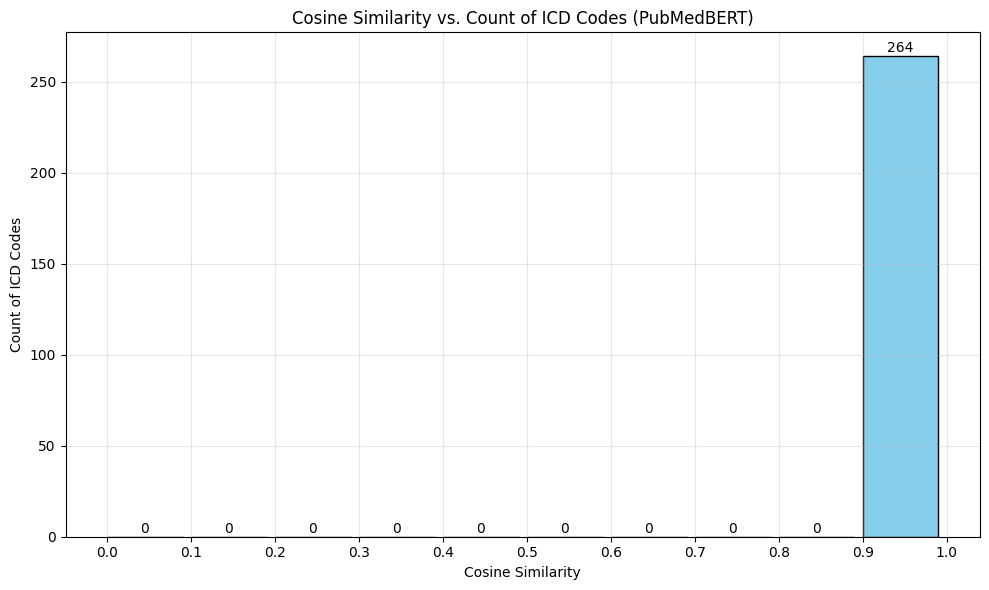

In [ ]:
#cell: Batch Cosine Similarity with PubMedBERT Embeddings and Multiple Rephrased Files
import csv
from collections import defaultdict
import numpy as np
from sentence_transformers import SentenceTransformer
import re
from collections import Counter
import math
import pandas as pd
import matplotlib.pyplot as plt

# File paths
original_file = '/content/icd_11_prompt_delimited.txt'  # Format: Disorder Name|Disorder Code|Disorder Symptoms
rephrased_files = [
    '/content/Prompt_1_updated.txt',
    '/content/Prompt_2_updated.txt',
    '/content/Prompt_3_updated.txt',
    '/content/Prompt_4_updated.txt',
    '/content/Prompt_5_updated.txt',
    '/content/Prompt_6_updated.txt',
    '/content/Prompt_7_updated.txt'
]
cleaned_rephrased_file = '/content/pubmedbert_cleaned_rephrased.txt'
output_file = '/content/pubmedbert_cosine_similarity_unique_sorted.csv'  # Sorted, unique output
unmatched_log = '/content/pubmedbert_unmatched_icd_codes.txt'
low_similarity_log = '/content/pubmedbert_low_similarity_pairs.csv'
malformed_log = '/content/pubmedbert_malformed_rephrased.txt'
original_codes_log = '/content/pubmedbert_original_codes.txt'
rephrased_codes_log = '/content/pubmedbert_rephrased_codes.txt'
output_plot = '/content/pubmedbert_similarity_vs_icd_count.png'

# Expanded typo/synonym correction dictionary for ICD terms
typo_corrections = {
    'behaviour': 'behavior',
    'behaviours': 'behaviors',
    'adaptative': 'adaptive',
    'intelectual': 'intellectual',
    'standerd': 'standard',
    'deviation': 'deviations',
    'cognitive': 'intellectual',  # Medical synonym
    'mental': 'intellectual',
    'adaptive behaviour': 'adaptive behavior',
    'belowaverage': 'below average',
    'standardised': 'standardized',
    'percentile': 'percentiles',
    'disability': 'disorder',
    'impairment': 'disorder',
    'deficit': 'disorder'
}

# Normalize ICD code: remove prefixes, uppercase, strip whitespace
def normalize_code(code):
    code = re.sub(r'^\s*Disorder Code:\s*', '', code, flags=re.IGNORECASE)
    code = re.sub(r'\s+', '', code)
    return code.upper()

# Preprocess text: lowercase, remove punctuation, correct typos/synonyms
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    for wrong, correct in typo_corrections.items():
        text = text.replace(wrong, correct)
    return text

# Clean multiple rephrased files: combine and remove empty lines/non-data entries
def clean_rephrased_files(input_files, output_file):
    valid_lines = []
    for input_file in input_files:
        try:
            with open(input_file, 'r', encoding='utf-8') as f:
                for line in f:
                    if line.strip() and '|' in line and len(line.split('|')) == 3:
                        valid_lines.append(line.strip())
        except FileNotFoundError:
            print(f"Warning: {input_file} not found, skipping.")
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write('\n'.join(valid_lines))
    print(f"Cleaned rephrased file saved to {output_file}. {len(valid_lines)} valid records.")
    return len(valid_lines)

# TF-IDF cosine similarity function (fallback)
def compute_tf_idf_cosine(original, rephrased):
    docs = [preprocess_text(original), preprocess_text(rephrased)]
    vocab = list(set(word for doc in docs for word in doc.split()))
    tf_docs = [[Counter(doc.split()).get(word, 0) / len(doc.split()) for word in vocab] for doc in docs]
    N = len(docs)
    idf = [math.log(N / (1 + sum(1 for doc in docs if word in doc))) for word in vocab]
    tfidf_docs = [[tf * idf_val for tf, idf_val in zip(tf_vector, idf)] for tf_vector in tf_docs]
    vec1, vec2 = np.array(tfidf_docs[0]), np.array(tfidf_docs[1])
    dot = np.dot(vec1, vec2)
    norm1, norm2 = np.linalg.norm(vec1), np.linalg.norm(vec2)
    return dot / (norm1 * norm2) if norm1 > 0 and norm2 > 0 else 0.0

# Clean rephrased files
clean_rephrased_files(rephrased_files, cleaned_rephrased_file)
rephrased_file = cleaned_rephrased_file

# Read original records
original_records = {}
original_codes = set()
with open(original_file, 'r', encoding='utf-8') as f:
    reader = csv.reader(f, delimiter='|')
    for row in reader:
        if len(row) == 3:
            name, code, symptoms = [field.strip() for field in row]
            code = normalize_code(code)
            original_records[code] = preprocess_text(symptoms)
            original_codes.add(code)
        else:
            print(f"Skipping malformed original record: {row}")

# Save original codes
with open(original_codes_log, 'w', encoding='utf-8') as f:
    for code in sorted(original_codes):
        f.write(f"{code}\n")
print(f"Saved {len(original_codes)} original ICD codes to {original_codes_log}")

# Read rephrased records
rephrased_groups = defaultdict(list)
rephrased_codes = set()
malformed_rephrased = []
with open(rephrased_file, 'r', encoding='utf-8') as f:
    reader = csv.reader(f, delimiter='|')
    for row in reader:
        if len(row) == 3:
            name, code, symptoms = [field.strip() for field in row]
            code = normalize_code(code)
            rephrased_groups[code].append(preprocess_text(symptoms))
            rephrased_codes.add(code)
        else:
            malformed_rephrased.append(row)
            print(f"Skipping malformed rephrased record: {row}")

# Save rephrased codes
with open(rephrased_codes_log, 'w', encoding='utf-8') as f:
    for code in sorted(rephrased_codes):
        f.write(f"{code}\n")
print(f"Saved {len(rephrased_codes)} rephrased ICD codes to {rephrased_codes_log}")

# Log malformed rephrased records
if malformed_rephrased:
    with open(malformed_log, 'w', encoding='utf-8') as f:
        for row in malformed_rephrased:
            f.write(f"{row}\n")
    print(f"Logged {len(malformed_rephrased)} malformed rephrased records to {malformed_log}")

# Initialize embedding method
try:
    embedding_function = SentenceTransformer('microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext')
    print("Using PubMedBERT embeddings")
    use_pubmedbert = True
except Exception as e:
    print(f"Error initializing PubMedBERT: {e}. Falling back to TF-IDF.")
    use_pubmedbert = False

# Compute cosine similarities with progress tracking and batching
results = []
low_similarity_pairs = []
total_pairs = sum(len(group) for group in rephrased_groups.values())
processed_pairs = 0
batch_size = 100  # Process rephrases in batches to manage memory

for code, original_symptoms in original_records.items():
    if code not in rephrased_groups:
        print(f"No rephrases found for ICD code {code}")
        continue

    # Embed original symptoms
    try:
        if use_pubmedbert:
            original_embedding = embedding_function.encode(original_symptoms)
            original_vector = np.array(original_embedding)
        else:
            original_vector = None
    except Exception as e:
        print(f"Error embedding original symptoms for {code}: {e}")
        continue

    # Embed and compare rephrased symptoms in batches
    for i in range(0, len(rephrased_groups[code]), batch_size):
        batch = rephrased_groups[code][i:i + batch_size]
        for rephrased_symptoms in batch:
            try:
                if use_pubmedbert:
                    rephrased_embedding = embedding_function.encode(rephrased_symptoms)
                    rephrased_vector = np.array(rephrased_embedding)
                    cosine_similarity = np.dot(original_vector, rephrased_vector) / (
                        np.linalg.norm(original_vector) * np.linalg.norm(rephrased_vector)
                    )
                else:
                    cosine_similarity = compute_tf_idf_cosine(original_symptoms, rephrased_symptoms)

                results.append([code, original_symptoms, rephrased_symptoms, cosine_similarity])
                if cosine_similarity < 0.9:
                    low_similarity_pairs.append([code, original_symptoms, rephrased_symptoms, f"{cosine_similarity:.4f}"])

                processed_pairs += 1
                if processed_pairs % 100 == 0:
                    print(f"Processed {processed_pairs}/{total_pairs} pairs ({processed_pairs/total_pairs*100:.2f}%)")
            except Exception as e:
                print(f"Error processing rephrase for {code}: {e}")

# Create DataFrame, sort by cosine similarity, and select unique records
if results:
    df = pd.DataFrame(results, columns=['ICD Code', 'Original Symptoms', 'Rephrased Symptoms', 'Cosine Similarity'])
    # Sort by Cosine Similarity in descending order
    df_sorted = df.sort_values(by='Cosine Similarity', ascending=False)
    # Select unique record with highest similarity per ICD Code
    df_unique = df_sorted.groupby('ICD Code').first().reset_index()
    # Save to CSV
    df_unique.to_csv(output_file, index=False)
    print(f"Sorted unique records saved to {output_file}")
else:
    print("No results computed. Check embedding errors or input data.")

# Save low similarity pairs
if low_similarity_pairs:
    with open(low_similarity_log, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['ICD Code', 'Original Symptoms', 'Rephrased Symptoms', 'Cosine Similarity'])
        writer.writerows(low_similarity_pairs)
    print(f"Logged {len(low_similarity_pairs)} pairs with similarity < 0.9 to {low_similarity_log}")

# Log unmatched ICD codes
unmatched_codes = [code for code in original_records if code not in rephrased_groups]
if unmatched_codes:
    with open(unmatched_log, 'w', encoding='utf-8') as f:
        for code in unmatched_codes:
            f.write(f"{code}\n")
    print(f"Logged {len(unmatched_codes)} unmatched ICD codes to {unmatched_log}")

# Validation summary
total_original = len(original_records)
total_rephrased = sum(len(group) for group in rephrased_groups.values())
matched_codes = len([code for code in original_records if code in rephrased_groups])
average_rephrases = total_rephrased / matched_codes if matched_codes > 0 else 0

# Compute average similarity per code
similarities_per_code = defaultdict(list)
for result in results:
    similarities_per_code[result[0]].append(float(result[3]))
average_similarities = {code: np.mean(sims) for code, sims in similarities_per_code.items()}

print("\nValidation Summary:")
print(f"Total original records: {total_original}")
print(f"Total rephrased records: {total_rephrased}")
print(f"Matched ICD codes: {matched_codes} ({matched_codes / total_original * 100:.2f}%)")
print(f"Average rephrases per matched code: {average_rephrases:.2f}")
print("\nAverage Cosine Similarity per ICD Code:")
for code, avg_sim in sorted(average_similarities.items()):
    print(f"ICD Code {code}: {avg_sim:.4f}")

# Overall average similarity
if results:
    overall_avg = np.mean([float(result[3]) for result in results])
    print(f"\nOverall Average Cosine Similarity: {overall_avg:.4f}")

# Validate sorted unique output
if results:
    df_unique = pd.read_csv(output_file)
    unique_codes = len(df_unique['ICD Code'].unique())
    print(f"\nUnique Output Validation:")
    print(f"Unique ICD codes in output: {unique_codes}")
    print(f"Sorted by Cosine Similarity (descending): {df_unique['Cosine Similarity'].is_monotonic_decreasing}")
    # Check specific codes
    check_codes = ['6A01.Y', '6A01.Z', '6A0Z', '6A20.Z', '6A21.Z', '6A23.Z']
    print("\nChecking specific codes in output:")
    for code in check_codes:
        if code in df_unique['ICD Code'].values:
            similarity = df_unique[df_unique['ICD Code'] == code]['Cosine Similarity'].iloc[0]
            print(f"{code} found with highest similarity: {similarity:.4f}")
        else:
            print(f"{code} not found in output")

# Generate graph: Cosine Similarity vs. Count of ICD Codes
if results:
    bins = np.arange(0.0, 1.1, 0.1)
    hist, bin_edges = np.histogram(df_unique['Cosine Similarity'], bins=bins)
    plt.figure(figsize=(10, 6))
    plt.bar(bin_edges[:-1], hist, width=0.09, align='edge', color='skyblue', edgecolor='black')
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Count of ICD Codes')
    plt.title('Cosine Similarity vs. Count of ICD Codes (PubMedBERT)')
    plt.xticks(bins)
    plt.grid(True, alpha=0.3)
    for i, count in enumerate(hist):
        plt.text(bin_edges[i] + 0.045, count + 0.5, f'{count}', ha='center', va='bottom')
    plt.tight_layout()
    plt.savefig(output_plot)
    print(f"Graph saved to {output_plot}")
    plt.show()

In [ ]:
#cell: Batch Cosine Similarity with PubMedBERT Embeddings with latest  /content/Qwen1.txt  records
import csv
from collections import defaultdict
import numpy as np
from sentence_transformers import SentenceTransformer
import re
from collections import Counter
import math
import pandas as pd

# File paths
original_file = '/content/icd_11_prompt_delimited.txt'  # Format: Disorder Name|Disorder Code|Disorder Symptoms
rephrased_file = '/content/Qwen1.txt'  # Same format, ~4358 records
cleaned_rephrased_file = '/content/pubmedbert_cleaned_rephrased.txt'
output_file = '/content/pubmedbert_cosine_similarity_unique_sorted.csv'  # Sorted, unique output
unmatched_log = '/content/pubmedbert_unmatched_icd_codes.txt'
low_similarity_log = '/content/pubmedbert_low_similarity_pairs.csv'
malformed_log = '/content/pubmedbert_malformed_rephrased.txt'
original_codes_log = '/content/pubmedbert_original_codes.txt'
rephrased_codes_log = '/content/pubmedbert_rephrased_codes.txt'

# Expanded typo/synonym correction dictionary for ICD terms
typo_corrections = {
    'behaviour': 'behavior',
    'behaviours': 'behaviors',
    'adaptative': 'adaptive',
    'intelectual': 'intellectual',
    'standerd': 'standard',
    'deviation': 'deviations',
    'cognitive': 'intellectual',  # Medical synonym
    'mental': 'intellectual',
    'adaptive behaviour': 'adaptive behavior',
    'belowaverage': 'below average',
    'standardised': 'standardized',
    'percentile': 'percentiles',
}

# Normalize ICD code: remove prefixes, uppercase, strip whitespace
def normalize_code(code):
    code = re.sub(r'^\s*Disorder Code:\s*', '', code, flags=re.IGNORECASE)
    code = re.sub(r'\s+', '', code)
    return code.upper()

# Preprocess text: lowercase, remove punctuation, correct typos/synonyms
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    for wrong, correct in typo_corrections.items():
        text = text.replace(wrong, correct)
    return text

# Clean rephrased file: remove empty lines and non-data entries
def clean_rephrased_file(input_file, output_file):
    valid_lines = []
    with open(input_file, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip() and '|' in line and len(line.split('|')) == 3:
                valid_lines.append(line.strip())
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write('\n'.join(valid_lines))
    print(f"Cleaned rephrased file saved to {output_file}. {len(valid_lines)} valid records.")

# TF-IDF cosine similarity function (fallback)
def compute_tf_idf_cosine(original, rephrased):
    docs = [preprocess_text(original), preprocess_text(rephrased)]
    vocab = list(set(word for doc in docs for word in doc.split()))
    tf_docs = [[Counter(doc.split()).get(word, 0) / len(doc.split()) for word in vocab] for doc in docs]
    N = len(docs)
    idf = [math.log(N / (1 + sum(1 for doc in docs if word in doc))) for word in vocab]
    tfidf_docs = [[tf * idf_val for tf, idf_val in zip(tf_vector, idf)] for tf_vector in tf_docs]
    vec1, vec2 = np.array(tfidf_docs[0]), np.array(tfidf_docs[1])
    dot = np.dot(vec1, vec2)
    norm1, norm2 = np.linalg.norm(vec1), np.linalg.norm(vec2)
    return dot / (norm1 * norm2) if norm1 > 0 and norm2 > 0 else 0.0

# Clean rephrased file
clean_rephrased_file(rephrased_file, cleaned_rephrased_file)
rephrased_file = cleaned_rephrased_file

# Read original records
original_records = {}
original_codes = set()
with open(original_file, 'r', encoding='utf-8') as f:
    reader = csv.reader(f, delimiter='|')
    for row in reader:
        if len(row) == 3:
            name, code, symptoms = [field.strip() for field in row]
            code = normalize_code(code)
            original_records[code] = preprocess_text(symptoms)
            original_codes.add(code)
        else:
            print(f"Skipping malformed original record: {row}")

# Save original codes
with open(original_codes_log, 'w', encoding='utf-8') as f:
    for code in sorted(original_codes):
        f.write(f"{code}\n")
print(f"Saved {len(original_codes)} original ICD codes to {original_codes_log}")

# Read rephrased records
rephrased_groups = defaultdict(list)
rephrased_codes = set()
malformed_rephrased = []
with open(rephrased_file, 'r', encoding='utf-8') as f:
    reader = csv.reader(f, delimiter='|')
    for row in reader:
        if len(row) == 3:
            name, code, symptoms = [field.strip() for field in row]
            code = normalize_code(code)
            rephrased_groups[code].append(preprocess_text(symptoms))
            rephrased_codes.add(code)
        else:
            malformed_rephrased.append(row)
            print(f"Skipping malformed rephrased record: {row}")

# Save rephrased codes
with open(rephrased_codes_log, 'w', encoding='utf-8') as f:
    for code in sorted(rephrased_codes):
        f.write(f"{code}\n")
print(f"Saved {len(rephrased_codes)} rephrased ICD codes to {rephrased_codes_log}")

# Log malformed rephrased records
if malformed_rephrased:
    with open(malformed_log, 'w', encoding='utf-8') as f:
        for row in malformed_rephrased:
            f.write(f"{row}\n")
    print(f"Logged {len(malformed_rephrased)} malformed rephrased records to {malformed_log}")

# Initialize embedding method
try:
    embedding_function = SentenceTransformer('microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext')
    print("Using PubMedBERT embeddings")
    use_pubmedbert = True
except Exception as e:
    print(f"Error initializing PubMedBERT: {e}. Falling back to TF-IDF.")
    use_pubmedbert = False

# Compute cosine similarities with progress tracking and batching
results = []
low_similarity_pairs = []
total_pairs = sum(len(group) for group in rephrased_groups.values())
processed_pairs = 0
batch_size = 100  # Process rephrases in batches to manage memory

for code, original_symptoms in original_records.items():
    if code not in rephrased_groups:
        print(f"No rephrases found for ICD code {code}")
        continue

    # Embed original symptoms
    try:
        if use_pubmedbert:
            original_embedding = embedding_function.encode(original_symptoms)
            original_vector = np.array(original_embedding)
        else:
            original_vector = None
    except Exception as e:
        print(f"Error embedding original symptoms for {code}: {e}")
        continue

    # Embed and compare rephrased symptoms in batches
    for i in range(0, len(rephrased_groups[code]), batch_size):
        batch = rephrased_groups[code][i:i + batch_size]
        for rephrased_symptoms in batch:
            try:
                if use_pubmedbert:
                    rephrased_embedding = embedding_function.encode(rephrased_symptoms)
                    rephrased_vector = np.array(rephrased_embedding)
                    cosine_similarity = np.dot(original_vector, rephrased_vector) / (
                        np.linalg.norm(original_vector) * np.linalg.norm(rephrased_vector)
                    )
                else:
                    cosine_similarity = compute_tf_idf_cosine(original_symptoms, rephrased_symptoms)

                results.append([code, original_symptoms, rephrased_symptoms, cosine_similarity])
                if cosine_similarity < 0.9:
                    low_similarity_pairs.append([code, original_symptoms, rephrased_symptoms, f"{cosine_similarity:.4f}"])

                processed_pairs += 1
                if processed_pairs % 100 == 0:
                    print(f"Processed {processed_pairs}/{total_pairs} pairs ({processed_pairs/total_pairs*100:.2f}%)")
            except Exception as e:
                print(f"Error processing rephrase for {code}: {e}")

# Create DataFrame, sort by cosine similarity, and select unique records
if results:
    df = pd.DataFrame(results, columns=['ICD Code', 'Original Symptoms', 'Rephrased Symptoms', 'Cosine Similarity'])
    # Sort by Cosine Similarity in descending order
    df_sorted = df.sort_values(by='Cosine Similarity', ascending=False)
    # Select unique record with highest similarity per ICD Code
    df_unique = df_sorted.groupby('ICD Code').first().reset_index()
    # Save to CSV
    df_unique.to_csv(output_file, index=False)
    print(f"Sorted unique records saved to {output_file}")
else:
    print("No results computed. Check embedding errors or input data.")

# Save low similarity pairs
if low_similarity_pairs:
    with open(low_similarity_log, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['ICD Code', 'Original Symptoms', 'Rephrased Symptoms', 'Cosine Similarity'])
        writer.writerows(low_similarity_pairs)
    print(f"Logged {len(low_similarity_pairs)} pairs with similarity < 0.9 to {low_similarity_log}")

# Log unmatched ICD codes
unmatched_codes = [code for code in original_records if code not in rephrased_groups]
if unmatched_codes:
    with open(unmatched_log, 'w', encoding='utf-8') as f:
        for code in unmatched_codes:
            f.write(f"{code}\n")
    print(f"Logged {len(unmatched_codes)} unmatched ICD codes to {unmatched_log}")

# Validation summary
total_original = len(original_records)
total_rephrased = sum(len(group) for group in rephrased_groups.values())
matched_codes = len([code for code in original_records if code in rephrased_groups])
average_rephrases = total_rephrased / matched_codes if matched_codes > 0 else 0

# Compute average similarity per code
similarities_per_code = defaultdict(list)
for result in results:
    similarities_per_code[result[0]].append(float(result[3]))
average_similarities = {code: np.mean(sims) for code, sims in similarities_per_code.items()}

print("\nValidation Summary:")
print(f"Total original records: {total_original}")
print(f"Total rephrased records: {total_rephrased}")
print(f"Matched ICD codes: {matched_codes} ({matched_codes / total_original * 100:.2f}%)")
print(f"Average rephrases per matched code: {average_rephrases:.2f}")
print("\nAverage Cosine Similarity per ICD Code:")
for code, avg_sim in sorted(average_similarities.items()):
    print(f"ICD Code {code}: {avg_sim:.4f}")

# Overall average similarity
if results:
    overall_avg = np.mean([float(result[3]) for result in results])
    print(f"\nOverall Average Cosine Similarity: {overall_avg:.4f}")

# Validate sorted unique output
if results:
    df_unique = pd.read_csv(output_file)
    unique_codes = len(df_unique['ICD Code'].unique())
    print(f"\nUnique Output Validation:")
    print(f"Unique ICD codes in output: {unique_codes}")
    print(f"Sorted by Cosine Similarity (descending): {df_unique['Cosine Similarity'].is_monotonic_decreasing}")
    # Check specific codes
    check_codes = ['6A01.Y', '6A01.Z', '6A0Z', '6A20.Z', '6A21.Z', '6A23.Z']
    print("\nChecking specific codes in output:")
    for code in check_codes:
        if code in df_unique['ICD Code'].values:
            similarity = df_unique[df_unique['ICD Code'] == code]['Cosine Similarity'].iloc[0]
            print(f"{code} found with highest similarity: {similarity:.4f}")
        else:
            print(f"{code} not found in output")

Cleaned rephrased file saved to /content/pubmedbert_cleaned_rephrased.txt. 367 valid records.
Saved 368 original ICD codes to /content/pubmedbert_original_codes.txt
Saved 367 rephrased ICD codes to /content/pubmedbert_rephrased_codes.txt


Using PubMedBERT embeddings
Processed 100/367 pairs (27.25%)
Processed 200/367 pairs (54.50%)
Processed 300/367 pairs (81.74%)
No rephrases found for ICD code 6E62.3
Sorted unique records saved to /content/pubmedbert_cosine_similarity_unique_sorted.csv
Logged 1 unmatched ICD codes to /content/pubmedbert_unmatched_icd_codes.txt

Validation Summary:
Total original records: 368
Total rephrased records: 367
Matched ICD codes: 367 (99.73%)
Average rephrases per matched code: 1.00

Average Cosine Similarity per ICD Code:
ICD Code 6A00.0: 0.9925
ICD Code 6A00.1: 0.9917
ICD Code 6A00.2: 0.9930
ICD Code 6A00.3: 0.9938
ICD Code 6A00.4: 0.9910
ICD Code 6A01.0: 0.9972
ICD Code 6A01.1: 0.9973
ICD Code 6A01.Y: 0.9949
ICD Code 6A01.Z: 0.9947
ICD Code 6A02.0: 0.9918
ICD Code 6A02.1: 0.9890
ICD Code 6A02.2: 0.9903
ICD Code 6A02.3: 0.9906
ICD Code 6A02.5: 0.9953
ICD Code 6A03.0: 0.9949
ICD Code 6A03.1: 0.9945
ICD Code 6A03.2: 0.9956
ICD Code 6A03.3: 0.9943
ICD Code 6A04: 0.9950
ICD Code 6A05.0: 0.9940
I

In [ ]:
#cell: Batch Cosine Similarity with Enhanced Code Normalization using MedLlama2
import csv
from collections import defaultdict
import numpy as np
from langchain_ollama import OllamaEmbeddings
import requests
import time
import re
from collections import Counter
import math
import pandas as pd
import subprocess

# File paths - replace with your actual paths (e.g., upload to Colab)
original_file = '/content/icd_11_prompt_delimited.txt'  # Format: Disorder Name|Disorder Code|Disorder Symptoms
rephrased_file = '/content/10_records_per_icd.txt'  # Same format, ~4358 records
cleaned_rephrased_file = '/content/cleaned_rephrased.txt'
output_file = '/content/cosine_similarity_results.csv'
unmatched_log = '/content/unmatched_icd_codes.txt'
low_similarity_log = '/content/low_similarity_pairs.csv'
malformed_log = '/content/malformed_rephrased.txt'
original_codes_log = '/content/original_codes.txt'
rephrased_codes_log = '/content/rephrased_codes.txt'

# Simple typo correction dictionary for ICD terms (expand as needed)
typo_corrections = {
    'behaviour': 'behavior',
    'behaviours': 'behaviors',
    'adaptative': 'adaptive',
    'intelectual': 'intellectual',
    'standerd': 'standard',
    'deviation': 'deviations',
}

# Normalize ICD code: remove prefixes, uppercase, strip all whitespace
def normalize_code(code):
    code = re.sub(r'^\s*Disorder Code:\s*', '', code, flags=re.IGNORECASE)  # Remove "Disorder Code:" prefix
    code = re.sub(r'\s+', '', code)  # Remove all whitespace (spaces, tabs, etc.)
    return code.upper()  # Convert to uppercase for consistency

# Preprocess text: lowercase, remove punctuation, correct common typos
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    for wrong, correct in typo_corrections.items():
        text = text.replace(wrong, correct)
    return text

# Clean rephrased file: remove empty lines and non-data entries
def clean_rephrased_file(input_file, output_file):
    valid_lines = []
    with open(input_file, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip() and '|' in line and len(line.split('|')) == 3:
                valid_lines.append(line.strip())
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write('\n'.join(valid_lines))
    print(f"Cleaned rephrased file saved to {output_file}. {len(valid_lines)} valid records.")

# TF-IDF cosine similarity function
def compute_tf_idf_cosine(original, rephrased):
    docs = [preprocess_text(original), preprocess_text(rephrased)]
    vocab = list(set(word for doc in docs for word in doc.split()))
    tf_docs = [[Counter(doc.split()).get(word, 0) / len(doc.split()) for word in vocab] for doc in docs]
    N = len(docs)
    idf = [math.log(N / (1 + sum(1 for doc in docs if word in doc))) for word in vocab]
    tfidf_docs = [[tf * idf_val for tf, idf_val in zip(tf_vector, idf)] for tf_vector in tf_docs]
    vec1, vec2 = np.array(tfidf_docs[0]), np.array(tfidf_docs[1])
    dot = np.dot(vec1, vec2)
    norm1, norm2 = np.linalg.norm(vec1), np.linalg.norm(vec2)
    return dot / (norm1 * norm2) if norm1 > 0 and norm2 > 0 else 0.0

# Check Ollama server connectivity
def check_ollama_server():
    try:
        response = requests.get("http://127.0.0.1:11434")
        return response.status_code == 200
    except requests.ConnectionError:
        return False

# Start Ollama server
def start_ollama_server():
    try:
        subprocess.Popen(["ollama", "serve"], stdout=open("ollama.log", "w"), stderr=subprocess.STDOUT)
        print("Starting Ollama server...")
        time.sleep(20)
        if check_ollama_server():
            print("Ollama server is running at 127.0.0.1:11434")
            return True
        else:
            print("Failed to start Ollama server. Check ollama.log for details.")
            subprocess.run(["cat", "ollama.log"])
            return False
    except Exception as e:
        print(f"Error starting Ollama server: {e}")
        return False

# Clean rephrased file
clean_rephrased_file(rephrased_file, cleaned_rephrased_file)
rephrased_file = cleaned_rephrased_file

# Read original records
original_records = {}
original_codes = set()
with open(original_file, 'r', encoding='utf-8') as f:
    reader = csv.reader(f, delimiter='|')
    for row in reader:
        if len(row) == 3:
            name, code, symptoms = [field.strip() for field in row]
            code = normalize_code(code)  # Normalize code
            original_records[code] = preprocess_text(symptoms)
            original_codes.add(code)
        else:
            print(f"Skipping malformed original record: {row}")

# Save original codes for debugging
with open(original_codes_log, 'w', encoding='utf-8') as f:
    for code in sorted(original_codes):
        f.write(f"{code}\n")
print(f"Saved {len(original_codes)} original ICD codes to {original_codes_log}")

# Read rephrased records, group by code
rephrased_groups = defaultdict(list)
rephrased_codes = set()
malformed_rephrased = []
with open(rephrased_file, 'r', encoding='utf-8') as f:
    reader = csv.reader(f, delimiter='|')
    for row in reader:
        if len(row) == 3:
            name, code, symptoms = [field.strip() for field in row]
            code = normalize_code(code)  # Normalize code
            rephrased_groups[code].append(preprocess_text(symptoms))
            rephrased_codes.add(code)
        else:
            malformed_rephrased.append(row)
            print(f"Skipping malformed rephrased record: {row}")

# Save rephrased codes for debugging
with open(rephrased_codes_log, 'w', encoding='utf-8') as f:
    for code in sorted(rephrased_codes):
        f.write(f"{code}\n")
print(f"Saved {len(rephrased_codes)} rephrased ICD codes to {rephrased_codes_log}")

# Log malformed rephrased records
if malformed_rephrased:
    with open(malformed_log, 'w', encoding='utf-8') as f:
        for row in malformed_rephrased:
            f.write(f"{row}\n")
    print(f"Logged {len(malformed_rephrased)} malformed rephrased records to {malformed_log}")

# Initialize embedding method
use_ollama = check_ollama_server() or start_ollama_server()
if use_ollama:
    try:
        embedding_function = OllamaEmbeddings(model="MedLlama2")
        print("Using Ollama embeddings (MedLlama2)")
    except Exception as e:
        print(f"Error initializing Ollama embeddings: {e}. Falling back to TF-IDF.")
        use_ollama = False
else:
    print("Ollama server not available. Falling back to TF-IDF.")
    use_ollama = False

# Compute cosine similarities and save to CSV
results = []
low_similarity_pairs = []
for code, original_symptoms in original_records.items():
    if code not in rephrased_groups:
        print(f"No rephrases found for ICD code {code}")
        continue

    # Embed original symptoms
    try:
        if use_ollama:
            original_embedding = embedding_function.embed_query(original_symptoms)
            original_vector = np.array(original_embedding)
        else:
            original_vector = None
    except Exception as e:
        print(f"Error embedding original symptoms for {code}: {e}")
        continue

    # Embed and compare each rephrased symptom
    for rephrased_symptoms in rephrased_groups[code]:
        try:
            if use_ollama:
                rephrased_embedding = embedding_function.embed_query(rephrased_symptoms)
                rephrased_vector = np.array(rephrased_embedding)
                cosine_similarity = np.dot(original_vector, rephrased_vector) / (
                    np.linalg.norm(original_vector) * np.linalg.norm(rephrased_vector)
                )
            else:
                cosine_similarity = compute_tf_idf_cosine(original_symptoms, rephrased_symptoms)

            results.append([code, original_symptoms, rephrased_symptoms, f"{cosine_similarity:.4f}"])
            if cosine_similarity < 0.9:
                low_similarity_pairs.append([code, original_symptoms, rephrased_symptoms, f"{cosine_similarity:.4f}"])
        except Exception as e:
            print(f"Error processing rephrase for {code}: {e}")

# Save results to CSV
with open(output_file, 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['ICD Code', 'Original Symptoms', 'Rephrased Symptoms', 'Cosine Similarity'])
    writer.writerows(results)
print(f"Cosine similarity results saved to {output_file}")

# Save low similarity pairs
if low_similarity_pairs:
    with open(low_similarity_log, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['ICD Code', 'Original Symptoms', 'Rephrased Symptoms', 'Cosine Similarity'])
        writer.writerows(low_similarity_pairs)
    print(f"Logged {len(low_similarity_pairs)} pairs with similarity < 0.9 to {low_similarity_log}")

# Log unmatched ICD codes
unmatched_codes = [code for code in original_records if code not in rephrased_groups]
if unmatched_codes:
    with open(unmatched_log, 'w', encoding='utf-8') as f:
        for code in unmatched_codes:
            f.write(f"{code}\n")
    print(f"Logged {len(unmatched_codes)} unmatched ICD codes to {unmatched_log}")

# Validation summary
total_original = len(original_records)
total_rephrased = sum(len(group) for group in rephrased_groups.values())
matched_codes = len([code for code in original_records if code in rephrased_groups])
average_rephrases = total_rephrased / matched_codes if matched_codes > 0 else 0

# Compute average similarity per code
similarities_per_code = defaultdict(list)
for result in results:
    similarities_per_code[result[0]].append(float(result[3]))
average_similarities = {code: np.mean(sims) for code, sims in similarities_per_code.items()}

print("\nValidation Summary:")
print(f"Total original records: {total_original}")
print(f"Total rephrased records: {total_rephrased}")
print(f"Matched ICD codes: {matched_codes} ({matched_codes / total_original * 100:.2f}%)")
print(f"Average rephrases per matched code: {average_rephrases:.2f}")
print("\nAverage Cosine Similarity per ICD Code:")
for code, avg_sim in sorted(average_similarities.items()):
    print(f"ICD Code {code}: {avg_sim:.4f}")

# Overall average similarity
if results:
    overall_avg = np.mean([float(result[3]) for result in results])
    print(f"\nOverall Average Cosine Similarity: {overall_avg:.4f}")

Cleaned rephrased file saved to /content/cleaned_rephrased.txt. 4358 valid records.
Saved 368 original ICD codes to /content/original_codes.txt
Saved 369 rephrased ICD codes to /content/rephrased_codes.txt
Starting Ollama server...
Ollama server is running at 127.0.0.1:11434
Using Ollama embeddings (MedLlama2)
Cosine similarity results saved to /content/cosine_similarity_results.csv
Logged 4280 pairs with similarity < 0.9 to /content/low_similarity_pairs.csv

Validation Summary:
Total original records: 368
Total rephrased records: 4358
Matched ICD codes: 368 (100.00%)
Average rephrases per matched code: 11.84

Average Cosine Similarity per ICD Code:
ICD Code 6A00.0: 0.6600
ICD Code 6A00.1: 0.6753
ICD Code 6A00.2: 0.6989
ICD Code 6A00.3: 0.4756
ICD Code 6A00.4: 0.6211
ICD Code 6A01.0: 0.5274
ICD Code 6A01.1: 0.6270
ICD Code 6A01.Y: 0.6297
ICD Code 6A01.Z: 0.6543
ICD Code 6A02.0: 0.6166
ICD Code 6A02.1: 0.7396
ICD Code 6A02.2: 0.2446
ICD Code 6A02.3: 0.7279
ICD Code 6A02.5: 0.5604
ICD Co

In [ ]:

#cell: Batch Cosine Similarity with Gemma 2 9B Embeddings
import csv
from collections import defaultdict
import numpy as np
from langchain_ollama import OllamaEmbeddings
import requests
import time
import re
from collections import Counter
import math
import pandas as pd
import subprocess

# File paths
original_file = '/content/icd_11_prompt_delimited.txt'  # Format: Disorder Name|Disorder Code|Disorder Symptoms
rephrased_file = '/content/10_records_per_icd.txt'  # Same format, ~4358 records
cleaned_rephrased_file = '/content/gemma_cleaned_rephrased.txt'
output_file = '/content/gemma_cosine_similarity_results.csv'
unmatched_log = '/content/gemma_unmatched_icd_codes.txt'
low_similarity_log = '/content/gemma_low_similarity_pairs.csv'
malformed_log = '/content/gemma_malformed_rephrased.txt'
original_codes_log = '/content/gemma_original_codes.txt'
rephrased_codes_log = '/content/gemma_rephrased_codes.txt'

# Typo correction dictionary for ICD terms
typo_corrections = {
    'behaviour': 'behavior',
    'behaviours': 'behaviors',
    'adaptative': 'adaptive',
    'intelectual': 'intellectual',
    'standerd': 'standard',
    'deviation': 'deviations',
}

# Normalize ICD code: remove prefixes, uppercase, strip whitespace
def normalize_code(code):
    code = re.sub(r'^\s*Disorder Code:\s*', '', code, flags=re.IGNORECASE)
    code = re.sub(r'\s+', '', code)
    return code.upper()

# Preprocess text: lowercase, remove punctuation, correct typos
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    for wrong, correct in typo_corrections.items():
        text = text.replace(wrong, correct)
    return text

# Clean rephrased file: remove empty lines and non-data entries
def clean_rephrased_file(input_file, output_file):
    valid_lines = []
    with open(input_file, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip() and '|' in line and len(line.split('|')) == 3:
                valid_lines.append(line.strip())
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write('\n'.join(valid_lines))
    print(f"Cleaned rephrased file saved to {output_file}. {len(valid_lines)} valid records.")

# TF-IDF cosine similarity function
def compute_tf_idf_cosine(original, rephrased):
    docs = [preprocess_text(original), preprocess_text(rephrased)]
    vocab = list(set(word for doc in docs for word in doc.split()))
    tf_docs = [[Counter(doc.split()).get(word, 0) / len(doc.split()) for word in vocab] for doc in docs]
    N = len(docs)
    idf = [math.log(N / (1 + sum(1 for doc in docs if word in doc))) for word in vocab]
    tfidf_docs = [[tf * idf_val for tf, idf_val in zip(tf_vector, idf)] for tf_vector in tf_docs]
    vec1, vec2 = np.array(tfidf_docs[0]), np.array(tfidf_docs[1])
    dot = np.dot(vec1, vec2)
    norm1, norm2 = np.linalg.norm(vec1), np.linalg.norm(vec2)
    return dot / (norm1 * norm2) if norm1 > 0 and norm2 > 0 else 0.0

# Check Ollama server connectivity
def check_ollama_server():
    try:
        response = requests.get("http://127.0.0.1:11434")
        return response.status_code == 200
    except requests.ConnectionError:
        return False

# Start Ollama server
def start_ollama_server():
    try:
        subprocess.Popen(["ollama", "serve"], stdout=open("ollama.log", "w"), stderr=subprocess.STDOUT)
        print("Starting Ollama server...")
        time.sleep(20)
        if check_ollama_server():
            print("Ollama server is running at 127.0.0.1:11434")
            return True
        else:
            print("Failed to start Ollama server. Check ollama.log for details.")
            subprocess.run(["cat", "ollama.log"])
            return False
    except Exception as e:
        print(f"Error starting Ollama server: {e}")
        return False

# Pull Gemma 2 9B model
def pull_gemma_model():
    try:
        print("Pulling gemma2:9b model...")
        subprocess.run(["ollama", "pull", "gemma2:9b"], check=True)
        print("Successfully pulled gemma2:9b model")
    except subprocess.CalledProcessError as e:
        print(f"Error pulling gemma2:9b model: {e}")
        return False
    return True

# Clean rephrased file
clean_rephrased_file(rephrased_file, cleaned_rephrased_file)
rephrased_file = cleaned_rephrased_file

# Read original records
original_records = {}
original_codes = set()
with open(original_file, 'r', encoding='utf-8') as f:
    reader = csv.reader(f, delimiter='|')
    for row in reader:
        if len(row) == 3:
            name, code, symptoms = [field.strip() for field in row]
            code = normalize_code(code)
            original_records[code] = preprocess_text(symptoms)
            original_codes.add(code)
        else:
            print(f"Skipping malformed original record: {row}")

# Save original codes
with open(original_codes_log, 'w', encoding='utf-8') as f:
    for code in sorted(original_codes):
        f.write(f"{code}\n")
print(f"Saved {len(original_codes)} original ICD codes to {original_codes_log}")

# Read rephrased records
rephrased_groups = defaultdict(list)
rephrased_codes = set()
malformed_rephrased = []
with open(rephrased_file, 'r', encoding='utf-8') as f:
    reader = csv.reader(f, delimiter='|')
    for row in reader:
        if len(row) == 3:
            name, code, symptoms = [field.strip() for field in row]
            code = normalize_code(code)
            rephrased_groups[code].append(preprocess_text(symptoms))
            rephrased_codes.add(code)
        else:
            malformed_rephrased.append(row)
            print(f"Skipping malformed rephrased record: {row}")

# Save rephrased codes
with open(rephrased_codes_log, 'w', encoding='utf-8') as f:
    for code in sorted(rephrased_codes):
        f.write(f"{code}\n")
print(f"Saved {len(rephrased_codes)} rephrased ICD codes to {rephrased_codes_log}")

# Log malformed rephrased records
if malformed_rephrased:
    with open(malformed_log, 'w', encoding='utf-8') as f:
        for row in malformed_rephrased:
            f.write(f"{row}\n")
    print(f"Logged {len(malformed_rephrased)} malformed rephrased records to {malformed_log}")

# Initialize embedding method
use_ollama = check_ollama_server() or start_ollama_server()
if use_ollama:
    # Attempt to pull gemma2:9b
    if not pull_gemma_model():
        print("Failed to pull gemma2:9b. Falling back to TF-IDF.")
        use_ollama = False
    else:
        try:
            embedding_function = OllamaEmbeddings(model="gemma2:9b")
            print("Using Gemma 2 9B embeddings")
        except Exception as e:
            print(f"Error initializing Gemma 2 9B embeddings: {e}. Falling back to TF-IDF.")
            use_ollama = False
else:
    print("Ollama server not available. Falling back to TF-IDF.")
    use_ollama = False

# Compute cosine similarities with progress tracking and batching
results = []
low_similarity_pairs = []
total_pairs = sum(len(group) for group in rephrased_groups.values())
processed_pairs = 0
batch_size = 100  # Process rephrases in batches to manage memory

for code, original_symptoms in original_records.items():
    if code not in rephrased_groups:
        print(f"No rephrases found for ICD code {code}")
        continue

    # Embed original symptoms
    try:
        if use_ollama:
            original_embedding = embedding_function.embed_query(original_symptoms)
            original_vector = np.array(original_embedding)
        else:
            original_vector = None
    except Exception as e:
        print(f"Error embedding original symptoms for {code}: {e}")
        continue

    # Embed and compare rephrased symptoms in batches
    for i in range(0, len(rephrased_groups[code]), batch_size):
        batch = rephrased_groups[code][i:i + batch_size]
        for rephrased_symptoms in batch:
            try:
                if use_ollama:
                    rephrased_embedding = embedding_function.embed_query(rephrased_symptoms)
                    rephrased_vector = np.array(rephrased_embedding)
                    cosine_similarity = np.dot(original_vector, rephrased_vector) / (
                        np.linalg.norm(original_vector) * np.linalg.norm(rephrased_vector)
                    )
                else:
                    cosine_similarity = compute_tf_idf_cosine(original_symptoms, rephrased_symptoms)

                results.append([code, original_symptoms, rephrased_symptoms, f"{cosine_similarity:.4f}"])
                if cosine_similarity < 0.9:
                    low_similarity_pairs.append([code, original_symptoms, rephrased_symptoms, f"{cosine_similarity:.4f}"])

                processed_pairs += 1
                if processed_pairs % 100 == 0:
                    print(f"Processed {processed_pairs}/{total_pairs} pairs ({processed_pairs/total_pairs*100:.2f}%)")
            except Exception as e:
                print(f"Error processing rephrase for {code}: {e}")

# Save results to CSV
with open(output_file, 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['ICD Code', 'Original Symptoms', 'Rephrased Symptoms', 'Cosine Similarity'])
    writer.writerows(results)
print(f"Cosine similarity results saved to {output_file}")

# Save low similarity pairs
if low_similarity_pairs:
    with open(low_similarity_log, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['ICD Code', 'Original Symptoms', 'Rephrased Symptoms', 'Cosine Similarity'])
        writer.writerows(low_similarity_pairs)
    print(f"Logged {len(low_similarity_pairs)} pairs with similarity < 0.9 to {low_similarity_log}")

# Log unmatched ICD codes
unmatched_codes = [code for code in original_records if code not in rephrased_groups]
if unmatched_codes:
    with open(unmatched_log, 'w', encoding='utf-8') as f:
        for code in unmatched_codes:
            f.write(f"{code}\n")
    print(f"Logged {len(unmatched_codes)} unmatched ICD codes to {unmatched_log}")

# Validation summary
total_original = len(original_records)
total_rephrased = sum(len(group) for group in rephrased_groups.values())
matched_codes = len([code for code in original_records if code in rephrased_groups])
average_rephrases = total_rephrased / matched_codes if matched_codes > 0 else 0

# Compute average similarity per code
similarities_per_code = defaultdict(list)
for result in results:
    similarities_per_code[result[0]].append(float(result[3]))
average_similarities = {code: np.mean(sims) for code, sims in similarities_per_code.items()}

print("\nValidation Summary:")
print(f"Total original records: {total_original}")
print(f"Total rephrased records: {total_rephrased}")
print(f"Matched ICD codes: {matched_codes} ({matched_codes / total_original * 100:.2f}%)")
print(f"Average rephrases per matched code: {average_rephrases:.2f}")
print("\nAverage Cosine Similarity per ICD Code:")
for code, avg_sim in sorted(average_similarities.items()):
    print(f"ICD Code {code}: {avg_sim:.4f}")

# Overall average similarity
if results:
    overall_avg = np.mean([float(result[3]) for result in results])
    print(f"\nOverall Average Cosine Similarity: {overall_avg:.4f}")

# Check specific codes
check_codes = ['6A01.Y', '6A01.Z', '6A0Z', '6A20.Z', '6A21.Z', '6A23.Z']
print("\nChecking specific codes:")
for code in check_codes:
    if code in rephrased_groups:
        print(f"{code} found with {len(rephrased_groups[code])} rephrases")
    else:
        print(f"{code} not found in rephrased records")

Cleaned rephrased file saved to /content/gemma_cleaned_rephrased.txt. 4358 valid records.
Saved 368 original ICD codes to /content/gemma_original_codes.txt
Saved 369 rephrased ICD codes to /content/gemma_rephrased_codes.txt
Pulling gemma2:9b model...
Successfully pulled gemma2:9b model
Using Gemma 2 9B embeddings
Processed 100/4358 pairs (2.29%)
Processed 200/4358 pairs (4.59%)
Processed 300/4358 pairs (6.88%)
Processed 400/4358 pairs (9.18%)
Processed 500/4358 pairs (11.47%)
Processed 600/4358 pairs (13.77%)
Processed 700/4358 pairs (16.06%)
Processed 800/4358 pairs (18.36%)
Processed 900/4358 pairs (20.65%)
Processed 1000/4358 pairs (22.95%)
Processed 1100/4358 pairs (25.24%)
Processed 1200/4358 pairs (27.54%)
Processed 1300/4358 pairs (29.83%)
Processed 1400/4358 pairs (32.12%)
Processed 1500/4358 pairs (34.42%)
Processed 1600/4358 pairs (36.71%)
Processed 1700/4358 pairs (39.01%)
Processed 1800/4358 pairs (41.30%)
Processed 1900/4358 pairs (43.60%)
Processed 2000/4358 pairs (45.89%

In [ ]:
#cell: Batch Cosine Similarity with Gemma 2 9B Embeddings, Sorting, and Unique Records
import csv
from collections import defaultdict
import numpy as np
from langchain_ollama import OllamaEmbeddings
import requests
import time
import re
from collections import Counter
import math
import pandas as pd
import subprocess

# File paths
original_file = '/content/icd_11_prompt_delimited.txt'  # Format: Disorder Name|Disorder Code|Disorder Symptoms
rephrased_file = '/content/10_records_per_icd.txt'  # Same format, ~4358 records
cleaned_rephrased_file = '/content/gemma_cleaned_rephrased.txt'
output_file = '/content/gemma_cosine_similarity_unique_sorted.csv'  # Sorted, unique output
unmatched_log = '/content/gemma_unmatched_icd_codes.txt'
low_similarity_log = '/content/gemma_low_similarity_pairs.csv'
malformed_log = '/content/gemma_malformed_rephrased.txt'
original_codes_log = '/content/gemma_original_codes.txt'
rephrased_codes_log = '/content/gemma_rephrased_codes.txt'

# Typo correction dictionary for ICD terms
typo_corrections = {
    'behaviour': 'behavior',
    'behaviours': 'behaviors',
    'adaptative': 'adaptive',
    'intelectual': 'intellectual',
    'standerd': 'standard',
    'deviation': 'deviations',
}

# Normalize ICD code: remove prefixes, uppercase, strip whitespace
def normalize_code(code):
    code = re.sub(r'^\s*Disorder Code:\s*', '', code, flags=re.IGNORECASE)
    code = re.sub(r'\s+', '', code)
    return code.upper()

# Preprocess text: lowercase, remove punctuation, correct typos
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    for wrong, correct in typo_corrections.items():
        text = text.replace(wrong, correct)
    return text

# Clean rephrased file: remove empty lines and non-data entries
def clean_rephrased_file(input_file, output_file):
    valid_lines = []
    with open(input_file, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip() and '|' in line and len(line.split('|')) == 3:
                valid_lines.append(line.strip())
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write('\n'.join(valid_lines))
    print(f"Cleaned rephrased file saved to {output_file}. {len(valid_lines)} valid records.")

# TF-IDF cosine similarity function
def compute_tf_idf_cosine(original, rephrased):
    docs = [preprocess_text(original), preprocess_text(rephrased)]
    vocab = list(set(word for doc in docs for word in doc.split()))
    tf_docs = [[Counter(doc.split()).get(word, 0) / len(doc.split()) for word in vocab] for doc in docs]
    N = len(docs)
    idf = [math.log(N / (1 + sum(1 for doc in docs if word in doc))) for word in vocab]
    tfidf_docs = [[tf * idf_val for tf, idf_val in zip(tf_vector, idf)] for tf_vector in tf_docs]
    vec1, vec2 = np.array(tfidf_docs[0]), np.array(tfidf_docs[1])
    dot = np.dot(vec1, vec2)
    norm1, norm2 = np.linalg.norm(vec1), np.linalg.norm(vec2)
    return dot / (norm1 * norm2) if norm1 > 0 and norm2 > 0 else 0.0

# Check Ollama server connectivity
def check_ollama_server():
    try:
        response = requests.get("http://127.0.0.1:11434")
        return response.status_code == 200
    except requests.ConnectionError:
        return False

# Start Ollama server
def start_ollama_server():
    try:
        subprocess.Popen(["ollama", "serve"], stdout=open("ollama.log", "w"), stderr=subprocess.STDOUT)
        print("Starting Ollama server...")
        time.sleep(20)
        if check_ollama_server():
            print("Ollama server is running at 127.0.0.1:11434")
            return True
        else:
            print("Failed to start Ollama server. Check ollama.log for details.")
            subprocess.run(["cat", "ollama.log"])
            return False
    except Exception as e:
        print(f"Error starting Ollama server: {e}")
        return False

# Pull Gemma 2 9B model
def pull_gemma_model():
    try:
        print("Pulling gemma2:9b model...")
        subprocess.run(["ollama", "pull", "gemma2:9b"], check=True)
        print("Successfully pulled gemma2:9b model")
    except subprocess.CalledProcessError as e:
        print(f"Error pulling gemma2:9b model: {e}")
        return False
    return True

# Clean rephrased file
clean_rephrased_file(rephrased_file, cleaned_rephrased_file)
rephrased_file = cleaned_rephrased_file

# Read original records
original_records = {}
original_codes = set()
with open(original_file, 'r', encoding='utf-8') as f:
    reader = csv.reader(f, delimiter='|')
    for row in reader:
        if len(row) == 3:
            name, code, symptoms = [field.strip() for field in row]
            code = normalize_code(code)
            original_records[code] = preprocess_text(symptoms)
            original_codes.add(code)
        else:
            print(f"Skipping malformed original record: {row}")

# Save original codes
with open(original_codes_log, 'w', encoding='utf-8') as f:
    for code in sorted(original_codes):
        f.write(f"{code}\n")
print(f"Saved {len(original_codes)} original ICD codes to {original_codes_log}")

# Read rephrased records
rephrased_groups = defaultdict(list)
rephrased_codes = set()
malformed_rephrased = []
with open(rephrased_file, 'r', encoding='utf-8') as f:
    reader = csv.reader(f, delimiter='|')
    for row in reader:
        if len(row) == 3:
            name, code, symptoms = [field.strip() for field in row]
            code = normalize_code(code)
            rephrased_groups[code].append(preprocess_text(symptoms))
            rephrased_codes.add(code)
        else:
            malformed_rephrased.append(row)
            print(f"Skipping malformed rephrased record: {row}")

# Save rephrased codes
with open(rephrased_codes_log, 'w', encoding='utf-8') as f:
    for code in sorted(rephrased_codes):
        f.write(f"{code}\n")
print(f"Saved {len(rephrased_codes)} rephrased ICD codes to {rephrased_codes_log}")

# Log malformed rephrased records
if malformed_rephrased:
    with open(malformed_log, 'w', encoding='utf-8') as f:
        for row in malformed_rephrased:
            f.write(f"{row}\n")
    print(f"Logged {len(malformed_rephrased)} malformed rephrased records to {malformed_log}")

# Initialize embedding method
use_ollama = check_ollama_server() or start_ollama_server()
if use_ollama:
    # Attempt to pull gemma2:9b
    if not pull_gemma_model():
        print("Failed to pull gemma2:9b. Falling back to TF-IDF.")
        use_ollama = False
    else:
        try:
            embedding_function = OllamaEmbeddings(model="gemma2:9b")
            print("Using Gemma 2 9B embeddings")
        except Exception as e:
            print(f"Error initializing Gemma 2 9B embeddings: {e}. Falling back to TF-IDF.")
            use_ollama = False
else:
    print("Ollama server not available. Falling back to TF-IDF.")
    use_ollama = False

# Compute cosine similarities with progress tracking and batching
results = []
low_similarity_pairs = []
total_pairs = sum(len(group) for group in rephrased_groups.values())
processed_pairs = 0
batch_size = 100  # Process rephrases in batches

for code, original_symptoms in original_records.items():
    if code not in rephrased_groups:
        print(f"No rephrases found for ICD code {code}")
        continue

    # Embed original symptoms
    try:
        if use_ollama:
            original_embedding = embedding_function.embed_query(original_symptoms)
            original_vector = np.array(original_embedding)
        else:
            original_vector = None
    except Exception as e:
        print(f"Error embedding original symptoms for {code}: {e}")
        continue

    # Embed and compare rephrased symptoms in batches
    for i in range(0, len(rephrased_groups[code]), batch_size):
        batch = rephrased_groups[code][i:i + batch_size]
        for rephrased_symptoms in batch:
            try:
                if use_ollama:
                    rephrased_embedding = embedding_function.embed_query(rephrased_symptoms)
                    rephrased_vector = np.array(rephrased_embedding)
                    cosine_similarity = np.dot(original_vector, rephrased_vector) / (
                        np.linalg.norm(original_vector) * np.linalg.norm(rephrased_vector)
                    )
                else:
                    cosine_similarity = compute_tf_idf_cosine(original_symptoms, rephrased_symptoms)

                results.append([code, original_symptoms, rephrased_symptoms, cosine_similarity])
                if cosine_similarity < 0.9:
                    low_similarity_pairs.append([code, original_symptoms, rephrased_symptoms, f"{cosine_similarity:.4f}"])

                processed_pairs += 1
                if processed_pairs % 100 == 0:
                    print(f"Processed {processed_pairs}/{total_pairs} pairs ({processed_pairs/total_pairs*100:.2f}%)")
            except Exception as e:
                print(f"Error processing rephrase for {code}: {e}")

# Create DataFrame, sort by cosine similarity, and select unique records
if results:
    df = pd.DataFrame(results, columns=['ICD Code', 'Original Symptoms', 'Rephrased Symptoms', 'Cosine Similarity'])
    # Sort by Cosine Similarity in descending order
    df_sorted = df.sort_values(by='Cosine Similarity', ascending=False)
    # Select unique record with highest similarity per ICD Code
    df_unique = df_sorted.groupby('ICD Code').first().reset_index()
    # Save to CSV
    df_unique.to_csv(output_file, index=False)
    print(f"Sorted unique records saved to {output_file}")
else:
    print("No results computed. Check embedding errors or input data.")

# Save low similarity pairs
if low_similarity_pairs:
    with open(low_similarity_log, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['ICD Code', 'Original Symptoms', 'Rephrased Symptoms', 'Cosine Similarity'])
        writer.writerows(low_similarity_pairs)
    print(f"Logged {len(low_similarity_pairs)} pairs with similarity < 0.9 to {low_similarity_log}")

# Log unmatched ICD codes
unmatched_codes = [code for code in original_records if code not in rephrased_groups]
if unmatched_codes:
    with open(unmatched_log, 'w', encoding='utf-8') as f:
        for code in unmatched_codes:
            f.write(f"{code}\n")
    print(f"Logged {len(unmatched_codes)} unmatched ICD codes to {unmatched_log}")

# Validation summary
total_original = len(original_records)
total_rephrased = sum(len(group) for group in rephrased_groups.values())
matched_codes = len([code for code in original_records if code in rephrased_groups])
average_rephrases = total_rephrased / matched_codes if matched_codes > 0 else 0

# Compute average similarity per code
similarities_per_code = defaultdict(list)
for result in results:
    similarities_per_code[result[0]].append(float(result[3]))
average_similarities = {code: np.mean(sims) for code, sims in similarities_per_code.items()}

print("\nValidation Summary:")
print(f"Total original records: {total_original}")
print(f"Total rephrased records: {total_rephrased}")
print(f"Matched ICD codes: {matched_codes} ({matched_codes / total_original * 100:.2f}%)")
print(f"Average rephrases per matched code: {average_rephrases:.2f}")
print("\nAverage Cosine Similarity per ICD Code:")
for code, avg_sim in sorted(average_similarities.items()):
    print(f"ICD Code {code}: {avg_sim:.4f}")

# Overall average similarity
if results:
    overall_avg = np.mean([float(result[3]) for result in results])
    print(f"\nOverall Average Cosine Similarity: {overall_avg:.4f}")

# Validate sorted unique output
if results:
    df_unique = pd.read_csv(output_file)
    unique_codes = len(df_unique['ICD Code'].unique())
    print(f"\nUnique Output Validation:")
    print(f"Unique ICD codes in output: {unique_codes}")
    print(f"Sorted by Cosine Similarity (descending): {df_unique['Cosine Similarity'].is_monotonic_decreasing}")
    # Check specific codes
    check_codes = ['6A01.Y', '6A01.Z', '6A0Z', '6A20.Z', '6A21.Z', '6A23.Z']
    print("\nChecking specific codes in output:")
    for code in check_codes:
        if code in df_unique['ICD Code'].values:
            similarity = df_unique[df_unique['ICD Code'] == code]['Cosine Similarity'].iloc[0]
            print(f"{code} found with highest similarity: {similarity:.4f}")
        else:
            print(f"{code} not found in output")

Cleaned rephrased file saved to /content/gemma_cleaned_rephrased.txt. 4358 valid records.
Saved 368 original ICD codes to /content/gemma_original_codes.txt
Saved 369 rephrased ICD codes to /content/gemma_rephrased_codes.txt
Pulling gemma2:9b model...
Successfully pulled gemma2:9b model
Using Gemma 2 9B embeddings
Processed 100/4358 pairs (2.29%)
Processed 200/4358 pairs (4.59%)
Processed 300/4358 pairs (6.88%)
Processed 400/4358 pairs (9.18%)
Processed 500/4358 pairs (11.47%)
Processed 600/4358 pairs (13.77%)
Processed 700/4358 pairs (16.06%)
Processed 800/4358 pairs (18.36%)
Processed 900/4358 pairs (20.65%)
Processed 1000/4358 pairs (22.95%)
Processed 1100/4358 pairs (25.24%)
Processed 1200/4358 pairs (27.54%)
Processed 1300/4358 pairs (29.83%)
Processed 1400/4358 pairs (32.12%)
Processed 1500/4358 pairs (34.42%)
Processed 1600/4358 pairs (36.71%)
Processed 1700/4358 pairs (39.01%)
Processed 1800/4358 pairs (41.30%)
Processed 1900/4358 pairs (43.60%)
Processed 2000/4358 pairs (45.89%

In [ ]:
%pip install langchain-ollama

I have added a cell to install the missing package. After the installation is complete, please run the original cell again.